### post processing and paper plot preparation
%copy from 50_RAFT_Dataset_postprocessing_and_Paper_plots_LPnoFS_0808_new_cutoff25_40k_231023.ipynb

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point, LineString
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import cm
import seaborn as sns
import netCDF4
import h5py as h5

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
USA = gpd.read_file('Dataset_paper_code_and_data/data/USA_4326.shp')

%matplotlib inline

C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [4]:
# # Here I am loading some custom code to load the IBTrACS data, but you can simply read the netCDF4 and load the same variables
# # like: with netCDF4.Dataset('data/IBTrACS.NA.v04r00.nc','r') as nc:
# #            rmwmc = nc['usa_rmw'][:]

# import sys
# sys.path.insert(1, 'C:/2016/85_RAFT/git/branch/TCRainfall/code/')
# from shared.base import GLOBALS, jday2datetime
# GLOBALS.set_basedir('C:/2016/85_RAFT/git/branch/TCRainfall')
# GLOBALS.load()
# GLOBALS.load_tracks()

# latmc = GLOBALS.TRACK_LATS[:,:]
# lonmc = GLOBALS.TRACK_LONS[:,:]
# vsmc = GLOBALS.VMAXS[:,:]
# dates = GLOBALS.DATETIMES[:,:]
# names = GLOBALS.TRACK_NAMES[:]
# rmwmc = GLOBALS.RMWS[:,:]
# slpmc = GLOBALS.PRESSURES[:,:]

# load IBTrACs data
with netCDF4.Dataset('Dataset_paper_code_and_data/data/IBTrACS.NA.v04r00.nc','r') as nc:
    latmc = nc['lat'][:]
    lonmc = nc['lon'][:]
    vsmc = nc['usa_wind'][:]
    times = nc['iso_time'][:]
    names = nc['name'][:]
    rmwmc = nc['usa_rmw'][:]
    slpmc = nc['usa_pres'][:]

    # update times to convert from bytearry to datetime array
    dates = np.zeros(vmaxs.shape,dtype='datetime64[s]')
    for i in range(times.shape[0]):
        for j in range(times.shape[1]):
            if np.ma.is_masked(times[i,j]):
                break
            dates[i,j] = datetime.datetime.strptime(bytes(times[i,j]).decode('utf-8'), '%Y-%m-%d %H:%M:%S')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: IBTrACS - International Best Track Archive for Climate Stewardship - version v04r00, Position, intensity and other information for known tropical cyclones
    summary: The intent of the IBTrACS project is to overcome best track data availability issues that arise from multiple agencies producing data for different storms in different formats. This was achieved by working directly with all the Regional Specialized Meteorological Centers and other international centers and individuals to create a global best track dataset, merging storm information from multiple agencies into one product and archiving the data for public use.
    source: The original data are tropical cyclone position, intensity and otherinformation provided by various agencies and people. This is a collection of all data on each tropical cyclone recorded.
    Conventions: ACDD-1.3
    Conventions_note: Data are nearly CF-1.7

C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


In [3]:
#convert masked to nan
def convert_masked_array_to_nan(masked_array):
    temp = np.ma.getdata(masked_array).astype(float)
    temp[np.ma.getmask(masked_array)] = np.nan
    return temp
latmc = convert_masked_array_to_nan(latmc)
lonmc = convert_masked_array_to_nan(lonmc)
vsmc = convert_masked_array_to_nan(vsmc)
slpmc = convert_masked_array_to_nan(slpmc)

#extract yearic and lifetime max intensity
yearic = np.array([pd.to_datetime(dates[i,0]).year for i in range(dates.shape[0])])
vs0_hist_max = np.nanmax(vsmc, axis=1)

print(yearic[1430])
#extract hourmc
hourmc = latmc.astype(int)
hourmc[:,:] = np.array([pd.to_datetime(dates[i,:]).hour for i in range(dates.shape[0])])
vs0_hist_max, hourmc

Lon/lat grid shape: (451, 651)
pred radius degrees: 10.739943405931378
repo root: C:/2016/85_RAFT/git/branch/TCRainfall
>>> Loading globals


C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


NASA lon lat shape: (1800, 3600)
nasa quadrant shape (900, 1800)
Loading elevation
  > Done loading
>>> Loading tracks
  > Done loading


C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: All-NaN slice encountered


1970


(array([80., nan, 80., ..., 50., 60., 50.]),
 array([[12, 15, 18, ...,  0,  0,  0],
        [12, 15, 18, ...,  0,  0,  0],
        [12,  0,  0, ...,  0,  0,  0],
        ...,
        [12, 15, 18, ...,  0,  0,  0],
        [18, 21,  0, ...,  0,  0,  0],
        [18, 21,  0, ...,  0,  0,  0]]))

In [4]:
## load Synthetic TC:
with netCDF4.Dataset('C:/2016/85_RAFT/git/branch/TCRainfall/code/intensity/outputs/RAFT.NA.v20231016.nc', 'r') as nc:
    latsyn = nc['lat'][:]
    lonsyn = nc['lon'][:]
    yearsyn = nc['year'][:]
    jdaysyn = nc['jday'][:]
    basinID = nc['basin_ID'][:]
    storm_ID = nc['storm_ID'][:]
    vmaxsyn = nc['vmax'][:]
    mslpsyn = nc['mslp'][:]
    rmaxsyn = nc['rmax'][:]
    shearxsyn = nc['shear_x'][:]
    shearysyn = nc['shear_y'][:]
    
for itrack in range(latsyn.shape[0]):
    for istep in range(latsyn.shape[1]):
        # effectively cutoff at 25 knots. In case lat and lon are not nan after 15 knots, terminate them.
        if not vmaxsyn[itrack,istep]>=25:
            latsyn[itrack,istep:] = np.nan
            lonsyn[itrack,istep:] = np.nan
            vmaxsyn[itrack,istep:] = np.nan
            break
    # post processing, remove TCs that disserpate within 1 day
    if np.isnan(vmaxsyn[itrack,3]):
        latsyn[itrack,:] = np.nan
        lonsyn[itrack,:] = np.nan
        vmaxsyn[itrack,:] = np.nan
        continue

vs0_syn_max = np.nanmax(vmaxsyn, axis=1)
datesyn = jday2datetime(yearsyn.reshape([-1,1]), jdaysyn, hours=None)
num_syn = len(vs0_syn_max[vs0_syn_max>0])
print('num of syn TCs: ', num_syn)

C:/2016/85_RAFT/git/branch/TCRainfall/code\shared\base.py:396: RuntimeWarning: invalid value encountered in remainder
  hours = (jdays % 1) * 24


num of syn TCs:  40000


### Record translation speed

In [5]:
def record_translationspd(lonmc, latmc, obs=False):
    '''record the zonal and meridional translation speed in list. Only record the 6 hourly displacement in degree'''
    zonaltranspd_ls, meridionaltranspd_ls = [], []
    for i in range(lonmc.shape[0]):
        # for IBTRACS, need to filter out time steps that are not 6 hourly, and the first recording is not necessarily 6 hourly
        j_start = 0
        if obs:
            if yearic[i] < 1970:
                continue
#             else:
#                 if i > yearic[yearic>1970].shape[0]:
#                     break
        if obs:
            for j in range(0,lonmc.shape[1]):
                if hourmc[i,j] in [0,6,12,18]:
                    j_start = j
                    break
        print(i, end=',')
        lon_old, lat_old = np.nan, np.nan
        for j in range(j_start,lonmc.shape[1]):
            if np.isnan(lonmc[i,j]):
                break
            if obs:
                if not hourmc[i,j] in [0,6,12,18]:
                    continue
#             if not (latmc[i,j]>10 and latmc[i,j]<30 and lonmc[i,j]<-30 and lonmc[i,j]>-80):
#                 continue
            if np.isnan(lat_old):
                lat_old = latmc[i,j]
                lon_old = lonmc[i,j]
                continue
#             if obs:
#                 print(j, dates[i,j], lonmc[i,j], lon_old)
#             else:
#                 print(j, lonmc[i,j], lon_old)
            zonaltranspd = lonmc[i,j] - lon_old
            meridionaltranspd = latmc[i,j] - lat_old
            lat_old = latmc[i,j]
            lon_old = lonmc[i,j]
                
            zonaltranspd_ls.append(zonaltranspd)
            meridionaltranspd_ls.append(meridionaltranspd)

    return zonaltranspd_ls, meridionaltranspd_ls

In [6]:
zonaltranspd_syn_ls, meridionaltranspd_syn_ls = record_translationspd(lonsyn, latsyn, obs=False)
transpd_syn = (np.array(zonaltranspd_syn_ls)**2 + np.array(meridionaltranspd_syn_ls)**2)**0.5
len(zonaltranspd_syn_ls)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112,2113,2114,2115,2116,2117,2118,2119,2120

3798,3799,3800,3801,3802,3803,3804,3805,3806,3807,3808,3809,3810,3811,3812,3813,3814,3815,3816,3817,3818,3819,3820,3821,3822,3823,3824,3825,3826,3827,3828,3829,3830,3831,3832,3833,3834,3835,3836,3837,3838,3839,3840,3841,3842,3843,3844,3845,3846,3847,3848,3849,3850,3851,3852,3853,3854,3855,3856,3857,3858,3859,3860,3861,3862,3863,3864,3865,3866,3867,3868,3869,3870,3871,3872,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882,3883,3884,3885,3886,3887,3888,3889,3890,3891,3892,3893,3894,3895,3896,3897,3898,3899,3900,3901,3902,3903,3904,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952,3953,3954,3955,3956,3957,3958,3959,3960,3961,3962,3963,3964,3965,3966,3967,3968,3969,3970,3971,3972,3973,3974,3975,3976,3977,3978,3979,3980,3981,3982,3983,3984,3985,3986,3987,3988,3989,3990,3991,3992,3993,3994,3995,3996,3997,

,5566,5567,5568,5569,5570,5571,5572,5573,5574,5575,5576,5577,5578,5579,5580,5581,5582,5583,5584,5585,5586,5587,5588,5589,5590,5591,5592,5593,5594,5595,5596,5597,5598,5599,5600,5601,5602,5603,5604,5605,5606,5607,5608,5609,5610,5611,5612,5613,5614,5615,5616,5617,5618,5619,5620,5621,5622,5623,5624,5625,5626,5627,5628,5629,5630,5631,5632,5633,5634,5635,5636,5637,5638,5639,5640,5641,5642,5643,5644,5645,5646,5647,5648,5649,5650,5651,5652,5653,5654,5655,5656,5657,5658,5659,5660,5661,5662,5663,5664,5665,5666,5667,5668,5669,5670,5671,5672,5673,5674,5675,5676,5677,5678,5679,5680,5681,5682,5683,5684,5685,5686,5687,5688,5689,5690,5691,5692,5693,5694,5695,5696,5697,5698,5699,5700,5701,5702,5703,5704,5705,5706,5707,5708,5709,5710,5711,5712,5713,5714,5715,5716,5717,5718,5719,5720,5721,5722,5723,5724,5725,5726,5727,5728,5729,5730,5731,5732,5733,5734,5735,5736,5737,5738,5739,5740,5741,5742,5743,5744,5745,5746,5747,5748,5749,5750,5751,5752,5753,5754,5755,5756,5757,5758,5759,5760,5761,5762,5763,5764,5765

7297,7298,7299,7300,7301,7302,7303,7304,7305,7306,7307,7308,7309,7310,7311,7312,7313,7314,7315,7316,7317,7318,7319,7320,7321,7322,7323,7324,7325,7326,7327,7328,7329,7330,7331,7332,7333,7334,7335,7336,7337,7338,7339,7340,7341,7342,7343,7344,7345,7346,7347,7348,7349,7350,7351,7352,7353,7354,7355,7356,7357,7358,7359,7360,7361,7362,7363,7364,7365,7366,7367,7368,7369,7370,7371,7372,7373,7374,7375,7376,7377,7378,7379,7380,7381,7382,7383,7384,7385,7386,7387,7388,7389,7390,7391,7392,7393,7394,7395,7396,7397,7398,7399,7400,7401,7402,7403,7404,7405,7406,7407,7408,7409,7410,7411,7412,7413,7414,7415,7416,7417,7418,7419,7420,7421,7422,7423,7424,7425,7426,7427,7428,7429,7430,7431,7432,7433,7434,7435,7436,7437,7438,7439,7440,7441,7442,7443,7444,7445,7446,7447,7448,7449,7450,7451,7452,7453,7454,7455,7456,7457,7458,7459,7460,7461,7462,7463,7464,7465,7466,7467,7468,7469,7470,7471,7472,7473,7474,7475,7476,7477,7478,7479,7480,7481,7482,7483,7484,7485,7486,7487,7488,7489,7490,7491,7492,7493,7494,7495,7496,

,9035,9036,9037,9038,9039,9040,9041,9042,9043,9044,9045,9046,9047,9048,9049,9050,9051,9052,9053,9054,9055,9056,9057,9058,9059,9060,9061,9062,9063,9064,9065,9066,9067,9068,9069,9070,9071,9072,9073,9074,9075,9076,9077,9078,9079,9080,9081,9082,9083,9084,9085,9086,9087,9088,9089,9090,9091,9092,9093,9094,9095,9096,9097,9098,9099,9100,9101,9102,9103,9104,9105,9106,9107,9108,9109,9110,9111,9112,9113,9114,9115,9116,9117,9118,9119,9120,9121,9122,9123,9124,9125,9126,9127,9128,9129,9130,9131,9132,9133,9134,9135,9136,9137,9138,9139,9140,9141,9142,9143,9144,9145,9146,9147,9148,9149,9150,9151,9152,9153,9154,9155,9156,9157,9158,9159,9160,9161,9162,9163,9164,9165,9166,9167,9168,9169,9170,9171,9172,9173,9174,9175,9176,9177,9178,9179,9180,9181,9182,9183,9184,9185,9186,9187,9188,9189,9190,9191,9192,9193,9194,9195,9196,9197,9198,9199,9200,9201,9202,9203,9204,9205,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215,9216,9217,9218,9219,9220,9221,9222,9223,9224,9225,9226,9227,9228,9229,9230,9231,9232,9233,9234

10736,10737,10738,10739,10740,10741,10742,10743,10744,10745,10746,10747,10748,10749,10750,10751,10752,10753,10754,10755,10756,10757,10758,10759,10760,10761,10762,10763,10764,10765,10766,10767,10768,10769,10770,10771,10772,10773,10774,10775,10776,10777,10778,10779,10780,10781,10782,10783,10784,10785,10786,10787,10788,10789,10790,10791,10792,10793,10794,10795,10796,10797,10798,10799,10800,10801,10802,10803,10804,10805,10806,10807,10808,10809,10810,10811,10812,10813,10814,10815,10816,10817,10818,10819,10820,10821,10822,10823,10824,10825,10826,10827,10828,10829,10830,10831,10832,10833,10834,10835,10836,10837,10838,10839,10840,10841,10842,10843,10844,10845,10846,10847,10848,10849,10850,10851,10852,10853,10854,10855,10856,10857,10858,10859,10860,10861,10862,10863,10864,10865,10866,10867,10868,10869,10870,10871,10872,10873,10874,10875,10876,10877,10878,10879,10880,10881,10882,10883,10884,10885,10886,10887,10888,10889,10890,10891,10892,10893,10894,10895,10896,10897,10898,10899,10900,10901,1090

12190,12191,12192,12193,12194,12195,12196,12197,12198,12199,12200,12201,12202,12203,12204,12205,12206,12207,12208,12209,12210,12211,12212,12213,12214,12215,12216,12217,12218,12219,12220,12221,12222,12223,12224,12225,12226,12227,12228,12229,12230,12231,12232,12233,12234,12235,12236,12237,12238,12239,12240,12241,12242,12243,12244,12245,12246,12247,12248,12249,12250,12251,12252,12253,12254,12255,12256,12257,12258,12259,12260,12261,12262,12263,12264,12265,12266,12267,12268,12269,12270,12271,12272,12273,12274,12275,12276,12277,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287,12288,12289,12290,12291,12292,12293,12294,12295,12296,12297,12298,12299,12300,12301,12302,12303,12304,12305,12306,12307,12308,12309,12310,12311,12312,12313,12314,12315,12316,12317,12318,12319,12320,12321,12322,12323,12324,12325,12326,12327,12328,12329,12330,12331,12332,12333,12334,12335,12336,12337,12338,12339,12340,12341,12342,12343,12344,12345,12346,12347,12348,12349,12350,12351,12352,12353,12354,12355,1235

,13574,13575,13576,13577,13578,13579,13580,13581,13582,13583,13584,13585,13586,13587,13588,13589,13590,13591,13592,13593,13594,13595,13596,13597,13598,13599,13600,13601,13602,13603,13604,13605,13606,13607,13608,13609,13610,13611,13612,13613,13614,13615,13616,13617,13618,13619,13620,13621,13622,13623,13624,13625,13626,13627,13628,13629,13630,13631,13632,13633,13634,13635,13636,13637,13638,13639,13640,13641,13642,13643,13644,13645,13646,13647,13648,13649,13650,13651,13652,13653,13654,13655,13656,13657,13658,13659,13660,13661,13662,13663,13664,13665,13666,13667,13668,13669,13670,13671,13672,13673,13674,13675,13676,13677,13678,13679,13680,13681,13682,13683,13684,13685,13686,13687,13688,13689,13690,13691,13692,13693,13694,13695,13696,13697,13698,13699,13700,13701,13702,13703,13704,13705,13706,13707,13708,13709,13710,13711,13712,13713,13714,13715,13716,13717,13718,13719,13720,13721,13722,13723,13724,13725,13726,13727,13728,13729,13730,13731,13732,13733,13734,13735,13736,13737,13738,13739,137

,14940,14941,14942,14943,14944,14945,14946,14947,14948,14949,14950,14951,14952,14953,14954,14955,14956,14957,14958,14959,14960,14961,14962,14963,14964,14965,14966,14967,14968,14969,14970,14971,14972,14973,14974,14975,14976,14977,14978,14979,14980,14981,14982,14983,14984,14985,14986,14987,14988,14989,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999,15000,15001,15002,15003,15004,15005,15006,15007,15008,15009,15010,15011,15012,15013,15014,15015,15016,15017,15018,15019,15020,15021,15022,15023,15024,15025,15026,15027,15028,15029,15030,15031,15032,15033,15034,15035,15036,15037,15038,15039,15040,15041,15042,15043,15044,15045,15046,15047,15048,15049,15050,15051,15052,15053,15054,15055,15056,15057,15058,15059,15060,15061,15062,15063,15064,15065,15066,15067,15068,15069,15070,15071,15072,15073,15074,15075,15076,15077,15078,15079,15080,15081,15082,15083,15084,15085,15086,15087,15088,15089,15090,15091,15092,15093,15094,15095,15096,15097,15098,15099,15100,15101,15102,15103,15104,15105,151

,16444,16445,16446,16447,16448,16449,16450,16451,16452,16453,16454,16455,16456,16457,16458,16459,16460,16461,16462,16463,16464,16465,16466,16467,16468,16469,16470,16471,16472,16473,16474,16475,16476,16477,16478,16479,16480,16481,16482,16483,16484,16485,16486,16487,16488,16489,16490,16491,16492,16493,16494,16495,16496,16497,16498,16499,16500,16501,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511,16512,16513,16514,16515,16516,16517,16518,16519,16520,16521,16522,16523,16524,16525,16526,16527,16528,16529,16530,16531,16532,16533,16534,16535,16536,16537,16538,16539,16540,16541,16542,16543,16544,16545,16546,16547,16548,16549,16550,16551,16552,16553,16554,16555,16556,16557,16558,16559,16560,16561,16562,16563,16564,16565,16566,16567,16568,16569,16570,16571,16572,16573,16574,16575,16576,16577,16578,16579,16580,16581,16582,16583,16584,16585,16586,16587,16588,16589,16590,16591,16592,16593,16594,16595,16596,16597,16598,16599,16600,16601,16602,16603,16604,16605,16606,16607,16608,16609,166

18107,18108,18109,18110,18111,18112,18113,18114,18115,18116,18117,18118,18119,18120,18121,18122,18123,18124,18125,18126,18127,18128,18129,18130,18131,18132,18133,18134,18135,18136,18137,18138,18139,18140,18141,18142,18143,18144,18145,18146,18147,18148,18149,18150,18151,18152,18153,18154,18155,18156,18157,18158,18159,18160,18161,18162,18163,18164,18165,18166,18167,18168,18169,18170,18171,18172,18173,18174,18175,18176,18177,18178,18179,18180,18181,18182,18183,18184,18185,18186,18187,18188,18189,18190,18191,18192,18193,18194,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211,18212,18213,18214,18215,18216,18217,18218,18219,18220,18221,18222,18223,18224,18225,18226,18227,18228,18229,18230,18231,18232,18233,18234,18235,18236,18237,18238,18239,18240,18241,18242,18243,18244,18245,18246,18247,18248,18249,18250,18251,18252,18253,18254,18255,18256,18257,18258,18259,18260,18261,18262,18263,18264,18265,18266,18267,18268,18269,18270,18271,18272,1827

19598,19599,19600,19601,19602,19603,19604,19605,19606,19607,19608,19609,19610,19611,19612,19613,19614,19615,19616,19617,19618,19619,19620,19621,19622,19623,19624,19625,19626,19627,19628,19629,19630,19631,19632,19633,19634,19635,19636,19637,19638,19639,19640,19641,19642,19643,19644,19645,19646,19647,19648,19649,19650,19651,19652,19653,19654,19655,19656,19657,19658,19659,19660,19661,19662,19663,19664,19665,19666,19667,19668,19669,19670,19671,19672,19673,19674,19675,19676,19677,19678,19679,19680,19681,19682,19683,19684,19685,19686,19687,19688,19689,19690,19691,19692,19693,19694,19695,19696,19697,19698,19699,19700,19701,19702,19703,19704,19705,19706,19707,19708,19709,19710,19711,19712,19713,19714,19715,19716,19717,19718,19719,19720,19721,19722,19723,19724,19725,19726,19727,19728,19729,19730,19731,19732,19733,19734,19735,19736,19737,19738,19739,19740,19741,19742,19743,19744,19745,19746,19747,19748,19749,19750,19751,19752,19753,19754,19755,19756,19757,19758,19759,19760,19761,19762,19763,1976

,21075,21076,21077,21078,21079,21080,21081,21082,21083,21084,21085,21086,21087,21088,21089,21090,21091,21092,21093,21094,21095,21096,21097,21098,21099,21100,21101,21102,21103,21104,21105,21106,21107,21108,21109,21110,21111,21112,21113,21114,21115,21116,21117,21118,21119,21120,21121,21122,21123,21124,21125,21126,21127,21128,21129,21130,21131,21132,21133,21134,21135,21136,21137,21138,21139,21140,21141,21142,21143,21144,21145,21146,21147,21148,21149,21150,21151,21152,21153,21154,21155,21156,21157,21158,21159,21160,21161,21162,21163,21164,21165,21166,21167,21168,21169,21170,21171,21172,21173,21174,21175,21176,21177,21178,21179,21180,21181,21182,21183,21184,21185,21186,21187,21188,21189,21190,21191,21192,21193,21194,21195,21196,21197,21198,21199,21200,21201,21202,21203,21204,21205,21206,21207,21208,21209,21210,21211,21212,21213,21214,21215,21216,21217,21218,21219,21220,21221,21222,21223,21224,21225,21226,21227,21228,21229,21230,21231,21232,21233,21234,21235,21236,21237,21238,21239,21240,212

,22577,22578,22579,22580,22581,22582,22583,22584,22585,22586,22587,22588,22589,22590,22591,22592,22593,22594,22595,22596,22597,22598,22599,22600,22601,22602,22603,22604,22605,22606,22607,22608,22609,22610,22611,22612,22613,22614,22615,22616,22617,22618,22619,22620,22621,22622,22623,22624,22625,22626,22627,22628,22629,22630,22631,22632,22633,22634,22635,22636,22637,22638,22639,22640,22641,22642,22643,22644,22645,22646,22647,22648,22649,22650,22651,22652,22653,22654,22655,22656,22657,22658,22659,22660,22661,22662,22663,22664,22665,22666,22667,22668,22669,22670,22671,22672,22673,22674,22675,22676,22677,22678,22679,22680,22681,22682,22683,22684,22685,22686,22687,22688,22689,22690,22691,22692,22693,22694,22695,22696,22697,22698,22699,22700,22701,22702,22703,22704,22705,22706,22707,22708,22709,22710,22711,22712,22713,22714,22715,22716,22717,22718,22719,22720,22721,22722,22723,22724,22725,22726,22727,22728,22729,22730,22731,22732,22733,22734,22735,22736,22737,22738,22739,22740,22741,22742,227

,24210,24211,24212,24213,24214,24215,24216,24217,24218,24219,24220,24221,24222,24223,24224,24225,24226,24227,24228,24229,24230,24231,24232,24233,24234,24235,24236,24237,24238,24239,24240,24241,24242,24243,24244,24245,24246,24247,24248,24249,24250,24251,24252,24253,24254,24255,24256,24257,24258,24259,24260,24261,24262,24263,24264,24265,24266,24267,24268,24269,24270,24271,24272,24273,24274,24275,24276,24277,24278,24279,24280,24281,24282,24283,24284,24285,24286,24287,24288,24289,24290,24291,24292,24293,24294,24295,24296,24297,24298,24299,24300,24301,24302,24303,24304,24305,24306,24307,24308,24309,24310,24311,24312,24313,24314,24315,24316,24317,24318,24319,24320,24321,24322,24323,24324,24325,24326,24327,24328,24329,24330,24331,24332,24333,24334,24335,24336,24337,24338,24339,24340,24341,24342,24343,24344,24345,24346,24347,24348,24349,24350,24351,24352,24353,24354,24355,24356,24357,24358,24359,24360,24361,24362,24363,24364,24365,24366,24367,24368,24369,24370,24371,24372,24373,24374,24375,243

,25823,25824,25825,25826,25827,25828,25829,25830,25831,25832,25833,25834,25835,25836,25837,25838,25839,25840,25841,25842,25843,25844,25845,25846,25847,25848,25849,25850,25851,25852,25853,25854,25855,25856,25857,25858,25859,25860,25861,25862,25863,25864,25865,25866,25867,25868,25869,25870,25871,25872,25873,25874,25875,25876,25877,25878,25879,25880,25881,25882,25883,25884,25885,25886,25887,25888,25889,25890,25891,25892,25893,25894,25895,25896,25897,25898,25899,25900,25901,25902,25903,25904,25905,25906,25907,25908,25909,25910,25911,25912,25913,25914,25915,25916,25917,25918,25919,25920,25921,25922,25923,25924,25925,25926,25927,25928,25929,25930,25931,25932,25933,25934,25935,25936,25937,25938,25939,25940,25941,25942,25943,25944,25945,25946,25947,25948,25949,25950,25951,25952,25953,25954,25955,25956,25957,25958,25959,25960,25961,25962,25963,25964,25965,25966,25967,25968,25969,25970,25971,25972,25973,25974,25975,25976,25977,25978,25979,25980,25981,25982,25983,25984,25985,25986,25987,25988,259

,27320,27321,27322,27323,27324,27325,27326,27327,27328,27329,27330,27331,27332,27333,27334,27335,27336,27337,27338,27339,27340,27341,27342,27343,27344,27345,27346,27347,27348,27349,27350,27351,27352,27353,27354,27355,27356,27357,27358,27359,27360,27361,27362,27363,27364,27365,27366,27367,27368,27369,27370,27371,27372,27373,27374,27375,27376,27377,27378,27379,27380,27381,27382,27383,27384,27385,27386,27387,27388,27389,27390,27391,27392,27393,27394,27395,27396,27397,27398,27399,27400,27401,27402,27403,27404,27405,27406,27407,27408,27409,27410,27411,27412,27413,27414,27415,27416,27417,27418,27419,27420,27421,27422,27423,27424,27425,27426,27427,27428,27429,27430,27431,27432,27433,27434,27435,27436,27437,27438,27439,27440,27441,27442,27443,27444,27445,27446,27447,27448,27449,27450,27451,27452,27453,27454,27455,27456,27457,27458,27459,27460,27461,27462,27463,27464,27465,27466,27467,27468,27469,27470,27471,27472,27473,27474,27475,27476,27477,27478,27479,27480,27481,27482,27483,27484,27485,274

28827,28828,28829,28830,28831,28832,28833,28834,28835,28836,28837,28838,28839,28840,28841,28842,28843,28844,28845,28846,28847,28848,28849,28850,28851,28852,28853,28854,28855,28856,28857,28858,28859,28860,28861,28862,28863,28864,28865,28866,28867,28868,28869,28870,28871,28872,28873,28874,28875,28876,28877,28878,28879,28880,28881,28882,28883,28884,28885,28886,28887,28888,28889,28890,28891,28892,28893,28894,28895,28896,28897,28898,28899,28900,28901,28902,28903,28904,28905,28906,28907,28908,28909,28910,28911,28912,28913,28914,28915,28916,28917,28918,28919,28920,28921,28922,28923,28924,28925,28926,28927,28928,28929,28930,28931,28932,28933,28934,28935,28936,28937,28938,28939,28940,28941,28942,28943,28944,28945,28946,28947,28948,28949,28950,28951,28952,28953,28954,28955,28956,28957,28958,28959,28960,28961,28962,28963,28964,28965,28966,28967,28968,28969,28970,28971,28972,28973,28974,28975,28976,28977,28978,28979,28980,28981,28982,28983,28984,28985,28986,28987,28988,28989,28990,28991,28992,2899

,30201,30202,30203,30204,30205,30206,30207,30208,30209,30210,30211,30212,30213,30214,30215,30216,30217,30218,30219,30220,30221,30222,30223,30224,30225,30226,30227,30228,30229,30230,30231,30232,30233,30234,30235,30236,30237,30238,30239,30240,30241,30242,30243,30244,30245,30246,30247,30248,30249,30250,30251,30252,30253,30254,30255,30256,30257,30258,30259,30260,30261,30262,30263,30264,30265,30266,30267,30268,30269,30270,30271,30272,30273,30274,30275,30276,30277,30278,30279,30280,30281,30282,30283,30284,30285,30286,30287,30288,30289,30290,30291,30292,30293,30294,30295,30296,30297,30298,30299,30300,30301,30302,30303,30304,30305,30306,30307,30308,30309,30310,30311,30312,30313,30314,30315,30316,30317,30318,30319,30320,30321,30322,30323,30324,30325,30326,30327,30328,30329,30330,30331,30332,30333,30334,30335,30336,30337,30338,30339,30340,30341,30342,30343,30344,30345,30346,30347,30348,30349,30350,30351,30352,30353,30354,30355,30356,30357,30358,30359,30360,30361,30362,30363,30364,30365,30366,303

31836,31837,31838,31839,31840,31841,31842,31843,31844,31845,31846,31847,31848,31849,31850,31851,31852,31853,31854,31855,31856,31857,31858,31859,31860,31861,31862,31863,31864,31865,31866,31867,31868,31869,31870,31871,31872,31873,31874,31875,31876,31877,31878,31879,31880,31881,31882,31883,31884,31885,31886,31887,31888,31889,31890,31891,31892,31893,31894,31895,31896,31897,31898,31899,31900,31901,31902,31903,31904,31905,31906,31907,31908,31909,31910,31911,31912,31913,31914,31915,31916,31917,31918,31919,31920,31921,31922,31923,31924,31925,31926,31927,31928,31929,31930,31931,31932,31933,31934,31935,31936,31937,31938,31939,31940,31941,31942,31943,31944,31945,31946,31947,31948,31949,31950,31951,31952,31953,31954,31955,31956,31957,31958,31959,31960,31961,31962,31963,31964,31965,31966,31967,31968,31969,31970,31971,31972,31973,31974,31975,31976,31977,31978,31979,31980,31981,31982,31983,31984,31985,31986,31987,31988,31989,31990,31991,31992,31993,31994,31995,31996,31997,31998,31999,32000,32001,3200

,33282,33283,33284,33285,33286,33287,33288,33289,33290,33291,33292,33293,33294,33295,33296,33297,33298,33299,33300,33301,33302,33303,33304,33305,33306,33307,33308,33309,33310,33311,33312,33313,33314,33315,33316,33317,33318,33319,33320,33321,33322,33323,33324,33325,33326,33327,33328,33329,33330,33331,33332,33333,33334,33335,33336,33337,33338,33339,33340,33341,33342,33343,33344,33345,33346,33347,33348,33349,33350,33351,33352,33353,33354,33355,33356,33357,33358,33359,33360,33361,33362,33363,33364,33365,33366,33367,33368,33369,33370,33371,33372,33373,33374,33375,33376,33377,33378,33379,33380,33381,33382,33383,33384,33385,33386,33387,33388,33389,33390,33391,33392,33393,33394,33395,33396,33397,33398,33399,33400,33401,33402,33403,33404,33405,33406,33407,33408,33409,33410,33411,33412,33413,33414,33415,33416,33417,33418,33419,33420,33421,33422,33423,33424,33425,33426,33427,33428,33429,33430,33431,33432,33433,33434,33435,33436,33437,33438,33439,33440,33441,33442,33443,33444,33445,33446,33447,334

,34940,34941,34942,34943,34944,34945,34946,34947,34948,34949,34950,34951,34952,34953,34954,34955,34956,34957,34958,34959,34960,34961,34962,34963,34964,34965,34966,34967,34968,34969,34970,34971,34972,34973,34974,34975,34976,34977,34978,34979,34980,34981,34982,34983,34984,34985,34986,34987,34988,34989,34990,34991,34992,34993,34994,34995,34996,34997,34998,34999,35000,35001,35002,35003,35004,35005,35006,35007,35008,35009,35010,35011,35012,35013,35014,35015,35016,35017,35018,35019,35020,35021,35022,35023,35024,35025,35026,35027,35028,35029,35030,35031,35032,35033,35034,35035,35036,35037,35038,35039,35040,35041,35042,35043,35044,35045,35046,35047,35048,35049,35050,35051,35052,35053,35054,35055,35056,35057,35058,35059,35060,35061,35062,35063,35064,35065,35066,35067,35068,35069,35070,35071,35072,35073,35074,35075,35076,35077,35078,35079,35080,35081,35082,35083,35084,35085,35086,35087,35088,35089,35090,35091,35092,35093,35094,35095,35096,35097,35098,35099,35100,35101,35102,35103,35104,35105,351

36379,36380,36381,36382,36383,36384,36385,36386,36387,36388,36389,36390,36391,36392,36393,36394,36395,36396,36397,36398,36399,36400,36401,36402,36403,36404,36405,36406,36407,36408,36409,36410,36411,36412,36413,36414,36415,36416,36417,36418,36419,36420,36421,36422,36423,36424,36425,36426,36427,36428,36429,36430,36431,36432,36433,36434,36435,36436,36437,36438,36439,36440,36441,36442,36443,36444,36445,36446,36447,36448,36449,36450,36451,36452,36453,36454,36455,36456,36457,36458,36459,36460,36461,36462,36463,36464,36465,36466,36467,36468,36469,36470,36471,36472,36473,36474,36475,36476,36477,36478,36479,36480,36481,36482,36483,36484,36485,36486,36487,36488,36489,36490,36491,36492,36493,36494,36495,36496,36497,36498,36499,36500,36501,36502,36503,36504,36505,36506,36507,36508,36509,36510,36511,36512,36513,36514,36515,36516,36517,36518,36519,36520,36521,36522,36523,36524,36525,36526,36527,36528,36529,36530,36531,36532,36533,36534,36535,36536,36537,36538,36539,36540,36541,36542,36543,36544,3654

37803,37804,37805,37806,37807,37808,37809,37810,37811,37812,37813,37814,37815,37816,37817,37818,37819,37820,37821,37822,37823,37824,37825,37826,37827,37828,37829,37830,37831,37832,37833,37834,37835,37836,37837,37838,37839,37840,37841,37842,37843,37844,37845,37846,37847,37848,37849,37850,37851,37852,37853,37854,37855,37856,37857,37858,37859,37860,37861,37862,37863,37864,37865,37866,37867,37868,37869,37870,37871,37872,37873,37874,37875,37876,37877,37878,37879,37880,37881,37882,37883,37884,37885,37886,37887,37888,37889,37890,37891,37892,37893,37894,37895,37896,37897,37898,37899,37900,37901,37902,37903,37904,37905,37906,37907,37908,37909,37910,37911,37912,37913,37914,37915,37916,37917,37918,37919,37920,37921,37922,37923,37924,37925,37926,37927,37928,37929,37930,37931,37932,37933,37934,37935,37936,37937,37938,37939,37940,37941,37942,37943,37944,37945,37946,37947,37948,37949,37950,37951,37952,37953,37954,37955,37956,37957,37958,37959,37960,37961,37962,37963,37964,37965,37966,37967,37968,3796

39505,39506,39507,39508,39509,39510,39511,39512,39513,39514,39515,39516,39517,39518,39519,39520,39521,39522,39523,39524,39525,39526,39527,39528,39529,39530,39531,39532,39533,39534,39535,39536,39537,39538,39539,39540,39541,39542,39543,39544,39545,39546,39547,39548,39549,39550,39551,39552,39553,39554,39555,39556,39557,39558,39559,39560,39561,39562,39563,39564,39565,39566,39567,39568,39569,39570,39571,39572,39573,39574,39575,39576,39577,39578,39579,39580,39581,39582,39583,39584,39585,39586,39587,39588,39589,39590,39591,39592,39593,39594,39595,39596,39597,39598,39599,39600,39601,39602,39603,39604,39605,39606,39607,39608,39609,39610,39611,39612,39613,39614,39615,39616,39617,39618,39619,39620,39621,39622,39623,39624,39625,39626,39627,39628,39629,39630,39631,39632,39633,39634,39635,39636,39637,39638,39639,39640,39641,39642,39643,39644,39645,39646,39647,39648,39649,39650,39651,39652,39653,39654,39655,39656,39657,39658,39659,39660,39661,39662,39663,39664,39665,39666,39667,39668,39669,39670,3967

987184

In [7]:
zonaltranspd_ls, meridionaltranspd_ls = record_translationspd(lonmc, latmc, obs=True)
transpd_obs = (np.array(zonaltranspd_ls)**2 + np.array(meridionaltranspd_ls)**2)**0.5
len(zonaltranspd_ls)

1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1523,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,

22948

In [8]:
print('zonal mean value from synthetic model and observation:',np.mean(zonaltranspd_syn_ls), np.mean(zonaltranspd_ls))
print('std, ', np.std(zonaltranspd_ls))
print('zonal median value from synthetic model and observation:',np.median(zonaltranspd_syn_ls), np.median(zonaltranspd_ls))
print('meridional mean value from synthetic model and observation:',np.mean(meridionaltranspd_syn_ls), np.mean(meridionaltranspd_ls))
print('std, ', np.std(meridionaltranspd_ls))
print('meridional median value from synthetic model and observation:',np.median(meridionaltranspd_syn_ls), np.median(meridionaltranspd_ls))

zonal mean value from synthetic model and observation: 0.13112116 -0.02762769919285555
std,  1.389123443627485
zonal median value from synthetic model and observation: -0.09832001 -0.2999992370605469
meridional mean value from synthetic model and observation: 0.56628454 0.5227078604785453
std,  0.6817932910842408
meridional median value from synthetic model and observation: 0.49163914 0.40000152587890625


### record track life

In [9]:
def record_tc_life(lons, lats,vmaxs, obs=False, syntimestep=6):
    life_ls = []
    for i in range(lats.shape[0]):
        j_start, j_end = 0, 0
        for j in range(lats.shape[1]):
            #print(dates[i,j])
            if vmaxs[i,j] > 30:
                j_start = j
                break
        #print('found j_start', j_start)
        for j in range(j_start, lats.shape[1]):  
            #print(dates[i,j])
            if np.isnan(vmaxs[i,j]) or vmaxs[i,j]<25:
                j_end = j -1 
                break
        #print('found j_end', j_end)
        
        if j_end <= j_start:
            continue
                
        if obs:
            if yearic[i] < 1970:
                continue

            df_dates = pd.to_datetime(dates[i,:])
            life = (df_dates[j_end] - df_dates[j_start]) / np.timedelta64(1, 'D')
            print(df_dates[j_end], df_dates[j_start], end=',')
        else:
            life = (j_end - j_start) * syntimestep / 24.0 

        print(i, life)
        life_ls.append(life)
    return life_ls

In [10]:
life_obs_ls = record_tc_life(lons=lonmc, lats=latmc,vmaxs=vsmc, obs=True, syntimestep=6)

1970-05-27 00:00:00 1970-05-19 21:00:00,1430 7.125
1970-07-23 00:00:00 1970-07-19 21:00:00,1431 3.125
1970-08-01 18:00:00 1970-07-28 18:00:00,1432 4.0
1970-08-05 18:00:00 1970-07-31 21:00:00,1433 4.875
1970-08-06 12:00:00 1970-08-02 12:00:00,1434 4.0
1970-08-24 18:00:00 1970-08-10 15:00:00,1436 14.125
1970-08-18 18:00:00 1970-08-11 06:00:00,1437 7.5
1970-08-22 00:00:00 1970-08-18 15:00:00,1438 3.375
1970-09-02 00:00:00 1970-09-01 12:00:00,1439 0.5
1970-09-13 12:00:00 1970-09-04 21:00:00,1440 8.625
1970-09-13 06:00:00 1970-09-09 21:00:00,1442 3.375
1970-09-18 12:00:00 1970-09-14 15:00:00,1443 3.875
1970-09-23 00:00:00 1970-09-20 15:00:00,1444 2.375
1970-10-04 18:00:00 1970-09-26 12:00:00,1446 8.25
1970-10-22 06:00:00 1970-09-30 12:00:00,1448 21.75
1970-10-17 18:00:00 1970-10-12 15:00:00,1449 5.125
1970-10-28 18:00:00 1970-10-20 12:00:00,1450 8.25
1970-11-15 12:00:00 1970-11-13 00:00:00,1451 2.5
1970-12-06 06:00:00 1970-11-26 00:00:00,1452 10.25
1971-07-08 00:00:00 1971-07-05 15:00:00,14

1995-09-03 00:00:00 1995-08-28 03:00:00,1851 5.875
1995-09-12 18:00:00 1995-08-28 21:00:00,1852 14.875
1995-09-13 12:00:00 1995-09-09 12:00:00,1853 4.0
1995-09-26 18:00:00 1995-09-12 21:00:00,1854 13.875
1995-10-07 18:00:00 1995-09-27 09:00:00,1855 10.375
1995-10-06 18:00:00 1995-09-30 09:00:00,1856 6.375
1995-10-08 12:00:00 1995-10-05 09:00:00,1857 3.125
1995-10-21 00:00:00 1995-10-08 21:00:00,1858 12.125
1995-10-24 18:00:00 1995-10-20 21:00:00,1859 3.875
1995-11-03 00:00:00 1995-10-27 09:00:00,1860 6.625
1996-06-23 00:00:00 1996-06-18 21:00:00,1861 4.125
1996-07-17 06:00:00 1996-07-05 09:00:00,1862 11.875
1996-07-28 18:00:00 1996-07-25 09:00:00,1863 3.375
1996-08-24 06:00:00 1996-08-19 15:00:00,1864 4.625
1996-09-06 18:00:00 1996-08-22 03:00:00,1865 15.625
1996-09-09 00:00:00 1996-08-27 09:00:00,1866 12.625
1996-09-02 00:00:00 1996-08-28 03:00:00,1867 4.875
1996-09-16 06:00:00 1996-09-07 03:00:00,1868 9.125
1996-10-02 00:00:00 1996-09-25 03:00:00,1869 6.875
1996-10-16 00:00:00 1996-1

2013-10-06 06:00:00 2013-10-03 06:00:00,2158 3.0
2013-10-25 18:00:00 2013-10-21 09:00:00,2159 4.375
2013-11-23 06:00:00 2013-11-17 00:00:00,2160 6.25
2013-12-07 12:00:00 2013-12-03 18:00:00,2161 3.75
2014-07-09 18:00:00 2014-07-01 09:00:00,2162 8.375
2014-08-09 12:00:00 2014-07-30 21:00:00,2164 9.625
2014-09-02 06:00:00 2014-08-24 03:00:00,2165 9.125
2014-09-03 12:00:00 2014-09-01 21:00:00,2166 1.625
2014-09-22 06:00:00 2014-09-11 21:00:00,2167 10.375
2014-10-13 00:00:00 2014-10-10 00:00:00,2168 3.0
2014-10-20 06:00:00 2014-10-12 09:00:00,2169 7.875
2014-10-28 06:00:00 2014-10-27 03:00:00,2170 1.125
2015-05-12 18:00:00 2015-05-07 03:00:00,2171 5.625
2015-06-18 06:00:00 2015-06-16 00:00:00,2172 2.25
2015-07-15 12:00:00 2015-07-13 09:00:00,2173 2.125
2015-08-24 12:00:00 2015-08-18 09:00:00,2174 6.125
2015-08-28 12:00:00 2015-08-24 18:00:00,2175 3.75
2015-09-06 12:00:00 2015-08-30 03:00:00,2176 7.375
2015-09-09 06:00:00 2015-09-05 15:00:00,2177 3.625
2015-09-11 06:00:00 2015-09-08 21:00:0

In [11]:
life_RAFT_ls = record_tc_life(lons=lonsyn, lats=latsyn,vmaxs=vmaxsyn, obs=False, syntimestep=6)

0 22.5
1 4.0
2 1.25
3 2.5
4 0.75
5 10.0
6 0.75
7 9.75
8 1.75
9 7.75
10 1.75
11 2.5
12 1.0
13 5.75
14 12.75
15 6.25
16 6.75
17 18.25
18 1.0
19 7.75
20 3.0
21 17.5
22 5.5
23 5.75
24 12.75
25 2.75
26 4.0
27 16.0
28 9.75
29 7.0
30 20.25
31 1.0
32 17.75
33 0.75
34 5.5
35 5.25
36 2.25
37 6.25
38 1.5
39 0.75
40 3.0
41 8.0
42 2.0
43 4.25
44 5.75
45 7.25
46 1.5
47 1.75
48 17.75
49 0.5
50 0.75
51 0.75
52 6.5
53 5.75
54 1.0
55 20.25
56 3.75
57 2.0
58 1.75
59 1.75
60 8.75
61 3.0
62 1.25
63 1.5
64 4.75
65 5.5
66 1.25
67 19.0
68 3.75
69 4.75
70 8.75
71 3.25
72 2.0
73 2.0
74 10.5
75 3.5
76 14.5
77 14.75
78 10.25
79 26.75
80 10.25
81 2.0
82 1.75
83 6.25
84 17.25
85 3.75
86 4.0
87 8.25
88 8.25
89 21.0
90 7.0
91 9.75
92 12.25
93 4.0
94 2.5
95 2.5
96 5.5
97 12.25
98 0.75
99 1.0
100 1.25
101 1.0
102 3.75
103 2.25
104 2.25
105 13.25
106 8.25
107 3.0
108 1.5
109 9.5
110 4.5
111 8.0
112 19.25
113 15.75
114 3.0
115 9.0
116 13.0
117 6.25
118 5.25
119 5.5
120 2.5
121 1.25
122 4.0
123 11.75
124 1.0
125 4.0
126 4

1150 5.0
1151 11.5
1152 2.75
1153 7.5
1154 6.0
1155 4.75
1156 2.75
1157 1.0
1158 1.75
1159 3.25
1160 2.0
1161 4.0
1162 16.75
1163 5.75
1164 14.0
1165 6.25
1166 16.0
1167 14.0
1168 1.25
1169 2.25
1170 12.75
1171 13.25
1172 0.75
1173 17.25
1174 16.5
1175 9.0
1176 2.5
1177 5.25
1178 8.0
1179 1.25
1180 9.25
1181 1.25
1182 15.75
1183 3.5
1184 1.0
1185 1.0
1186 5.25
1187 1.75
1188 15.0
1189 14.5
1190 20.0
1191 12.25
1192 14.25
1193 1.5
1194 0.75
1195 2.25
1196 13.75
1197 12.5
1198 3.0
1199 17.0
1200 0.75
1201 4.75
1202 1.0
1203 9.5
1204 5.75
1205 0.75
1206 6.5
1207 5.25
1208 4.25
1209 5.0
1210 3.75
1211 5.0
1212 0.75
1213 14.0
1214 4.5
1215 5.25
1216 2.0
1217 12.25
1218 14.0
1219 4.0
1220 2.75
1221 7.5
1222 9.25
1223 1.75
1224 1.25
1225 7.5
1226 1.5
1227 3.0
1228 8.5
1229 11.75
1230 2.75
1231 8.75
1232 6.5
1233 3.75
1234 3.5
1235 6.25
1236 2.5
1237 19.25
1238 9.0
1239 6.75
1240 6.0
1241 7.0
1242 5.75
1243 2.25
1244 4.0
1245 5.0
1246 10.0
1248 2.25
1249 8.25
1250 7.0
1251 15.75
1252 3.25
1253

2005 3.0
2006 4.25
2007 9.0
2008 8.0
2009 5.75
2010 7.25
2011 3.5
2012 2.5
2013 13.75
2014 16.75
2015 16.25
2016 6.0
2017 0.75
2018 0.75
2019 13.0
2020 11.0
2021 0.75
2022 2.5
2023 21.75
2024 5.0
2025 4.0
2026 7.5
2027 1.5
2028 5.75
2029 1.5
2030 8.25
2031 6.0
2032 2.75
2033 11.0
2034 12.5
2035 0.75
2036 13.0
2037 0.75
2038 5.25
2039 22.25
2040 5.0
2041 1.75
2042 10.0
2043 11.75
2044 5.75
2045 14.75
2046 2.25
2047 2.5
2048 4.0
2049 7.25
2050 9.75
2051 15.25
2052 1.25
2053 0.75
2054 4.5
2055 2.5
2056 2.0
2057 2.25
2058 1.0
2059 1.25
2060 5.5
2061 4.5
2062 2.5
2063 1.0
2064 4.5
2065 6.75
2066 2.25
2067 4.5
2068 5.5
2069 1.25
2070 5.25
2071 3.0
2072 5.0
2073 7.25
2074 10.25
2075 1.75
2076 5.75
2077 2.0
2078 11.0
2079 1.75
2080 8.25
2081 7.75
2082 7.0
2083 3.0
2084 4.75
2085 5.25
2086 15.0
2087 5.0
2088 4.0
2089 7.25
2090 2.0
2091 21.25
2092 9.0
2093 7.0
2094 1.5
2095 1.25
2096 6.25
2097 1.75
2098 11.0
2099 3.75
2100 1.5
2101 4.5
2102 2.25
2103 1.25
2104 4.25
2105 12.25
2106 6.25
2107 2.75

2898 16.75
2899 16.75
2900 5.5
2901 5.75
2902 1.25
2903 1.0
2904 5.5
2905 5.0
2906 0.75
2907 11.75
2908 5.75
2909 1.25
2910 8.25
2911 7.0
2912 4.5
2913 11.25
2914 2.75
2915 14.0
2916 14.25
2917 11.75
2918 10.25
2919 1.0
2920 8.5
2921 1.75
2922 7.0
2923 2.25
2924 5.0
2925 2.0
2926 2.25
2927 6.25
2928 5.75
2929 8.5
2930 2.25
2931 3.75
2932 4.25
2933 3.5
2934 5.75
2935 2.75
2936 9.75
2937 7.5
2938 3.0
2939 5.25
2940 3.75
2941 6.25
2942 2.25
2943 1.0
2944 3.0
2945 2.5
2946 0.75
2947 15.5
2948 7.0
2949 3.75
2950 0.75
2951 6.25
2952 7.0
2953 5.25
2954 7.5
2955 10.25
2956 5.25
2957 2.0
2958 1.25
2959 1.0
2960 2.5
2961 0.75
2962 0.75
2963 9.5
2964 0.75
2965 17.0
2966 1.5
2967 0.75
2968 2.5
2969 6.25
2970 20.75
2971 3.5
2972 3.25
2973 12.25
2974 6.25
2975 3.25
2976 14.0
2977 11.25
2978 2.75
2979 3.25
2980 1.75
2981 3.75
2982 1.25
2983 5.5
2984 5.75
2985 8.5
2986 13.0
2987 0.75
2988 12.25
2989 0.75
2990 3.0
2991 5.0
2992 2.25
2993 4.25
2994 10.25
2995 2.0
2996 6.0
2997 1.25
2998 3.25
2999 8.0
30

3944 6.75
3945 24.25
3946 4.0
3947 1.25
3948 14.5
3949 15.5
3950 1.5
3951 7.5
3952 2.25
3953 1.0
3954 6.0
3955 0.75
3956 2.0
3957 3.75
3958 4.25
3959 4.5
3960 16.0
3961 2.0
3962 1.75
3963 2.75
3964 14.75
3965 6.5
3966 7.25
3967 12.25
3968 7.25
3969 7.0
3970 6.0
3971 1.5
3972 2.75
3973 11.25
3974 4.75
3975 14.5
3976 5.75
3977 10.5
3978 1.75
3979 3.25
3980 2.25
3981 5.75
3982 2.0
3983 1.5
3984 2.25
3985 18.75
3986 2.5
3987 2.0
3988 12.25
3989 12.5
3990 5.75
3991 18.25
3992 6.0
3993 6.25
3994 3.5
3995 14.25
3996 15.0
3997 3.0
3998 1.0
3999 2.75
4000 1.25
4001 1.5
4002 1.25
4003 8.5
4004 2.0
4005 1.75
4006 2.75
4007 9.75
4008 3.75
4009 14.25
4010 2.5
4011 23.0
4012 16.0
4013 6.5
4014 3.0
4015 6.25
4016 3.5
4017 0.75
4018 7.75
4019 7.5
4020 21.0
4021 0.75
4022 1.0
4023 3.75
4024 0.75
4025 14.0
4026 4.75
4027 0.75
4028 6.0
4029 4.5
4030 16.75
4031 9.25
4032 4.75
4033 10.0
4034 0.75
4035 2.75
4036 10.75
4037 16.75
4038 1.5
4039 15.25
4040 2.0
4041 8.75
4042 0.75
4043 3.0
4044 3.75
4045 16.75


4805 0.75
4806 7.0
4807 13.75
4808 3.25
4809 5.25
4810 2.25
4811 17.75
4812 12.0
4813 1.0
4814 1.25
4815 7.0
4816 15.75
4817 6.0
4818 2.0
4819 1.5
4820 8.25
4821 3.25
4822 2.0
4823 6.25
4824 4.0
4825 3.25
4826 6.0
4827 4.75
4828 3.0
4829 2.75
4830 10.5
4831 15.5
4832 4.25
4833 7.5
4834 11.75
4835 1.5
4836 4.0
4837 6.25
4838 0.5
4839 19.25
4840 6.75
4841 7.25
4842 11.75
4843 3.75
4844 9.5
4845 4.25
4846 4.0
4847 16.5
4848 1.5
4849 6.75
4850 8.5
4851 13.5
4852 10.5
4853 3.75
4854 19.25
4855 16.5
4856 1.75
4857 13.0
4858 13.25
4859 1.5
4860 4.5
4861 2.75
4862 1.25
4863 6.0
4864 8.0
4865 13.75
4866 1.75
4867 7.0
4868 22.5
4869 3.25
4870 16.5
4871 7.25
4872 1.5
4873 0.75
4874 2.5
4875 14.75
4876 2.5
4877 5.75
4878 13.75
4879 7.5
4880 4.0
4881 5.75
4882 19.0
4883 20.25
4884 5.75
4885 0.75
4886 16.5
4887 2.5
4888 2.25
4889 13.0
4890 2.25
4891 4.25
4892 0.75
4893 0.75
4894 8.25
4895 1.5
4896 7.75
4897 8.25
4898 3.75
4899 6.0
4900 4.5
4901 7.25
4902 4.5
4903 5.0
4904 11.0
4905 3.75
4906 2.5
490

5683 2.75
5684 15.25
5685 9.75
5686 4.25
5687 0.75
5688 4.0
5689 1.25
5690 5.25
5691 2.25
5692 2.0
5693 4.25
5694 1.75
5695 17.25
5696 4.25
5697 1.0
5698 1.25
5699 13.5
5700 2.25
5701 3.5
5702 7.25
5703 2.25
5704 7.25
5705 10.25
5706 12.0
5707 20.25
5708 7.0
5709 8.25
5710 3.5
5711 2.5
5712 3.5
5713 3.5
5714 8.25
5715 3.5
5716 21.5
5717 1.0
5718 1.75
5719 17.0
5720 10.0
5721 7.0
5722 3.25
5723 12.5
5724 11.5
5725 4.0
5726 1.0
5727 0.75
5728 0.75
5729 1.5
5730 15.75
5731 5.25
5732 8.5
5733 13.25
5734 17.0
5735 9.5
5736 6.75
5737 2.0
5738 1.25
5739 2.5
5740 1.0
5741 2.0
5742 0.75
5743 8.25
5744 2.25
5745 0.75
5746 1.0
5747 7.25
5748 7.0
5749 1.0
5750 15.0
5751 10.0
5752 2.0
5753 1.75
5754 1.0
5755 12.5
5756 4.0
5757 25.0
5758 1.75
5759 0.75
5760 4.25
5761 1.0
5762 9.25
5763 2.25
5764 3.75
5765 1.0
5766 0.75
5767 16.25
5768 2.75
5769 1.0
5770 1.5
5771 13.5
5772 1.25
5773 2.75
5774 1.0
5775 4.0
5776 0.75
5777 3.25
5778 1.5
5779 5.25
5780 0.75
5781 10.25
5782 4.5
5783 7.25
5784 2.0
5785 7.5

6630 17.5
6631 6.25
6632 1.5
6633 2.5
6634 1.25
6635 3.75
6636 8.75
6637 6.5
6638 1.75
6639 3.0
6640 15.75
6641 7.5
6642 4.5
6643 6.75
6644 8.5
6645 2.25
6646 2.5
6647 9.75
6648 3.75
6649 2.25
6650 9.5
6651 1.0
6652 0.75
6653 8.5
6654 11.0
6655 3.25
6656 1.5
6657 8.5
6658 9.25
6659 2.25
6660 6.5
6661 1.0
6662 3.25
6663 0.5
6664 5.25
6665 8.5
6666 9.0
6667 4.75
6668 11.75
6669 13.75
6670 3.0
6671 1.0
6672 17.75
6673 11.25
6674 9.25
6675 7.0
6676 1.0
6677 0.75
6678 5.75
6679 4.0
6680 2.25
6681 23.0
6682 3.5
6683 8.25
6684 2.75
6685 6.0
6686 11.75
6687 11.75
6688 7.25
6689 1.5
6690 1.0
6691 3.75
6692 1.0
6693 1.25
6694 19.0
6695 11.75
6696 1.0
6697 7.0
6698 7.75
6699 1.25
6700 1.75
6701 10.25
6702 9.75
6703 8.0
6704 11.0
6705 1.0
6706 1.5
6707 1.75
6708 5.25
6709 9.0
6710 3.25
6711 2.75
6712 5.5
6713 3.0
6714 4.5
6715 8.25
6717 9.0
6718 5.25
6719 12.25
6720 2.75
6721 2.75
6722 5.25
6723 10.25
6724 4.0
6725 4.75
6726 10.75
6727 13.0
6728 8.5
6729 15.75
6730 12.25
6731 12.75
6732 21.75
6733

7505 17.25
7506 1.0
7507 15.75
7508 1.0
7509 0.75
7510 7.0
7511 5.5
7512 4.25
7513 1.75
7514 15.25
7515 4.75
7516 6.5
7517 4.25
7518 9.5
7519 19.25
7520 7.0
7521 3.0
7522 6.75
7523 8.5
7524 10.5
7525 15.5
7526 18.5
7527 1.5
7528 5.5
7529 8.0
7530 7.25
7531 8.0
7532 6.75
7533 6.25
7534 1.5
7535 7.75
7536 2.25
7537 3.5
7538 6.75
7539 13.75
7540 1.75
7541 12.25
7542 14.75
7543 1.25
7544 6.5
7545 12.75
7546 1.5
7547 4.25
7548 3.0
7549 8.0
7550 2.25
7551 3.0
7552 7.25
7553 2.75
7554 5.75
7555 2.0
7556 0.75
7557 2.75
7558 5.5
7559 4.0
7560 8.25
7561 3.75
7562 7.25
7563 1.75
7564 12.0
7565 9.75
7566 0.5
7567 5.0
7568 2.75
7569 1.25
7570 2.5
7571 1.75
7572 5.5
7573 2.0
7574 18.25
7575 1.25
7576 6.25
7577 5.25
7578 5.0
7579 1.75
7580 3.0
7581 2.0
7582 1.25
7583 5.5
7584 1.75
7585 4.5
7586 12.0
7587 5.0
7588 6.5
7589 3.25
7590 1.5
7591 12.75
7592 4.75
7593 7.0
7594 13.5
7595 1.25
7596 7.25
7597 5.5
7598 6.75
7599 1.0
7600 3.0
7601 1.5
7602 14.0
7603 2.75
7604 0.75
7605 3.0
7606 8.25
7607 12.5
76

8371 16.5
8372 11.5
8373 7.5
8374 1.25
8375 9.0
8376 5.5
8377 7.5
8378 6.75
8379 2.75
8380 3.0
8381 5.25
8382 16.5
8383 2.25
8384 1.0
8385 2.75
8386 0.75
8387 1.5
8388 12.0
8389 19.75
8390 1.25
8391 1.5
8392 12.0
8393 7.75
8394 22.25
8395 3.5
8396 6.0
8397 11.75
8398 1.75
8399 18.75
8400 1.75
8401 1.75
8402 12.0
8403 1.0
8404 17.75
8405 1.75
8406 3.5
8407 7.5
8408 4.0
8409 13.75
8410 3.75
8411 8.0
8412 2.5
8413 7.5
8414 11.0
8415 1.75
8416 14.5
8417 6.5
8418 6.5
8419 5.75
8420 12.0
8421 1.75
8422 0.75
8423 3.25
8424 7.25
8425 3.5
8426 19.0
8427 1.75
8428 9.25
8429 1.75
8430 1.25
8431 5.25
8432 7.0
8433 8.5
8434 1.0
8435 1.5
8436 6.5
8437 4.25
8438 6.5
8439 3.0
8440 3.5
8441 6.25
8442 1.0
8443 5.75
8444 11.0
8445 0.75
8446 4.75
8447 15.5
8448 2.25
8449 5.75
8450 5.25
8451 1.0
8452 1.0
8453 4.0
8454 1.25
8455 2.75
8456 17.5
8457 3.75
8458 5.5
8459 17.5
8460 0.75
8461 8.25
8462 4.25
8463 5.75
8464 2.25
8465 1.25
8466 5.0
8467 2.0
8468 6.0
8469 2.0
8470 9.0
8471 4.5
8472 4.0
8473 13.0
8474

9232 3.75
9233 4.0
9234 10.75
9235 9.0
9236 8.5
9237 3.75
9238 2.0
9239 7.75
9240 2.5
9241 5.75
9242 1.0
9243 9.5
9244 11.75
9245 5.5
9246 3.0
9247 4.25
9248 5.5
9249 1.5
9250 5.5
9251 14.0
9252 1.25
9253 2.75
9254 10.5
9255 4.0
9256 2.0
9257 3.25
9258 0.5
9259 15.0
9260 4.25
9261 4.25
9262 12.0
9263 3.25
9264 8.5
9265 13.0
9266 5.5
9267 4.0
9268 3.5
9269 1.25
9270 5.0
9271 13.25
9272 6.5
9273 2.25
9274 18.75
9275 1.25
9276 15.0
9277 1.0
9278 6.5
9279 3.5
9280 6.0
9281 6.5
9282 18.25
9283 8.75
9284 1.5
9285 1.75
9286 2.75
9287 14.75
9288 15.0
9289 1.75
9290 9.0
9291 7.0
9292 2.25
9293 5.0
9294 10.25
9295 2.5
9296 3.0
9297 2.75
9298 10.0
9299 10.0
9300 4.25
9301 7.25
9302 18.25
9303 6.75
9304 0.75
9305 4.75
9306 2.75
9307 5.0
9308 13.0
9309 2.25
9310 10.75
9311 2.75
9312 1.0
9313 3.5
9314 3.5
9315 0.75
9316 12.75
9317 16.5
9318 3.0
9319 8.25
9320 2.25
9321 13.5
9322 1.0
9323 14.25
9324 4.75
9325 3.5
9326 6.0
9327 21.0
9328 3.0
9329 0.75
9330 0.75
9331 7.75
9332 0.75
9333 6.0
9334 1.75
9

10085 21.0
10086 1.25
10087 0.75
10088 7.5
10089 12.0
10090 12.75
10091 4.25
10092 11.5
10093 3.25
10094 14.75
10095 2.75
10096 1.0
10097 12.75
10098 3.5
10099 2.75
10100 8.0
10101 17.0
10102 1.75
10103 3.0
10104 6.25
10105 3.25
10106 16.75
10107 0.75
10108 15.75
10109 14.0
10110 2.0
10111 2.75
10112 3.0
10113 1.0
10114 3.0
10115 4.5
10116 11.5
10117 2.25
10118 1.25
10119 10.5
10120 14.5
10121 0.5
10122 2.25
10123 1.5
10124 0.75
10125 7.75
10126 4.75
10127 4.25
10128 2.75
10129 6.0
10130 5.0
10131 2.25
10132 10.25
10133 5.75
10134 0.75
10135 1.75
10136 0.75
10137 6.0
10138 1.0
10139 18.75
10140 5.25
10141 0.75
10142 5.5
10143 7.0
10144 9.25
10145 14.75
10146 1.25
10147 4.75
10148 20.25
10149 1.75
10150 2.75
10151 1.5
10152 12.0
10153 6.75
10154 2.0
10155 12.25
10156 13.75
10157 5.5
10158 15.0
10159 1.5
10160 3.25
10161 8.5
10162 1.25
10163 1.75
10164 0.75
10165 14.0
10166 4.25
10167 13.5
10168 1.25
10169 4.25
10170 11.75
10171 17.75
10172 14.0
10173 3.0
10174 1.0
10175 6.75
10176 2.0
1

10994 16.0
10995 6.0
10996 3.0
10997 0.75
10998 9.75
10999 6.25
11000 1.0
11001 1.25
11002 4.5
11003 1.0
11004 5.5
11005 3.75
11006 4.0
11007 13.25
11008 2.5
11009 1.25
11010 6.5
11011 5.25
11012 16.25
11013 11.25
11014 12.25
11015 7.5
11016 3.5
11017 4.25
11018 7.5
11019 17.5
11020 5.5
11021 10.0
11022 1.25
11023 5.75
11024 0.75
11025 8.25
11026 1.0
11027 6.75
11028 4.5
11029 4.0
11030 7.0
11031 3.25
11032 7.25
11033 3.0
11034 11.5
11035 4.75
11036 2.0
11037 8.0
11038 6.25
11039 4.25
11040 1.0
11041 15.75
11042 2.5
11043 5.25
11044 10.0
11045 1.25
11046 3.75
11047 15.25
11048 1.75
11049 3.0
11050 1.0
11051 4.0
11052 6.0
11053 3.0
11054 2.0
11055 2.75
11056 6.25
11057 5.0
11058 3.75
11059 2.0
11060 1.5
11061 5.25
11062 0.75
11063 3.75
11064 8.75
11065 2.75
11066 7.0
11067 4.25
11068 1.75
11069 1.25
11070 2.5
11071 2.0
11072 12.0
11073 7.25
11074 8.25
11075 6.5
11076 8.25
11077 19.75
11078 3.25
11079 8.25
11080 1.75
11081 2.0
11082 15.75
11083 4.5
11084 4.5
11085 12.75
11086 2.75
11087 

11849 7.25
11850 1.0
11851 6.75
11852 12.75
11853 2.5
11854 1.0
11855 1.75
11856 10.75
11857 16.25
11858 5.0
11859 6.0
11860 3.75
11861 13.75
11862 7.0
11863 3.0
11864 1.75
11865 10.25
11866 1.5
11867 1.75
11868 2.25
11869 2.0
11870 16.75
11871 2.25
11872 3.25
11873 0.75
11874 2.0
11875 5.25
11876 4.75
11877 3.0
11878 16.0
11879 4.75
11880 15.5
11881 3.0
11882 3.25
11883 2.75
11884 2.5
11885 2.0
11886 10.25
11887 10.75
11888 3.5
11889 11.75
11890 4.75
11891 2.5
11892 7.0
11893 2.25
11894 11.75
11895 10.0
11896 5.25
11897 10.0
11898 2.75
11899 18.75
11900 8.25
11901 0.75
11902 21.75
11903 11.75
11904 4.0
11905 1.0
11906 5.25
11907 0.75
11908 1.25
11909 6.25
11910 3.75
11911 0.75
11912 4.5
11913 0.75
11914 4.5
11915 6.5
11916 1.0
11917 9.0
11918 3.0
11919 8.5
11920 3.75
11921 5.0
11922 2.0
11923 15.5
11924 2.0
11925 9.0
11926 1.0
11927 6.0
11928 20.75
11929 1.75
11930 1.75
11931 1.5
11932 4.0
11933 0.75
11934 18.0
11935 5.75
11936 10.25
11937 2.0
11938 2.0
11939 3.25
11940 1.25
11941 7.2

12755 12.75
12756 2.5
12757 1.5
12758 1.0
12759 5.5
12760 1.5
12761 9.0
12762 4.0
12763 6.75
12764 12.25
12765 11.25
12766 6.25
12767 15.5
12768 6.0
12769 1.25
12770 10.5
12771 5.5
12772 4.0
12773 17.5
12774 9.5
12775 3.25
12776 4.0
12777 5.25
12778 2.75
12779 2.25
12780 3.25
12781 5.0
12782 2.0
12783 0.75
12784 3.25
12785 3.75
12786 2.75
12787 10.75
12788 6.5
12789 10.75
12790 1.25
12791 4.25
12792 1.25
12793 5.75
12794 3.5
12795 4.0
12796 2.5
12797 6.25
12798 8.0
12799 4.5
12800 3.0
12801 11.75
12802 6.5
12803 1.75
12804 6.5
12805 3.25
12806 8.0
12807 6.25
12808 1.5
12809 5.75
12810 14.75
12811 1.25
12812 11.5
12813 5.75
12814 3.25
12815 1.0
12816 5.25
12817 12.25
12818 0.25
12819 14.5
12820 2.75
12821 5.75
12822 1.0
12823 1.5
12824 6.0
12825 13.75
12826 1.25
12827 9.0
12828 16.5
12829 1.75
12830 13.0
12831 3.0
12832 2.0
12833 1.0
12834 7.75
12835 5.0
12836 6.25
12837 14.0
12838 1.25
12839 1.5
12840 4.75
12841 10.0
12842 1.0
12843 3.25
12844 4.25
12845 9.5
12846 0.75
12847 3.75
12848

13605 2.0
13606 3.25
13607 1.0
13608 1.0
13609 8.5
13610 3.0
13611 1.75
13612 4.0
13613 9.5
13614 11.5
13615 11.5
13616 3.25
13617 1.75
13618 9.0
13619 9.0
13620 6.75
13621 0.75
13622 5.75
13623 7.25
13624 1.0
13625 2.5
13626 1.25
13627 2.75
13628 7.0
13629 6.75
13630 0.75
13631 17.5
13632 15.25
13633 9.75
13634 1.25
13635 2.25
13636 4.25
13637 2.0
13638 3.25
13639 1.5
13640 4.25
13641 19.5
13642 9.75
13643 1.0
13644 7.75
13645 13.0
13646 1.25
13647 3.75
13648 1.25
13649 11.5
13650 5.25
13651 15.75
13652 2.25
13653 2.0
13654 1.0
13655 1.5
13656 3.5
13657 0.75
13658 14.0
13659 5.25
13660 6.25
13661 7.5
13662 3.0
13663 2.5
13664 4.75
13665 2.0
13666 6.0
13667 0.75
13668 21.0
13669 2.75
13670 10.25
13671 2.25
13672 7.75
13673 3.0
13674 4.0
13675 2.0
13676 0.75
13677 6.25
13678 1.5
13679 6.5
13680 1.25
13681 8.75
13682 2.0
13683 3.25
13684 7.75
13685 0.75
13686 1.25
13687 1.75
13688 5.25
13689 1.5
13690 2.25
13691 4.75
13692 1.25
13693 10.5
13694 17.25
13695 3.0
13696 3.75
13697 1.25
13698

14454 10.0
14455 10.0
14456 5.25
14457 8.75
14458 7.75
14459 2.75
14460 9.0
14461 3.0
14462 5.75
14463 3.0
14464 2.5
14465 2.0
14466 14.5
14467 1.25
14468 5.5
14469 4.5
14470 1.0
14471 22.0
14472 4.5
14473 4.25
14474 9.5
14475 0.75
14476 4.75
14477 1.75
14478 2.5
14479 0.75
14480 1.25
14481 4.0
14482 1.25
14483 3.25
14484 4.75
14485 5.75
14486 3.0
14487 1.0
14488 7.5
14489 3.25
14490 9.25
14491 14.25
14492 3.0
14493 5.5
14494 3.75
14495 1.0
14496 11.0
14497 7.75
14498 12.75
14499 7.25
14500 17.0
14501 1.0
14502 2.0
14503 12.0
14504 3.75
14505 3.25
14506 12.75
14507 8.25
14508 1.0
14509 11.5
14510 3.75
14511 11.25
14512 6.5
14513 18.25
14514 11.5
14515 10.25
14516 4.5
14517 4.0
14518 18.75
14519 1.75
14520 1.75
14521 3.5
14522 4.75
14523 23.5
14524 0.75
14525 0.75
14526 1.75
14527 1.75
14528 16.25
14529 23.25
14530 0.75
14531 4.5
14532 9.5
14533 9.0
14534 4.25
14535 20.5
14536 11.0
14537 3.0
14538 5.25
14539 1.25
14540 10.0
14541 0.75
14542 1.25
14543 8.25
14544 5.0
14545 1.0
14546 15.7

15247 3.25
15248 5.25
15249 1.0
15250 1.75
15251 0.75
15252 12.5
15253 10.25
15254 1.25
15255 3.25
15256 17.75
15257 13.0
15258 8.75
15259 12.25
15260 6.5
15261 7.75
15262 2.5
15263 5.25
15264 4.0
15265 0.75
15266 15.5
15267 9.5
15268 5.25
15269 1.75
15270 5.75
15271 5.75
15272 16.75
15273 5.75
15274 22.75
15275 5.5
15276 3.5
15277 3.0
15278 8.5
15279 2.0
15280 1.25
15281 11.0
15282 6.25
15283 6.75
15284 4.0
15285 0.75
15286 20.0
15287 1.5
15288 6.75
15289 4.5
15290 4.75
15291 16.0
15292 1.5
15293 3.25
15294 5.75
15295 3.25
15296 16.5
15297 2.75
15298 12.0
15299 7.75
15300 10.5
15301 0.75
15302 0.75
15303 15.0
15304 6.5
15305 13.0
15306 11.25
15307 7.25
15308 3.0
15309 3.75
15310 0.75
15311 6.0
15312 10.5
15313 13.0
15314 13.5
15315 12.75
15316 5.25
15317 1.75
15318 2.75
15319 1.75
15320 10.75
15321 2.5
15322 5.0
15323 5.75
15324 4.25
15325 16.0
15326 5.0
15327 6.75
15328 15.0
15329 2.5
15330 1.75
15331 9.5
15332 5.75
15333 4.5
15334 3.25
15335 1.0
15336 0.25
15337 18.5
15338 20.0
1533

16136 15.25
16137 2.5
16138 1.75
16139 1.0
16140 5.25
16141 0.75
16142 6.5
16143 6.75
16144 13.0
16145 1.25
16146 15.5
16147 1.75
16148 10.0
16149 4.0
16150 1.75
16151 3.75
16152 2.5
16153 10.75
16154 7.0
16155 5.5
16156 16.75
16157 5.0
16158 20.0
16159 2.5
16160 7.25
16161 0.75
16162 4.0
16163 1.0
16164 9.0
16165 6.0
16166 2.0
16167 7.5
16168 1.0
16169 1.0
16170 3.25
16171 3.25
16172 17.0
16173 1.0
16174 2.5
16175 4.0
16176 1.25
16177 1.0
16178 6.5
16179 5.25
16180 5.75
16181 6.5
16182 11.5
16183 7.5
16184 14.5
16185 4.75
16186 4.5
16187 6.25
16188 1.75
16189 6.5
16190 22.5
16191 1.5
16192 1.5
16193 9.25
16194 5.5
16195 7.5
16196 0.75
16197 5.75
16198 2.25
16199 1.5
16200 10.75
16201 1.25
16202 4.0
16203 5.5
16204 4.25
16205 5.5
16206 5.25
16207 16.25
16208 11.5
16209 4.25
16210 2.5
16211 1.75
16212 9.25
16213 3.0
16214 4.75
16215 8.0
16216 7.0
16217 10.25
16218 7.75
16219 11.75
16220 4.5
16221 7.25
16222 4.0
16223 13.25
16224 3.25
16225 1.0
16226 11.0
16227 1.75
16228 3.25
16229 1.25

16993 15.75
16994 0.5
16995 9.75
16996 3.25
16997 6.5
16998 2.0
16999 17.0
17000 3.0
17001 2.25
17002 2.0
17003 0.75
17004 12.0
17005 2.75
17006 1.0
17007 1.25
17008 13.5
17009 11.75
17010 1.25
17011 10.5
17012 12.0
17013 2.25
17014 2.0
17015 4.5
17016 1.0
17017 13.0
17018 2.75
17019 2.75
17020 3.25
17021 7.0
17022 10.0
17023 6.25
17024 15.25
17025 0.75
17026 21.75
17027 10.5
17028 6.0
17029 9.5
17030 6.0
17031 1.5
17032 7.25
17033 1.25
17034 6.75
17035 0.75
17036 2.25
17037 11.0
17038 11.0
17039 4.25
17040 9.0
17041 0.5
17042 11.75
17043 3.25
17044 17.25
17045 2.0
17046 12.75
17047 1.25
17048 3.25
17049 0.75
17050 2.0
17051 8.0
17052 12.5
17053 1.0
17054 0.75
17055 1.5
17056 4.5
17057 2.75
17058 16.5
17059 6.5
17060 1.75
17061 3.5
17062 8.25
17063 1.5
17064 16.25
17065 3.25
17066 16.5
17067 2.0
17068 6.25
17069 3.5
17070 2.25
17071 7.75
17072 1.0
17073 0.75
17074 1.5
17075 1.25
17076 2.5
17077 6.0
17078 6.75
17079 1.0
17080 1.75
17081 5.25
17082 6.25
17083 18.0
17084 8.5
17085 1.5
170

17867 19.5
17868 0.5
17869 1.0
17870 17.0
17871 6.25
17872 8.0
17873 3.25
17874 2.25
17875 6.0
17876 5.5
17877 1.5
17878 7.0
17879 6.0
17880 0.75
17881 17.25
17882 14.0
17883 18.75
17884 2.25
17885 2.5
17886 2.0
17887 10.5
17888 13.75
17889 1.25
17890 2.25
17891 18.5
17892 15.0
17893 5.25
17894 8.75
17895 1.25
17896 16.0
17897 2.5
17898 2.25
17899 8.75
17900 4.0
17901 5.0
17902 3.75
17903 1.0
17904 11.0
17905 1.5
17906 11.25
17907 2.75
17908 17.5
17909 4.0
17910 5.0
17911 1.75
17912 6.5
17913 4.5
17914 9.75
17915 8.0
17916 2.0
17917 1.5
17918 20.0
17919 15.25
17920 10.25
17921 1.25
17922 1.5
17923 0.75
17924 2.0
17925 1.25
17926 5.0
17927 6.5
17928 1.0
17929 1.0
17930 4.5
17931 8.25
17932 1.0
17933 7.75
17934 2.75
17935 25.5
17936 7.5
17937 17.5
17938 2.0
17939 15.75
17940 1.0
17941 8.0
17942 1.25
17943 1.25
17944 1.0
17945 7.0
17946 3.5
17947 11.25
17948 1.25
17949 6.0
17950 2.25
17951 1.25
17952 2.25
17953 2.5
17954 6.0
17955 3.0
17956 4.75
17957 2.75
17958 3.75
17959 1.25
17960 1.75

18698 3.0
18699 2.25
18700 6.25
18701 11.5
18702 14.25
18703 0.75
18704 7.5
18705 15.75
18706 11.0
18707 1.75
18708 5.75
18709 8.25
18710 12.5
18711 6.25
18712 3.75
18713 15.25
18714 9.25
18715 1.25
18716 12.75
18717 4.25
18718 8.75
18719 1.0
18720 0.75
18721 3.5
18722 1.0
18723 8.25
18724 4.0
18725 5.5
18726 0.25
18727 1.25
18728 7.0
18729 6.25
18730 7.75
18731 3.5
18732 1.0
18733 22.25
18734 5.5
18735 4.25
18736 4.5
18737 3.0
18738 1.0
18739 5.0
18740 4.25
18741 10.0
18742 7.0
18743 15.0
18744 1.5
18745 3.25
18746 1.25
18747 1.75
18748 1.25
18749 3.0
18750 0.5
18751 6.5
18752 4.75
18753 6.5
18754 1.25
18755 5.0
18756 7.5
18757 4.5
18758 0.75
18759 1.0
18760 1.25
18761 8.5
18762 8.0
18763 6.75
18764 5.0
18765 8.5
18766 4.5
18767 12.0
18768 4.5
18769 0.5
18770 1.75
18771 3.25
18772 2.75
18773 9.25
18774 12.75
18775 1.0
18776 12.5
18777 4.25
18778 1.5
18779 1.75
18780 5.5
18781 2.25
18782 6.5
18783 9.5
18784 2.75
18785 4.5
18786 20.25
18787 0.75
18788 4.5
18789 1.75
18790 1.5
18791 2.0


19472 16.25
19473 2.25
19474 3.75
19475 1.0
19476 9.0
19477 3.0
19478 17.0
19479 3.75
19480 12.0
19481 5.0
19482 4.25
19483 9.25
19484 5.5
19485 2.0
19486 1.75
19487 3.0
19488 5.0
19489 9.25
19490 5.5
19491 4.0
19492 16.0
19493 6.5
19494 5.0
19495 10.75
19496 5.25
19497 1.0
19498 1.0
19499 17.25
19500 3.5
19501 8.25
19502 3.25
19503 8.75
19504 9.75
19505 4.0
19506 12.0
19507 5.25
19508 0.5
19509 1.0
19510 4.75
19511 2.25
19512 7.75
19513 2.75
19514 4.0
19515 12.25
19516 19.75
19517 4.75
19518 6.5
19519 2.5
19520 1.5
19521 1.5
19522 8.0
19523 6.75
19524 9.25
19525 3.75
19526 4.25
19527 5.75
19528 11.75
19529 21.75
19530 20.5
19531 3.25
19532 7.25
19533 2.5
19534 2.5
19535 7.5
19536 3.0
19537 13.25
19538 6.0
19539 2.75
19540 6.75
19541 4.0
19542 4.0
19543 5.0
19544 1.5
19545 3.25
19546 2.0
19547 3.25
19548 2.5
19549 1.75
19550 8.5
19551 8.0
19552 7.25
19553 1.75
19554 9.75
19555 5.5
19556 1.0
19557 5.5
19558 0.75
19559 1.25
19560 5.25
19561 1.75
19562 2.0
19563 15.75
19564 1.25
19565 1.7

20323 10.5
20324 19.5
20325 2.0
20326 6.75
20327 8.75
20328 0.75
20329 11.5
20330 22.75
20331 3.25
20332 7.0
20333 3.5
20334 10.75
20335 5.5
20336 0.75
20337 3.5
20338 6.5
20339 1.75
20340 10.5
20341 1.5
20342 4.0
20343 1.0
20344 15.25
20345 10.0
20346 9.25
20347 2.75
20348 13.25
20349 4.5
20350 7.5
20351 8.25
20352 2.75
20353 16.25
20354 6.25
20355 4.0
20356 16.5
20357 2.5
20358 20.75
20359 9.0
20360 1.0
20361 4.5
20362 5.0
20363 0.75
20364 9.5
20365 2.75
20366 14.0
20367 11.0
20368 16.5
20369 3.5
20370 14.0
20371 1.25
20372 17.0
20373 1.75
20374 12.25
20375 1.75
20376 9.5
20377 7.0
20378 1.75
20379 5.5
20380 3.5
20381 12.25
20382 2.25
20383 7.5
20384 3.25
20385 3.0
20386 1.25
20387 1.0
20388 10.25
20389 2.5
20390 3.0
20391 16.5
20392 3.25
20393 1.5
20394 1.0
20395 1.5
20396 2.25
20397 2.75
20398 2.25
20399 2.25
20400 1.5
20401 2.25
20402 5.25
20403 0.75
20404 12.25
20405 2.5
20406 4.5
20407 7.0
20408 6.75
20409 4.5
20410 1.75
20411 2.0
20412 5.25
20413 0.75
20414 3.75
20415 2.75
2041

21120 15.5
21121 1.75
21122 18.75
21123 1.5
21124 6.75
21125 4.0
21126 1.25
21127 5.25
21128 1.0
21129 9.25
21130 11.75
21131 5.25
21132 2.0
21133 6.25
21134 3.5
21135 5.5
21136 7.25
21137 1.5
21138 2.75
21139 1.25
21140 6.5
21141 5.0
21142 7.75
21143 5.25
21144 6.75
21145 1.0
21146 5.25
21147 9.75
21148 2.0
21149 7.25
21150 3.5
21151 1.0
21152 5.25
21153 0.75
21154 9.5
21155 6.0
21156 3.75
21157 0.75
21158 0.75
21159 0.75
21160 5.0
21161 15.25
21162 0.5
21163 12.25
21164 3.75
21165 5.0
21166 5.25
21167 3.25
21168 8.5
21169 9.75
21170 17.75
21171 3.75
21172 14.75
21173 2.25
21174 8.75
21175 2.75
21176 17.5
21177 1.25
21178 1.75
21179 5.25
21180 0.75
21181 1.5
21182 0.25
21183 1.5
21184 15.0
21185 2.25
21186 13.25
21187 3.25
21188 6.25
21189 6.0
21190 4.5
21191 7.25
21192 0.75
21193 5.5
21194 6.25
21195 8.0
21196 3.25
21197 1.5
21198 3.5
21199 6.25
21200 0.75
21201 8.75
21202 4.25
21203 1.75
21204 2.0
21205 2.0
21206 2.25
21207 10.75
21208 14.0
21209 3.0
21210 1.0
21211 3.5
21212 5.75
2

22024 9.5
22025 5.0
22026 1.25
22027 6.25
22028 10.25
22029 3.25
22030 6.5
22031 12.75
22032 4.0
22033 11.25
22034 0.75
22035 2.25
22036 3.5
22037 3.0
22038 18.25
22039 4.0
22040 20.25
22041 1.75
22042 5.0
22043 5.0
22044 1.25
22045 13.75
22046 14.0
22047 5.5
22048 5.25
22049 4.25
22050 5.5
22051 11.5
22052 3.0
22053 10.75
22054 16.0
22055 3.25
22056 7.75
22057 5.25
22058 4.5
22059 1.5
22060 1.25
22061 14.0
22062 10.25
22063 15.0
22064 3.75
22065 2.75
22066 0.75
22067 1.0
22068 8.25
22069 1.25
22070 6.75
22071 3.5
22072 17.25
22073 3.75
22074 5.0
22075 11.5
22076 21.25
22077 1.75
22078 1.0
22079 4.75
22080 2.0
22081 3.5
22082 7.0
22083 10.5
22084 1.5
22085 6.25
22086 2.25
22087 2.25
22088 0.75
22089 17.75
22090 7.75
22091 1.75
22092 3.0
22093 12.75
22094 13.0
22095 1.5
22096 13.5
22097 2.75
22098 1.0
22099 11.0
22100 1.5
22101 4.0
22102 2.0
22103 2.25
22104 0.75
22105 7.0
22106 16.25
22107 5.0
22108 2.25
22109 8.5
22110 8.75
22111 1.5
22112 3.5
22113 4.5
22114 3.0
22115 2.75
22116 0.75

22848 5.0
22849 2.25
22850 10.5
22851 15.75
22852 0.75
22853 4.75
22854 12.0
22855 3.0
22856 14.25
22857 4.75
22858 0.75
22859 14.5
22860 5.75
22861 3.25
22862 11.75
22863 9.0
22864 0.75
22865 2.0
22866 1.0
22867 19.0
22868 22.25
22869 15.0
22870 11.5
22871 1.5
22872 6.0
22873 12.75
22874 0.75
22875 1.25
22876 12.25
22877 10.75
22878 4.75
22879 18.75
22880 8.5
22881 2.0
22882 9.75
22883 2.5
22884 3.75
22885 16.75
22886 6.25
22887 7.75
22888 1.25
22889 20.5
22890 11.25
22891 1.5
22892 3.75
22893 13.5
22894 2.25
22895 7.0
22896 3.0
22897 0.75
22898 5.5
22899 3.25
22900 10.25
22901 6.0
22902 1.75
22903 11.5
22904 22.0
22905 2.25
22906 6.0
22907 4.0
22908 5.75
22909 8.0
22910 2.75
22911 5.25
22912 1.75
22913 3.75
22914 3.25
22915 8.75
22916 6.5
22917 1.5
22918 5.75
22919 4.75
22920 12.0
22921 12.0
22922 7.5
22923 13.5
22924 5.5
22925 4.25
22926 12.75
22927 1.0
22928 3.25
22929 5.25
22930 4.25
22931 5.0
22932 20.25
22933 1.25
22934 3.75
22935 15.75
22936 3.25
22937 0.75
22938 1.0
22939 7.0


23724 5.75
23725 4.25
23726 15.5
23727 4.5
23728 9.0
23729 1.0
23730 10.5
23731 2.5
23732 5.0
23733 7.75
23734 13.75
23735 13.5
23736 7.25
23737 3.25
23738 8.25
23739 1.75
23740 3.0
23741 1.25
23742 8.75
23743 4.0
23744 8.25
23745 8.0
23746 1.25
23747 2.0
23748 0.75
23749 4.5
23750 11.25
23751 3.25
23752 1.0
23753 3.75
23754 14.25
23755 6.5
23756 8.25
23757 6.5
23758 1.5
23759 3.25
23760 7.25
23761 23.0
23762 12.0
23763 19.0
23764 1.25
23765 4.0
23766 4.75
23767 10.25
23768 2.5
23769 3.0
23770 2.25
23771 0.75
23772 6.25
23773 1.25
23774 4.0
23775 10.5
23776 0.75
23777 7.75
23778 1.75
23779 7.0
23780 2.25
23781 2.25
23782 4.25
23783 14.25
23784 1.25
23785 0.75
23786 17.0
23787 13.0
23788 13.75
23789 5.5
23790 4.5
23791 1.5
23792 20.0
23793 4.75
23794 6.75
23795 6.5
23796 16.75
23797 7.0
23798 2.5
23799 12.75
23800 3.5
23801 18.75
23802 18.25
23803 1.25
23804 1.75
23805 15.0
23806 3.75
23807 3.25
23808 11.0
23809 3.75
23810 7.0
23811 2.25
23812 6.25
23813 7.75
23814 1.75
23815 14.75
2381

24531 0.75
24532 9.0
24533 6.0
24534 1.5
24535 5.5
24536 8.25
24537 5.25
24538 8.25
24539 5.5
24540 17.25
24541 1.25
24542 12.5
24543 1.75
24544 14.75
24545 9.25
24546 1.5
24547 0.75
24548 6.25
24549 1.25
24550 3.25
24551 9.5
24552 4.75
24553 5.75
24554 19.25
24555 3.5
24556 2.0
24557 5.75
24558 3.5
24559 11.75
24560 6.0
24561 4.75
24562 16.25
24563 4.5
24564 5.0
24565 1.25
24566 2.0
24567 2.5
24568 1.25
24569 2.25
24570 9.25
24571 6.5
24572 2.5
24573 15.25
24574 0.75
24575 1.5
24576 13.5
24577 3.0
24578 9.25
24579 2.0
24580 4.75
24581 1.0
24582 5.0
24583 14.75
24584 3.25
24585 1.25
24586 11.25
24587 2.0
24588 3.75
24589 4.25
24590 14.25
24591 3.25
24592 5.0
24593 5.0
24594 13.0
24595 15.25
24596 1.25
24597 18.75
24598 7.0
24599 6.5
24600 1.5
24601 6.5
24602 1.5
24603 14.75
24604 5.25
24605 2.25
24606 3.75
24607 3.75
24608 14.75
24609 14.75
24610 0.75
24611 1.0
24612 2.5
24613 1.0
24614 1.0
24615 4.75
24616 13.0
24617 1.0
24618 1.75
24619 3.5
24620 13.0
24621 2.5
24622 2.0
24623 12.75


25331 13.0
25332 4.25
25333 16.0
25334 10.0
25335 1.75
25336 20.0
25337 3.25
25338 5.25
25339 2.5
25340 2.25
25341 4.0
25342 4.75
25343 0.5
25344 16.5
25345 17.0
25346 2.75
25347 4.0
25348 1.75
25349 7.5
25350 1.25
25351 4.75
25352 8.0
25353 1.0
25354 13.0
25355 4.5
25356 9.5
25357 5.25
25358 4.25
25359 1.0
25360 1.25
25361 17.0
25362 4.25
25363 1.5
25364 5.25
25365 14.5
25366 3.75
25367 18.5
25368 0.75
25369 22.0
25370 3.25
25371 1.75
25372 16.25
25373 16.5
25374 3.5
25375 4.5
25376 5.25
25377 6.0
25378 6.0
25379 3.5
25380 0.5
25381 9.75
25382 6.5
25383 8.0
25384 4.5
25385 4.25
25386 3.75
25387 0.75
25388 18.0
25389 4.5
25390 13.75
25391 14.5
25392 0.75
25393 10.75
25394 14.0
25395 2.5
25396 5.75
25397 1.25
25398 8.25
25399 1.75
25400 2.5
25401 14.5
25402 15.75
25403 1.0
25404 7.25
25405 2.25
25406 3.0
25407 14.25
25408 13.5
25409 3.0
25410 3.75
25411 6.25
25412 5.25
25413 15.0
25414 13.5
25415 7.75
25416 7.25
25417 8.25
25418 1.25
25419 3.75
25420 9.0
25421 2.25
25422 4.0
25423 6.75


26188 15.25
26189 4.75
26190 4.25
26191 4.0
26192 3.75
26193 8.5
26194 7.25
26195 1.0
26196 9.0
26197 13.75
26198 0.75
26199 9.5
26200 7.5
26201 0.75
26202 12.25
26203 5.0
26204 6.0
26205 0.75
26206 3.5
26207 3.0
26208 7.0
26209 7.5
26210 2.0
26211 2.25
26212 5.25
26213 3.25
26214 1.0
26215 4.0
26216 1.0
26217 5.0
26218 9.5
26219 7.5
26220 8.25
26221 6.0
26222 1.0
26223 1.0
26224 2.5
26225 4.0
26226 3.75
26227 2.25
26228 4.75
26229 2.0
26230 9.25
26231 5.0
26232 5.75
26233 1.5
26234 7.75
26235 6.75
26236 3.25
26237 3.5
26238 5.0
26239 8.0
26240 17.25
26241 3.25
26242 6.5
26243 0.5
26244 1.25
26245 7.25
26246 9.0
26247 1.0
26248 3.0
26249 21.75
26250 1.5
26251 0.75
26252 17.5
26253 2.25
26254 2.5
26255 4.75
26256 1.0
26257 2.5
26258 1.25
26259 3.0
26260 6.75
26261 12.0
26262 2.75
26263 1.0
26264 3.25
26265 7.5
26266 10.5
26267 1.75
26268 2.5
26269 4.75
26270 4.75
26271 4.5
26272 0.75
26273 5.0
26274 6.0
26275 19.5
26276 1.0
26277 10.75
26278 3.75
26279 21.0
26280 1.0
26281 2.0
26282 6.7

27013 3.75
27014 3.5
27015 5.75
27016 1.25
27017 1.5
27018 17.75
27019 17.5
27020 0.75
27021 7.0
27022 4.0
27023 16.0
27024 1.0
27025 11.0
27026 3.25
27027 1.0
27028 7.5
27029 7.75
27030 14.75
27031 15.75
27032 7.25
27033 2.75
27034 9.75
27035 3.5
27036 9.0
27037 0.75
27038 2.5
27039 0.75
27040 1.25
27041 16.0
27042 1.0
27043 0.75
27044 3.75
27045 5.5
27046 14.5
27047 11.25
27048 6.5
27049 3.75
27050 4.25
27051 10.75
27052 1.5
27053 0.75
27054 4.75
27055 4.5
27056 2.0
27057 14.0
27058 14.5
27059 1.0
27060 4.25
27061 2.0
27062 9.0
27063 4.5
27064 6.5
27065 18.25
27066 14.25
27067 6.75
27068 1.75
27069 0.75
27070 3.0
27071 2.5
27072 1.5
27073 1.0
27074 4.0
27075 5.75
27076 7.25
27077 7.5
27078 9.0
27079 2.5
27080 16.0
27081 1.5
27082 20.25
27083 6.0
27084 13.5
27085 9.5
27086 15.0
27087 7.0
27088 6.75
27089 6.5
27090 2.75
27091 16.75
27092 5.5
27093 10.5
27094 1.0
27095 9.25
27096 14.75
27097 12.75
27098 4.0
27099 4.75
27100 12.75
27101 2.0
27102 3.0
27103 10.0
27104 3.5
27105 1.75
27106

27877 4.25
27878 2.75
27879 7.75
27880 1.25
27881 2.75
27882 17.5
27883 15.25
27884 7.75
27885 2.75
27886 20.5
27887 9.0
27888 14.25
27889 10.5
27890 9.25
27891 2.0
27892 10.0
27893 5.5
27894 3.0
27895 2.0
27896 2.25
27897 2.5
27898 17.25
27899 0.75
27900 7.0
27901 14.75
27902 0.75
27903 16.25
27904 6.0
27905 7.75
27906 1.75
27907 2.25
27908 5.25
27909 1.0
27910 1.75
27911 3.5
27912 2.75
27913 2.25
27914 2.0
27915 12.5
27916 2.25
27917 1.25
27918 1.75
27919 12.0
27920 5.25
27921 4.5
27922 5.5
27923 4.75
27924 5.25
27925 8.5
27926 2.0
27927 6.0
27928 6.0
27929 4.5
27930 18.25
27931 15.75
27932 12.0
27933 3.25
27934 8.5
27935 6.0
27936 4.75
27937 7.5
27938 1.5
27939 5.75
27940 15.5
27941 3.75
27942 3.5
27943 4.25
27944 7.5
27945 2.25
27946 2.75
27947 1.0
27948 6.25
27949 4.5
27950 9.5
27951 4.25
27952 5.25
27953 7.25
27954 8.0
27955 2.25
27956 3.5
27957 2.0
27958 3.0
27959 15.0
27960 4.0
27961 12.75
27962 4.5
27963 2.5
27964 2.25
27965 1.25
27966 18.25
27967 0.75
27968 1.5
27969 0.75
279

28771 3.25
28772 1.5
28773 1.25
28774 2.0
28775 10.75
28776 2.25
28777 0.75
28778 3.75
28779 5.5
28780 2.25
28781 5.75
28782 2.5
28783 2.75
28784 1.75
28785 7.25
28786 8.25
28787 6.0
28788 5.25
28789 17.0
28790 13.75
28791 3.25
28792 13.75
28793 1.5
28794 11.5
28795 3.75
28796 5.0
28797 3.25
28798 6.0
28799 20.75
28800 4.25
28801 10.75
28802 9.5
28803 15.0
28804 4.75
28805 8.75
28806 3.0
28807 4.25
28808 1.75
28809 11.75
28810 2.25
28811 2.0
28812 1.5
28813 1.25
28814 8.25
28815 7.75
28816 4.0
28817 1.5
28818 4.0
28819 0.75
28820 5.5
28821 0.75
28822 0.5
28823 1.5
28824 4.5
28825 6.0
28826 11.75
28827 12.5
28828 17.25
28829 8.75
28830 0.75
28831 3.25
28832 6.75
28833 16.25
28834 4.5
28835 3.75
28836 5.25
28837 7.5
28838 10.5
28839 1.25
28840 4.0
28841 0.75
28842 6.5
28843 0.75
28844 2.75
28845 14.0
28846 6.25
28847 4.5
28848 5.25
28849 13.25
28850 2.0
28851 3.0
28852 2.0
28853 0.75
28854 2.75
28855 1.75
28856 5.0
28857 1.75
28858 5.25
28859 1.5
28860 17.5
28861 0.75
28862 3.0
28863 1.7

29666 7.25
29667 10.0
29668 3.0
29669 10.25
29670 3.0
29671 2.5
29672 7.75
29673 4.75
29674 1.25
29675 1.25
29676 9.0
29677 0.75
29678 14.25
29679 3.75
29680 5.5
29681 0.75
29682 17.25
29683 0.75
29684 0.75
29685 16.25
29686 9.25
29687 2.0
29688 2.25
29689 2.25
29690 0.75
29691 6.0
29692 9.5
29693 3.0
29694 3.5
29695 0.75
29696 5.5
29697 12.5
29698 11.0
29699 9.25
29700 10.75
29701 4.0
29702 2.0
29703 0.25
29704 1.75
29705 1.25
29706 2.5
29707 13.5
29708 9.0
29709 3.75
29710 19.25
29711 0.5
29712 5.25
29713 2.5
29714 2.5
29715 2.25
29716 0.75
29717 1.5
29718 20.75
29719 16.75
29720 3.75
29721 8.75
29722 5.0
29723 0.75
29724 0.75
29725 2.75
29726 5.75
29727 15.5
29728 0.75
29729 10.5
29730 6.75
29731 0.75
29732 1.0
29733 1.5
29734 2.0
29735 0.75
29736 7.25
29737 5.0
29738 5.75
29739 8.75
29740 2.0
29741 4.75
29742 14.5
29743 7.75
29744 2.0
29745 1.0
29746 0.75
29747 10.0
29748 6.75
29749 4.0
29750 3.5
29751 3.0
29752 0.75
29753 8.75
29754 6.5
29755 2.75
29756 9.5
29757 7.5
29758 9.25
29

30517 4.5
30518 5.0
30519 0.75
30520 3.5
30521 3.25
30522 1.0
30523 7.5
30524 19.75
30525 3.25
30526 4.25
30527 4.75
30528 2.25
30529 7.75
30530 10.5
30531 8.75
30532 14.25
30533 22.0
30534 3.5
30535 6.0
30536 3.0
30537 7.0
30538 5.75
30539 3.0
30540 16.25
30541 5.5
30542 22.25
30543 1.0
30544 1.0
30545 0.75
30546 1.75
30547 2.0
30548 11.5
30549 6.5
30550 1.25
30551 1.0
30552 2.25
30553 6.0
30554 2.25
30555 4.5
30556 8.75
30557 6.75
30558 2.25
30559 1.0
30560 2.5
30561 13.5
30562 2.25
30563 2.25
30564 2.5
30565 7.0
30566 5.75
30567 1.5
30568 2.0
30569 7.0
30570 2.25
30571 11.0
30572 3.25
30573 5.5
30574 2.0
30575 9.0
30576 4.0
30577 7.25
30578 1.75
30579 5.5
30580 0.75
30581 3.75
30582 1.0
30583 1.75
30584 2.0
30585 6.75
30586 6.0
30587 12.25
30588 5.5
30589 4.25
30590 1.0
30591 6.5
30592 5.25
30593 5.5
30594 2.25
30595 6.5
30596 6.5
30597 3.5
30598 4.75
30599 0.75
30600 3.75
30601 2.25
30602 5.0
30603 6.75
30604 3.0
30605 4.25
30606 1.75
30607 1.0
30608 1.75
30609 2.0
30610 4.75
30611

31329 3.5
31330 11.25
31331 10.5
31332 5.5
31333 2.5
31334 11.5
31335 9.0
31336 11.25
31337 10.25
31338 5.5
31339 7.75
31340 3.0
31341 1.75
31342 2.75
31343 15.75
31344 2.75
31345 3.5
31346 4.75
31347 4.75
31348 1.5
31349 3.75
31350 3.25
31351 18.75
31352 7.25
31353 15.0
31354 1.5
31355 3.5
31356 2.5
31357 1.25
31358 3.25
31359 6.5
31360 1.5
31361 2.5
31362 8.75
31363 1.0
31364 1.75
31365 1.75
31366 6.75
31367 2.75
31368 0.75
31369 1.0
31370 2.0
31371 1.75
31372 14.25
31373 7.25
31374 11.0
31375 3.5
31376 5.75
31377 0.75
31378 8.75
31379 7.75
31380 3.5
31381 10.5
31382 1.75
31383 13.75
31384 1.0
31385 6.5
31386 2.75
31387 3.75
31388 6.75
31389 8.0
31390 16.5
31391 5.25
31392 6.5
31393 2.0
31394 3.5
31395 1.75
31396 1.25
31397 1.0
31398 3.25
31399 2.0
31400 7.5
31401 3.0
31402 7.5
31403 2.25
31404 3.0
31405 5.75
31406 4.5
31407 11.5
31408 3.75
31409 15.25
31410 0.75
31411 6.0
31412 4.25
31413 1.0
31414 2.25
31415 6.5
31416 6.75
31417 3.75
31418 1.25
31419 3.0
31420 1.5
31421 22.0
31422 

32216 3.25
32217 5.25
32218 7.25
32219 23.5
32220 13.5
32221 21.75
32222 18.5
32223 5.25
32224 3.25
32225 2.75
32226 12.5
32227 2.5
32228 17.0
32229 12.75
32230 12.5
32231 7.5
32232 6.5
32233 0.75
32234 10.5
32235 14.5
32236 9.25
32237 12.5
32238 16.0
32239 10.75
32240 6.25
32241 4.25
32242 17.0
32243 2.25
32244 13.25
32245 7.0
32246 9.25
32247 3.0
32248 5.5
32249 8.0
32250 1.5
32251 7.5
32252 3.0
32253 1.75
32254 9.25
32255 6.0
32256 17.5
32257 9.75
32258 7.75
32259 6.75
32260 11.75
32261 5.0
32262 3.0
32263 2.25
32264 3.75
32265 13.25
32266 5.75
32267 6.5
32268 4.25
32269 2.25
32270 18.25
32271 14.0
32272 6.0
32273 1.25
32274 3.0
32275 2.5
32276 1.75
32277 10.5
32278 1.75
32279 8.75
32280 1.5
32281 2.75
32282 20.25
32283 2.5
32284 8.0
32285 10.0
32286 5.25
32287 2.25
32288 4.75
32289 14.75
32290 22.5
32291 3.25
32292 0.75
32293 3.5
32294 1.5
32295 12.5
32296 3.0
32297 2.0
32298 4.5
32299 1.75
32300 23.0
32301 1.5
32302 8.0
32303 13.75
32304 18.0
32305 2.0
32306 4.0
32307 2.0
32308 6.

33109 0.5
33110 8.25
33111 1.25
33112 5.75
33113 5.25
33114 4.25
33115 2.75
33116 4.75
33117 2.0
33118 0.75
33119 1.25
33120 18.25
33121 0.75
33122 2.0
33123 18.0
33124 2.0
33125 1.5
33126 1.0
33127 14.25
33128 12.25
33129 6.5
33130 2.5
33131 2.5
33132 1.0
33133 1.5
33134 9.5
33135 2.0
33136 7.75
33137 5.5
33138 13.75
33139 1.25
33140 9.5
33141 3.5
33142 5.75
33143 4.25
33144 3.25
33145 1.25
33146 7.75
33147 2.5
33148 1.75
33149 2.0
33150 3.25
33151 2.75
33152 1.25
33153 3.0
33154 16.25
33155 1.0
33156 2.25
33157 3.75
33158 5.0
33159 11.5
33160 4.0
33161 8.0
33162 8.5
33163 3.0
33164 1.75
33165 2.5
33166 2.0
33167 4.5
33168 7.0
33169 8.0
33170 0.75
33171 1.25
33172 14.5
33173 1.25
33174 11.0
33175 1.0
33176 3.5
33177 2.0
33178 5.5
33179 1.25
33180 5.75
33181 4.25
33182 1.25
33183 7.75
33184 1.0
33185 13.5
33186 4.5
33187 0.75
33188 1.5
33189 13.25
33190 13.75
33191 16.25
33192 9.25
33193 3.75
33194 2.75
33195 3.0
33196 4.5
33197 3.0
33198 0.5
33199 7.25
33200 13.25
33201 14.0
33202 9.0

33986 3.25
33987 7.0
33988 7.75
33989 22.75
33990 2.5
33991 3.75
33992 8.0
33993 15.0
33994 1.25
33995 8.75
33996 3.5
33997 9.0
33998 8.75
33999 1.75
34000 12.5
34001 2.25
34002 0.75
34003 5.5
34004 2.5
34005 1.75
34006 0.75
34007 5.5
34008 0.75
34009 0.75
34010 2.5
34011 8.0
34012 8.25
34013 3.5
34014 15.0
34015 6.75
34016 2.25
34017 3.0
34018 14.5
34019 2.5
34020 20.0
34021 2.0
34022 8.0
34023 14.5
34024 1.75
34025 2.5
34026 1.25
34027 10.0
34028 5.5
34029 15.75
34030 5.25
34031 9.5
34032 18.0
34033 6.25
34034 2.25
34035 2.0
34036 3.5
34037 12.75
34038 3.75
34039 5.75
34040 2.5
34041 14.75
34042 1.25
34043 2.5
34044 6.25
34045 3.5
34046 0.75
34047 4.5
34048 0.75
34049 2.0
34050 2.0
34051 3.75
34052 5.25
34053 3.5
34054 2.5
34055 7.75
34056 8.0
34057 1.75
34058 0.75
34059 6.25
34060 3.5
34061 1.75
34062 0.75
34063 4.25
34064 1.5
34065 8.75
34066 16.0
34067 7.5
34068 10.0
34069 10.25
34070 2.75
34071 0.75
34072 6.25
34073 8.5
34074 4.25
34075 6.0
34076 1.25
34077 4.25
34078 14.0
34079 

34875 11.25
34876 6.75
34877 4.5
34878 0.75
34879 1.0
34880 12.0
34881 4.5
34882 6.75
34883 1.75
34884 7.5
34885 1.25
34886 9.25
34887 1.5
34888 10.75
34889 7.5
34890 4.75
34891 1.0
34892 1.0
34893 11.5
34894 3.25
34895 7.0
34896 2.25
34897 4.5
34898 12.0
34899 11.75
34900 6.5
34901 4.0
34902 8.75
34903 4.5
34904 16.0
34905 4.0
34906 19.5
34907 1.75
34908 13.5
34909 4.75
34910 1.0
34911 5.75
34912 2.0
34913 2.0
34914 15.25
34915 1.75
34916 3.75
34917 1.5
34918 2.5
34919 12.25
34920 4.25
34921 0.75
34922 3.0
34923 9.5
34924 2.75
34925 6.0
34926 0.75
34927 1.5
34928 0.75
34929 10.5
34930 2.25
34931 16.5
34932 1.25
34933 0.75
34934 0.5
34935 12.75
34936 4.0
34937 7.25
34938 0.75
34939 4.0
34940 2.5
34941 12.75
34942 1.25
34943 23.25
34944 11.75
34945 3.25
34946 6.0
34947 1.25
34948 3.25
34949 6.25
34950 2.25
34951 13.25
34952 1.0
34953 5.75
34954 7.75
34955 3.75
34956 0.75
34957 6.75
34958 1.5
34959 8.0
34960 0.75
34961 4.25
34962 7.25
34963 1.25
34964 7.25
34965 1.25
34966 1.75
34967 1.0

35738 3.0
35739 4.5
35740 2.0
35741 0.75
35742 12.0
35743 11.75
35744 15.0
35745 13.75
35746 10.5
35747 0.75
35748 1.25
35749 2.25
35750 15.5
35751 0.75
35752 0.5
35753 4.75
35754 17.25
35755 1.5
35756 8.75
35757 10.5
35758 1.5
35759 9.25
35760 5.75
35761 6.25
35762 4.0
35763 5.0
35764 17.5
35765 2.25
35766 6.5
35767 11.75
35768 17.5
35769 12.75
35770 5.5
35771 12.75
35772 3.0
35773 5.0
35774 7.0
35775 5.5
35776 3.0
35777 4.25
35778 1.0
35779 10.25
35780 4.25
35781 5.5
35782 3.25
35783 9.25
35784 2.75
35785 12.5
35786 3.5
35787 3.0
35788 3.0
35789 1.5
35790 0.75
35791 15.75
35792 7.25
35793 15.5
35794 5.75
35795 13.25
35796 11.75
35797 6.5
35798 3.25
35799 4.0
35801 3.5
35802 6.25
35803 11.5
35804 13.0
35805 2.5
35806 1.25
35807 3.75
35808 15.25
35809 7.25
35810 7.75
35811 3.75
35812 4.0
35813 10.5
35814 3.0
35815 4.0
35816 4.25
35817 13.5
35818 8.0
35819 14.25
35820 1.5
35821 1.5
35822 9.25
35823 1.0
35824 3.5
35825 4.5
35826 2.0
35827 5.25
35828 8.25
35829 1.5
35830 18.75
35831 2.75


36620 8.0
36621 6.75
36622 17.0
36623 28.0
36624 1.25
36625 6.75
36626 4.75
36627 11.75
36628 15.25
36629 2.25
36630 0.75
36631 1.75
36632 4.5
36633 9.0
36634 0.75
36635 16.75
36636 1.5
36637 0.75
36638 3.0
36639 3.25
36640 2.5
36641 4.0
36642 1.5
36643 0.75
36644 6.5
36645 12.5
36646 5.0
36647 16.0
36648 19.0
36649 2.0
36650 9.0
36651 0.75
36652 2.75
36653 10.25
36654 3.25
36655 9.0
36656 5.75
36657 10.5
36658 5.0
36659 3.0
36660 0.75
36661 3.75
36662 2.75
36663 14.75
36664 3.25
36665 6.75
36666 4.25
36667 3.0
36668 2.5
36669 3.0
36670 1.25
36671 4.5
36672 1.75
36673 4.75
36674 16.25
36675 9.5
36676 11.5
36677 4.75
36678 17.0
36679 7.25
36680 4.75
36681 2.25
36682 4.75
36683 9.25
36684 1.0
36685 2.75
36686 7.0
36687 1.5
36688 5.5
36689 12.5
36690 1.0
36691 7.25
36692 16.5
36693 1.5
36694 5.0
36695 14.25
36696 1.75
36697 9.25
36698 1.0
36699 0.75
36700 2.0
36701 1.0
36702 0.75
36703 15.25
36704 9.0
36705 1.0
36706 1.5
36707 1.25
36708 3.0
36709 4.5
36710 6.0
36711 17.0
36712 11.5
36713

37420 2.75
37421 3.75
37422 0.75
37423 9.75
37424 7.75
37425 8.25
37426 21.0
37427 10.25
37428 5.25
37429 2.25
37430 6.25
37431 1.0
37432 10.5
37433 11.25
37434 1.0
37435 7.25
37436 9.75
37437 2.25
37438 13.5
37439 1.5
37440 2.5
37441 0.75
37442 0.75
37443 14.75
37444 4.0
37445 8.0
37446 2.25
37447 5.75
37448 7.25
37449 7.25
37450 7.5
37451 3.0
37452 4.0
37453 2.25
37454 10.25
37455 5.75
37456 2.75
37457 3.75
37458 7.0
37459 18.25
37460 8.5
37461 1.75
37462 12.0
37463 4.25
37464 2.25
37465 7.0
37466 7.0
37467 1.75
37468 1.0
37469 12.5
37470 10.0
37471 3.0
37472 0.75
37473 10.25
37474 7.5
37475 1.5
37476 1.0
37477 1.0
37478 1.0
37479 4.25
37480 1.25
37481 16.5
37482 2.75
37483 12.75
37484 13.5
37485 4.0
37486 6.5
37487 8.75
37488 1.5
37489 2.75
37490 15.5
37491 6.25
37492 1.25
37493 14.0
37494 3.0
37495 1.75
37496 9.75
37497 9.0
37498 1.25
37499 4.25
37500 2.25
37501 8.0
37502 14.25
37503 9.75
37504 0.75
37505 23.5
37506 9.25
37507 12.25
37508 8.75
37509 15.0
37510 4.25
37511 3.0
37512 

38257 3.0
38258 2.5
38259 3.75
38260 0.75
38261 12.5
38262 5.75
38263 11.25
38264 5.25
38265 16.0
38266 1.0
38267 2.25
38268 6.5
38269 13.75
38270 3.75
38271 1.0
38272 11.5
38273 23.25
38274 5.75
38275 8.75
38276 2.75
38277 1.5
38278 3.0
38279 8.5
38280 10.0
38281 9.75
38282 2.5
38283 7.75
38284 1.0
38285 9.25
38286 8.75
38287 8.5
38288 4.5
38289 7.5
38290 10.5
38291 8.25
38292 11.5
38293 7.75
38295 17.5
38296 5.75
38297 7.5
38298 5.5
38299 6.25
38300 13.0
38301 0.75
38302 13.75
38303 5.0
38304 13.0
38305 5.25
38306 1.5
38307 0.75
38308 15.0
38309 18.5
38310 10.0
38311 10.75
38312 2.0
38313 6.5
38314 17.5
38315 9.75
38316 4.75
38317 0.75
38318 0.75
38319 5.5
38320 12.25
38321 10.25
38322 1.25
38323 3.5
38324 15.5
38325 7.0
38326 17.5
38327 1.25
38328 1.5
38329 1.0
38330 10.25
38331 3.0
38332 3.75
38333 16.25
38334 5.75
38335 4.0
38336 10.0
38337 16.25
38338 4.5
38339 9.0
38340 1.0
38341 1.5
38342 0.75
38343 8.75
38344 5.75
38345 4.75
38346 1.25
38347 3.75
38348 5.0
38349 7.0
38350 1.25

39169 19.5
39170 1.5
39171 4.75
39172 4.5
39173 5.0
39174 6.75
39175 0.75
39176 8.5
39177 3.25
39178 2.0
39179 3.0
39180 1.75
39181 4.5
39182 14.25
39183 12.75
39184 2.25
39185 16.5
39186 4.0
39187 7.75
39188 21.0
39189 2.25
39190 7.25
39191 1.25
39192 14.0
39193 1.25
39194 12.5
39195 3.75
39196 1.75
39197 8.5
39198 2.75
39199 0.75
39200 7.5
39201 2.5
39202 12.0
39203 3.5
39204 5.5
39205 17.0
39206 16.5
39207 11.75
39208 7.25
39209 12.0
39210 6.25
39211 2.75
39212 14.0
39213 8.5
39214 16.25
39215 1.5
39216 5.25
39217 2.5
39218 1.25
39219 1.25
39220 1.75
39221 20.0
39222 1.0
39223 5.25
39224 10.0
39225 1.0
39226 5.0
39227 6.5
39228 5.0
39229 17.0
39230 13.5
39231 4.25
39232 12.75
39233 1.5
39234 2.0
39235 12.0
39236 14.75
39237 0.75
39238 1.75
39239 16.0
39240 11.0
39241 1.75
39242 3.25
39243 8.25
39244 2.75
39245 6.25
39246 9.0
39247 1.5
39248 6.5
39249 11.75
39250 1.25
39251 7.25
39252 5.0
39253 5.75
39254 7.5
39255 13.75
39256 18.5
39257 4.75
39258 1.5
39259 8.75
39260 5.25
39261 5.0

In [12]:
print('median life for obs and RAFT:', np.median(life_obs_ls), np.median(life_RAFT_ls))
print('mean life for obs and RAFT:', np.mean(life_obs_ls), np.mean(life_RAFT_ls))
print('std life for obs and RAFT:', np.std(life_obs_ls), np.std(life_RAFT_ls))
print(len(life_obs_ls), len(life_RAFT_ls))

median life for obs and RAFT: 4.5 4.5
mean life for obs and RAFT: 5.704916225749559 6.118006052875116
std life for obs and RAFT: 4.172875779093683 5.128990085019388
756 39981


Text(0, 0.5, 'Density')

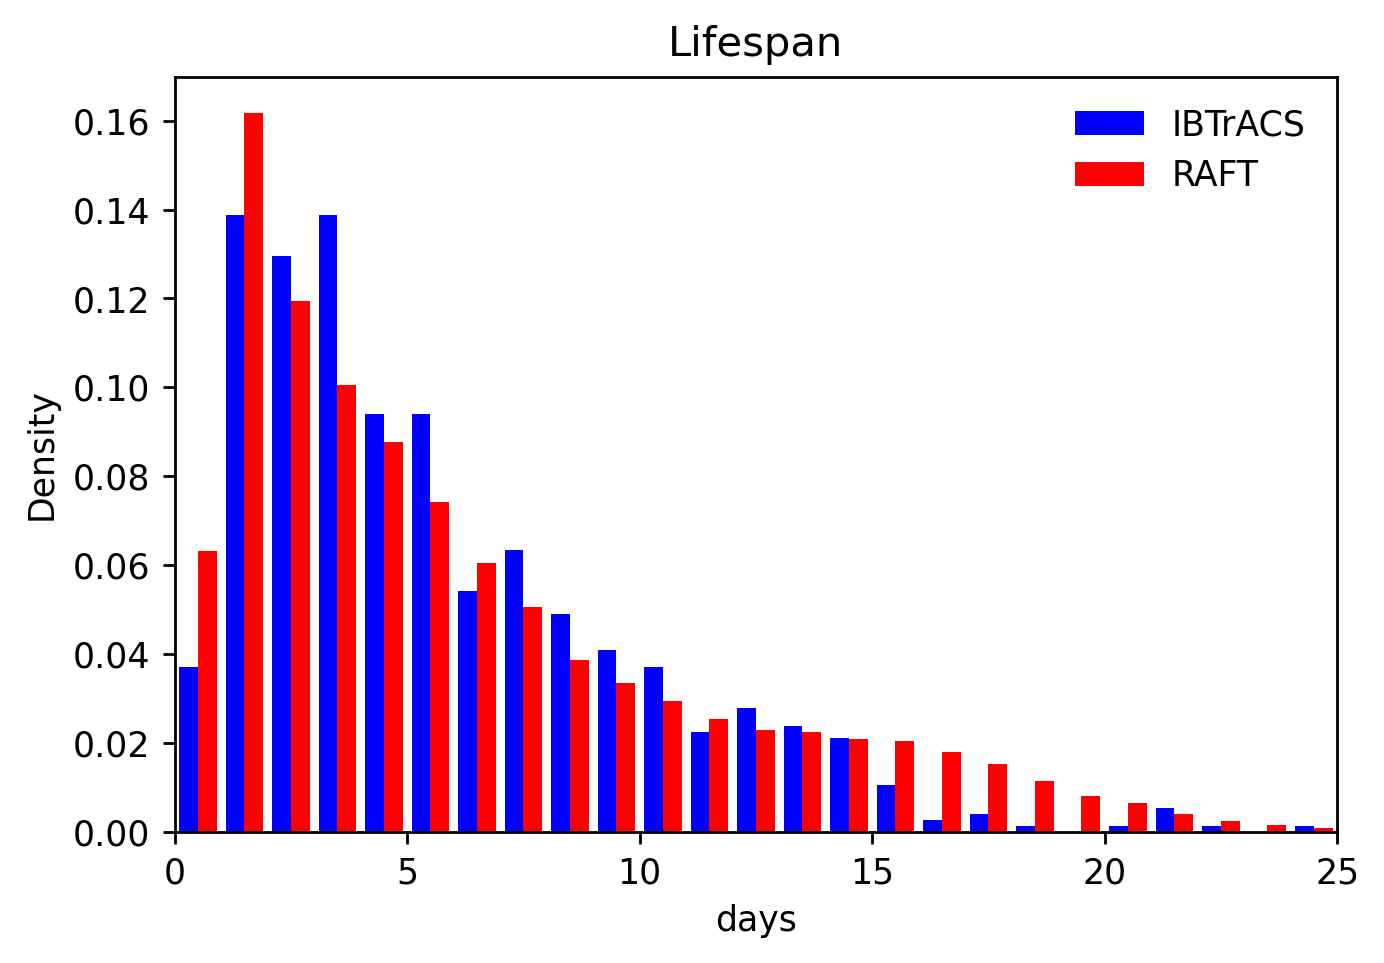

In [13]:
fig, ax = plt.subplots(1,1,dpi=250)

bins = np.linspace(0,25,26)
ax.hist([life_obs_ls, life_RAFT_ls],bins=bins, density=True, color=['blue', 'red'],label=['IBTrACS', 'RAFT'])
ax.legend(frameon=False)
ax.set_xlim([0,25])
ax.set_xlabel('days')
ax.set_title('Lifespan')
ax.set_ylabel('Density')

### RECORD 6-hourly intensification rate

In [14]:
def record_vs6(lonmc, latmc,vsmc, obs=False):
    '''record the 6 hourly intensification rate in list'''
    vs6_ls = []
    for i in range(lonmc.shape[0]):
        # for IBTRACS, need to filter out time steps that are not 6 hourly, and the first recording is not necessarily 6 hourly
        j_start = 0
        if obs:
            if yearic[i] < 1970:
                continue
#         else:
#             if i > yearic[yearic>1970].shape[0]:
#                 break
        if obs:
            for j in range(0,lonmc.shape[1]):
                if hourmc[i,j] in [0,6,12,18]:
                    j_start = j
                    break
        #print(i, end=',')
        vs_old = np.nan
        for j in range(j_start,lonmc.shape[1]):
            if np.isnan(lonmc[i,j]):
                break
            if obs:
                if not hourmc[i,j] in [0,6,12,18]:
                    continue

            if np.isnan(vs_old) or vs_old == 0  or vsmc[i,j] == 0:
                vs_old = vsmc[i,j]
                continue
#             if obs:
#                 print(j, dates[i,j],lonmc[i,j], vsmc[i,j], vs_old)
#             else:
#                 print(j, lonmc[i,j], vsmc[i,j], vs_old)
            vs6 = vsmc[i,j] - vs_old
            vs_old = vsmc[i,j]
                
            vs6_ls.append(vs6)

    return vs6_ls

In [15]:
def record_vs24(lonmc, latmc,vsmc, obs=False):
    '''record the 24 hourly intensification rate in list'''
    vs24_ls = []
    for i in range(lonmc.shape[0]):
        # for IBTRACS, need to filter out time steps that are not 6 hourly, and the first recording is not necessarily 6 hourly        
        j_start = 0
        if obs:
            if yearic[i] < 1970:
                continue
        if obs:
            for j in range(0,lonmc.shape[1]):
                if hourmc[i,j] in [0,6,12,18]:
                    j_start = j
                    break
        #print(i, end=',')
        vs_old = np.nan
        for j in range(j_start,lonmc.shape[1]):
            if np.isnan(lonmc[i,j]) or vsmc[i,j] == 0:
                break
            if obs:
                if not hourmc[i,j] in [0,6,12,18]:
                    continue
            # find the next 24 hour intenisty
            if obs:
                for j24 in range(j, lonmc.shape[1]):
                    if (dates[i,j24] - dates[i,j]).item().total_seconds()/3600 == 24:
                        vs_future = vsmc[i,j24]
                        break
            else:
                if j < lonmc.shape[1]-4:
                    vs_future = vsmc[i,j+4]
                else:
                    break

            vs24 = vs_future - vsmc[i,j]

            if np.isnan(vs24):
                continue

            vs24_ls.append(vs24)

#             #print for verification
#             if obs:
#                 print(j, dates[i,j],lonmc[i,j], vsmc[i,j], vs24)
#             else:
#                 print(j, lonmc[i,j], vsmc[i,j], vs24)

    return vs24_ls

In [16]:
vs24_ls = record_vs24(lonmc, latmc, vsmc, obs=True)

In [17]:
vs24_syn_ls = record_vs24(lonsyn, latsyn,vmaxsyn, obs=False)

In [18]:
## Percentage of RI (7.5 knot/6 hour) in RAFT and observation
vs24_syn_ls = np.array(vs24_syn_ls)
vs24_ls = np.array(vs24_ls)
print('Percentage of RI (30 knot/24 hour) in RAFT', len(vs24_syn_ls[vs24_syn_ls>=30])/len(vs24_syn_ls))
print('Percentage of RI (30 knot/24 hour) in obs', len(vs24_ls[vs24_ls>=30])/len(vs24_ls))

print('mean of translation speed in RAFT', np.mean(transpd_obs))
print('mean of translation speed in obs', np.mean(transpd_syn))
print('std of translation speed in RAFT', np.std(transpd_obs))
print('std of translation speed in obs', np.std(transpd_syn))
print('distance in # std: ', (np.mean(transpd_obs)-np.mean(transpd_syn))/np.std(transpd_obs))

Percentage of RI (30 knot/24 hour) in RAFT 0.03351422535471134
Percentage of RI (30 knot/24 hour) in obs 0.03783990158231876
mean of translation speed in RAFT 1.327535429199873
mean of translation speed in obs 1.2677342
std of translation speed in RAFT 0.9519151825613567
std of translation speed in obs 0.81244695
distance in # std:  0.06282204584545177


In [19]:
bins = np.linspace(37.5,172.5,28)
bins

array([ 37.5,  42.5,  47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,
        82.5,  87.5,  92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5,
       127.5, 132.5, 137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5,
       172.5])

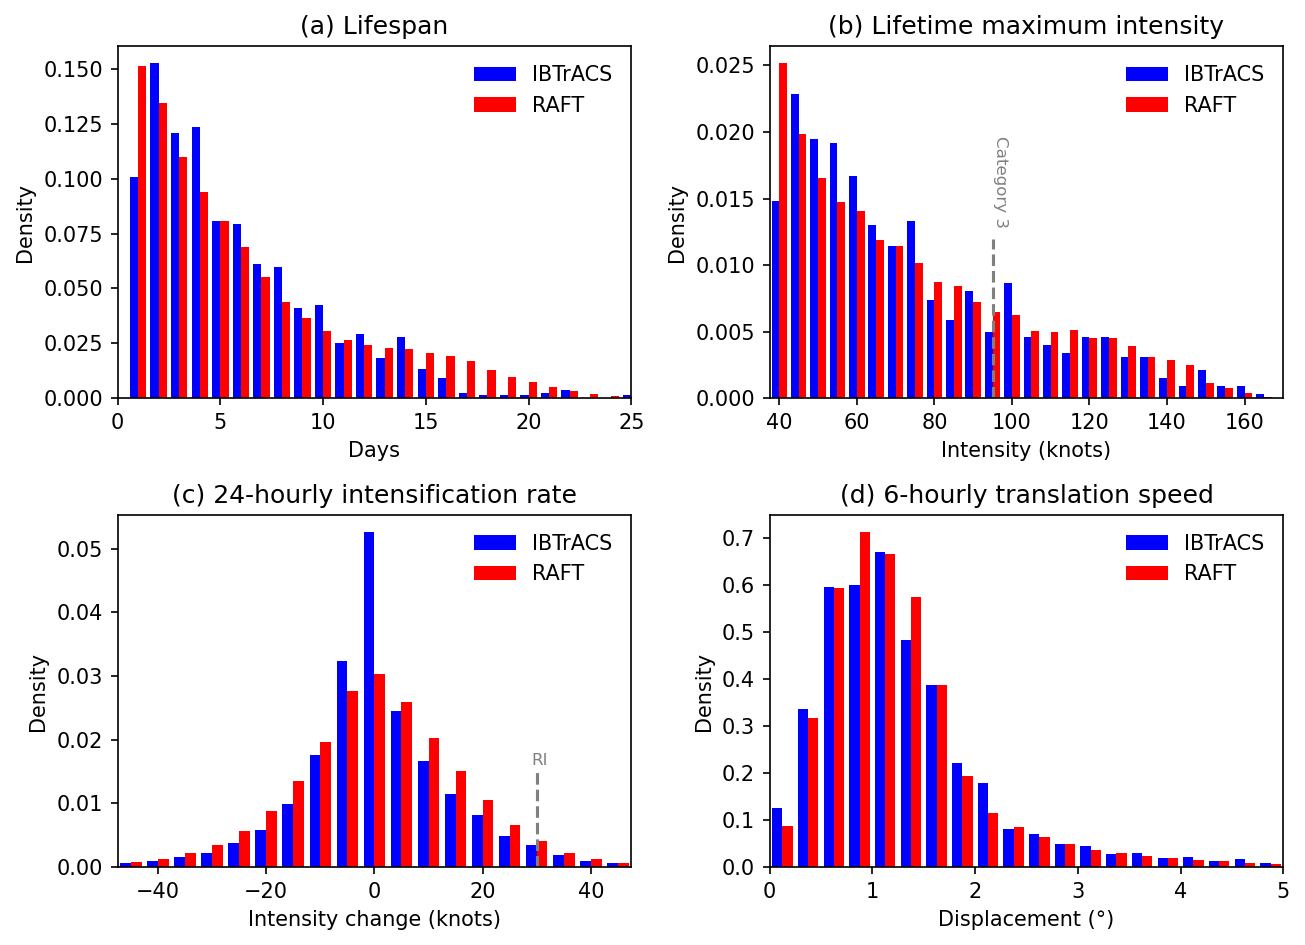

In [20]:
fig, axs = plt.subplots(2,2,figsize=(11*0.8,8*0.8),dpi=150)

ax = axs[0,0]
bins = np.linspace(0.5,25.5,26)
ax.hist([life_obs_ls, life_RAFT_ls],bins=bins, density=True, color=['blue', 'red'],label=['IBTrACS', 'RAFT'])
ax.legend(frameon=False)
ax.set_xlim([0,25])
ax.set_xlabel('Days')
ax.set_title('(a) Lifespan')
ax.set_ylabel('Density')

ax = axs[0,1]
temp = vs0_hist_max[1430:]
temp = temp[temp>33] # filter out observed tracks that does not reach the synthetic genesis intensity
bins = np.linspace(37.5,172.5,28)
ax.hist([temp, vs0_syn_max],bins=bins, density=True, color=['blue', 'red'],label=['IBTrACS', 'RAFT'])
# sns.kdeplot(temp, color='blue', ax=ax,clip=[33,180])
# sns.kdeplot(vs0_syn_max, color='red', ax=ax,clip=[33,180])
ax.plot([95,95], [0,0.012],c='grey',linestyle='--')
ax.text(95,0.013,'Category 3', rotation=270, fontsize=8,color='grey')
ax.legend(frameon=False)
ax.set_xlim([37.5,170])
ax.set_xlabel('Intensity (knots)')
ax.set_title('(b) Lifetime maximum intensity')
ax.set_ylabel('Density')

ax = axs[1,0]
bins = np.linspace(-47.5,47.5,20)
ax.hist([vs24_ls, vs24_syn_ls],bins=bins, density=True, color=['blue', 'red'],label=['IBTrACS', 'RAFT'])
ax.set_xlim([-47.5,47.5])
ax.plot([30,30],[0,0.015],c='grey',linestyle='--')
ax.text(29,0.016, 'RI', fontsize=8,color='grey')
ax.set_xlabel('Intensity change (knots)')
ax.set_title('(c) 24-hourly intensification rate')
ax.set_ylabel('Density')
ax.legend(frameon=False)

ax = axs[1,1]
bins = np.linspace(-0.5,5.5,25)
ax.hist([transpd_obs, transpd_syn],bins=bins, density=True, color=['blue', 'red'],label=['IBTrACS', 'RAFT'])
ax.set_xlim([0,5])
ax.set_xlabel('Displacement (\N{DEGREE SIGN})')
ax.set_title('(d) 6-hourly translation speed')
ax.set_ylabel('Density')
ax.legend(frameon=False)

plt.tight_layout()
plt.savefig('analysis/Fig. 3 transpds and intensity histogram.png', dpi=330)

### Landfall at cities count

In [21]:
city_name_df = pd.read_csv('Dataset_paper_code_and_data/data/city_name.csv')
city_names = city_name_df.name.tolist()[:-1]
city_names[13], city_names[50]

('New York City', 'Houston')

In [22]:
# count TC landfalls at 51 cities

#51 city coordinates to points and then to polygon
coordinates = loadmat('Dataset_paper_code_and_data/data/city_coordinates.mat')
city_lat = coordinates['city_lat'][:-1]
city_lon = coordinates['city_lon'][:-1]

city_point_ls = [Point(xy) for xy in zip(city_lon.reshape(-1,), city_lat.reshape(-1,))]

In [23]:
# TC landfalls intensity at 50 cities

city_hit_vs_obs = np.zeros(city_lat.shape)
ivs_ls = []
for icity, city in enumerate(city_point_ls):
    buffer = city.buffer(1)
    
    ivs_ls.append([])
    for i in range(latmc.shape[0]):
        for j in range(latmc.shape[1]):
            if np.isnan(vsmc[i,j]) or vsmc[i,j] < 25:
                continue
            if hourmc[i,j] not in list(range(0,24,6)):
                continue
            if ((latmc[i,j]-city_lat[icity])**2 + (lonmc[i,j]-city_lon[icity])**2)**0.5 <=1:
                ivs_ls[icity].append(vsmc[i,j])
                break
                
    city_hit_vs_obs[icity] = np.mean(ivs_ls[icity])
    print(icity, city_hit_vs_obs[icity], end=', ')
    
#city_hit_vs_obs

0 [39.375], 1 [43.42105263], 2 [44.04761905], 3 [41.66666667], 4 [46.45833333], 5 [46.77419355], 6 [48.67647059], 7 [45.81081081], 8 [49.61538462], 9 [46.4], 10 [53.21428571], 11 [45.6], 12 [48.07692308], 13 [48.14814815], 14 [45.38461538], 15 [47.03703704], 16 [45.83333333], 17 [45.41666667], 18 [45.], 19 [45.45454545], 20 [45.], 21 [45.52631579], 22 [46.19047619], 23 [40.25], 24 [45.625], 25 [46.20967742], 26 [54.12087912], 27 [51.20481928], 28 [49.64705882], 29 [47.26744186], 30 [48.69863014], 31 [49.9375], 32 [49.875], 33 [49.75308642], 34 [56.2804878], 35 [56.04938272], 36 [57.70114943], 37 [59.01162791], 38 [64.46153846], 39 [50.70422535], 40 [52.08333333], 41 [58.69230769], 42 [58.02816901], 43 [55.67164179], 44 [56.93548387], 45 [55.98484848], 46 [59.75308642], 47 [58.75], 48 [56.96078431], 49 [59.67213115], 50 [52.81818182], 

In [25]:
# TC landfalls intensity at 50 cities for RAFT TCs

city_hit_vs_syn = np.zeros(city_lat.shape)
ivs_syn_ls = []

for icity, city in enumerate(city_point_ls):
    ivs_syn_ls.append([])

    for i in range(lonsyn.shape[0]):
        lats = latsyn[i,:]
        lons = lonsyn[i,:]
        vs = vmaxsyn[i,:] 
        for j in range(lonsyn.shape[1]):
            if np.isnan(vs[j]) or vs[j] < 25:
                break

            if ((lats[j]-city_lat[icity])**2 + (lons[j]-city_lon[icity])**2)**0.5 <=1:
                ivs_syn_ls[icity].append(vs[j])
                break
                
    city_hit_vs_syn[icity] = np.mean(ivs_syn_ls[icity])
    print(icity, city_hit_vs_syn[icity], end=', ') 

0 [36.70848846], 1 [38.55450439], 2 [37.54546356], 3 [37.1200676], 4 [38.87149429], 5 [38.74964905], 6 [38.83615112], 7 [39.34451294], 8 [40.57180405], 9 [37.9148941], 10 [43.33919907], 11 [36.54191589], 12 [36.90910339], 13 [37.02888107], 14 [36.52863312], 15 [36.87043762], 16 [36.7739563], 17 [36.51921844], 18 [36.4985466], 19 [36.41139603], 20 [36.60564041], 21 [36.68474197], 22 [37.12790298], 23 [35.55981445], 24 [39.60710144], 25 [41.1031723], 26 [44.63053131], 27 [41.02116013], 28 [39.69990921], 29 [42.57172394], 30 [47.164505], 31 [47.64633179], 32 [47.77104187], 33 [47.72001648], 34 [57.35985184], 35 [57.23759079], 36 [58.56765747], 37 [58.91238785], 38 [57.93338394], 39 [56.10426712], 40 [55.42340469], 41 [44.70820618], 42 [44.09318161], 43 [42.30480576], 44 [45.40803909], 45 [48.23983383], 46 [52.67218781], 47 [44.98669434], 48 [39.73033524], 49 [41.52397537], 50 [36.29980087], 

In [26]:
# TC landfall count using the landfall intensity list
city_hit_count_syn = np.zeros(city_lat.shape)
for icity, city in enumerate(city_point_ls):
    city_hit_count_syn[icity] = len(ivs_syn_ls[icity])
    
city_hit_count_obs_new = np.zeros(city_lat.shape)
for icity, city in enumerate(city_point_ls):
    city_hit_count_obs_new[icity] = len(ivs_ls[icity])
#print(city_hit_count_syn, city_hit_count_obs_new)

In [27]:
city_hit_count_syn  = city_hit_count_syn / num_syn * 100
city_hit_count_obs_new  = city_hit_count_obs_new / latmc.shape[0] * 100

In [28]:
city_hit_vs99_syn = np.zeros(city_lat.shape)
city_hit_vs95_syn = np.zeros(city_lat.shape)

for icity, city in enumerate(city_point_ls):
                
    city_hit_vs99_syn[icity] = np.percentile(ivs_syn_ls[icity],99)
    city_hit_vs95_syn[icity] = np.percentile(ivs_syn_ls[icity],95)
    print(icity, city_hit_vs99_syn[icity], end=', ') 
    
city_hit_vs99_obs = np.zeros(city_lat.shape)
city_hit_vs95_obs = np.zeros(city_lat.shape)

for icity, city in enumerate(city_point_ls):
                
    city_hit_vs99_obs[icity] = np.percentile(ivs_ls[icity],99)
    city_hit_vs95_obs[icity] = np.percentile(ivs_ls[icity],95)
    print(icity, city_hit_vs99_obs[icity], end=', ') 

0 [67.3010495], 1 [68.89426071], 2 [64.7506955], 3 [67.72490326], 4 [68.71326279], 5 [71.98877632], 6 [73.15021912], 7 [66.42918686], 8 [80.7533432], 9 [76.47396591], 10 [83.2721875], 11 [70.99380112], 12 [70.95975883], 13 [70.93880974], 14 [65.93235497], 15 [72.33361084], 16 [70.0433786], 17 [63.21440948], 18 [63.09368652], 19 [65.4525095], 20 [65.33913361], 21 [65.98396019], 22 [65.06876373], 23 [65.22356987], 24 [77.27893074], 25 [85.85446152], 26 [101.50178802], 27 [86.91230057], 28 [81.76071976], 29 [85.16062836], 30 [93.73020439], 31 [101.14183754], 32 [101.16918015], 33 [101.1309005], 34 [123.01946426], 35 [122.10412735], 36 [125.12006073], 37 [127.59109261], 38 [122.72505318], 39 [114.37582855], 40 [118.79246651], 41 [90.62494537], 42 [91.12521515], 43 [90.82274994], 44 [102.65569183], 45 [106.43400475], 46 [123.07640503], 47 [100.23659744], 48 [77.20065681], 49 [90.82262993], 50 [73.34134674], 0 [76.25], 1 [74.1], 2 [76.], 3 [60.], 4 [80.], 5 [80.], 6 [80.], 7 [83.2], 8 [91.2]

In [29]:
np.nanmax(vs0_syn_max), np.nanmean(vs0_syn_max), np.nanmedian(vs0_syn_max)

C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\numpy\core\fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(173.2609, 64.859634, 55.38639)

### Landfall city hit count

In [30]:
icity_ls = [13, 25,26,30, 37, 45, 50]
for icity in icity_ls:
    print(city_names[icity])

New York City
Norfolk
Wilmington
Jacksonville
Miami
New Orleans
Houston


In [31]:
from sklearn.utils import resample

boot_intercept = np.zeros([10_000,])
boot_slope = np.zeros([10_000,])
boot_r2 = np.zeros([10_000,])
boot_pred = np.zeros([len(city_point_ls), 10_000])

city_hit_count_obs_new_sorted = np.sort(np.squeeze(city_hit_count_obs_new))
print(city_hit_count_obs_new_sorted.shape)
for iboot in range(10_000):
    boot = resample(range(len(city_point_ls)), n_samples=len(city_point_ls))
    boot_syn = city_hit_count_syn[boot]
    boot_obs= city_hit_count_obs_new[boot]

    #fit linear regression
    regr = linear_model.LinearRegression()
    regr.fit(boot_obs, boot_syn)
    pred = regr.predict(boot_obs)
    # plt.scatter(boot_obs, boot_syn)
    # plt.plot(boot_obs, pred, 'grey')
    boot_intercept[iboot] = regr.intercept_[0]
    boot_slope[iboot] = regr.coef_[0][0]
    boot_r2[iboot] = r2_score(boot_syn, pred)
    
    boot_pred[:,iboot] = np.squeeze(regr.predict(city_hit_count_obs_new_sorted.reshape(-1,1)))
boot_r2.sort()
boot_intercept.sort()
boot_slope.sort()
print(boot_r2[250-1], boot_r2[9750-1],)
print(boot_intercept[250-1], boot_intercept[9750-1],)
print(boot_slope[250-1], boot_slope[9750-1],)


# pred_low = city_hit_count_obs_new_sorted* boot_slope[250-1] + boot_intercept[250-1]
# pred_high = city_hit_count_obs_new_sorted * boot_slope[9750-1] + boot_intercept[9750-1]
boot_pred_sorted = np.sort(boot_pred, axis=1)
pred_low = boot_pred_sorted[:,250-1]
pred_high = boot_pred_sorted[:,9750-1]

(51,)
0.6780256031186351 0.9074469191963751
0.469519994400323 0.7164867956333283
0.4082130613914051 0.5065487642098561


C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


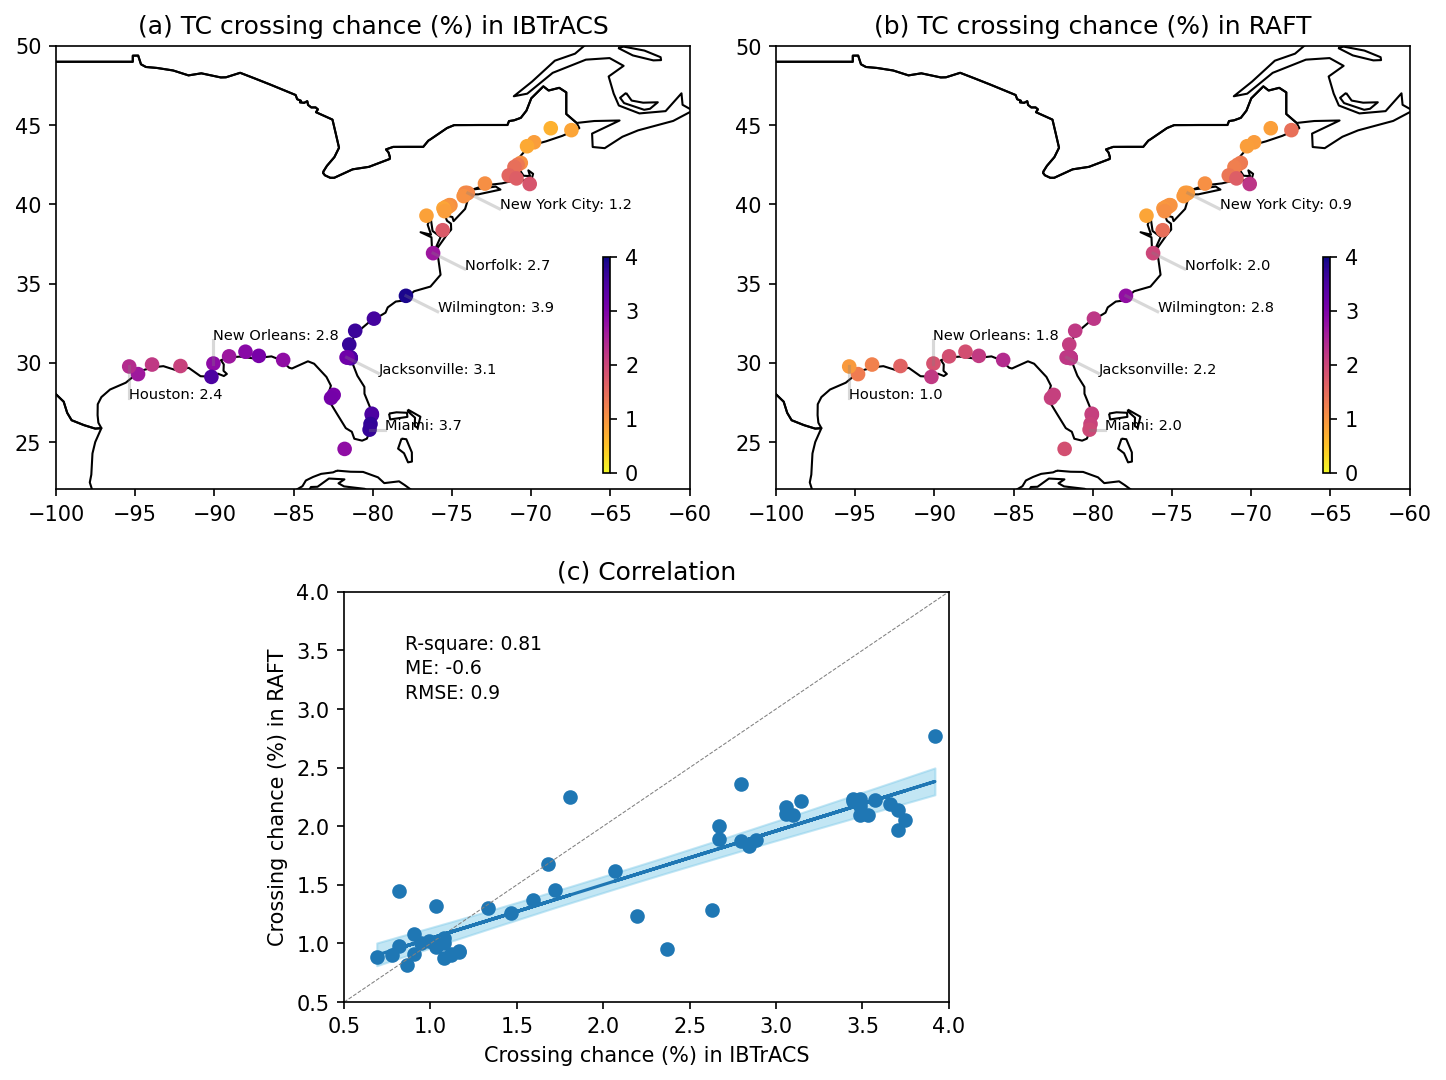

In [32]:
fig = plt.figure(figsize=(12*0.8,9*0.8),dpi=150)

ax = fig.add_axes([0.04,0.5, 0.44,0.48])
ax.set_title('(a) TC crossing chance (%) in IBTrACS')
world.plot(ax=ax, facecolor='none',edgecolor='k',linewidth=1)
ax.set_xlim(-100, -60)
ax.set_ylim(22, 50)
for icity in icity_ls:
    if city_lat[icity]>27 and city_lat[icity]<32 and city_lon[icity]<-87:
        x_setback, y_setback = 0, 1.5
        if city_lon[icity]<-93:
            x_setback, y_setback = 0, -2
    elif city_lat[icity]<27:
        x_setback, y_setback = 1, 0
    else:
        x_setback, y_setback = 2, -1
    ax.text(city_lon[icity]+x_setback,city_lat[icity]+y_setback,city_names[icity]+': '+format(city_hit_count_obs_new[icity][0],'.1f'),fontsize=7)
    ax.plot([city_lon[icity], city_lon[icity]+x_setback], [city_lat[icity], city_lat[icity]+y_setback], color='grey',alpha=0.3)
mycolor = ax.scatter(city_lon, city_lat, c=city_hit_count_obs_new, cmap='plasma_r',vmin=0,vmax=4)
ax.scatter(city_lon[30], city_lat[30], c=city_hit_count_obs_new[30], cmap='plasma_r',vmin=0,vmax=4)
ax = fig.add_axes([0.42,0.55,0.005,0.2])
mycolorbar = plt.colorbar(mycolor,fraction=0.015,cax=ax)

ax = fig.add_axes([0.54,0.5, 0.44,0.48])
ax.set_title('(b) TC crossing chance (%) in RAFT')
world.plot(ax=ax, facecolor='none',edgecolor='k',linewidth=1)
ax.set_xlim(-100, -60)
ax.set_ylim(22, 50)
for icity in icity_ls:
    if city_lat[icity]>27 and city_lat[icity]<32 and city_lon[icity]<-87:
        x_setback, y_setback = 0, 1.5
        if city_lon[icity]<-93:
            x_setback, y_setback = 0, -2
    elif city_lat[icity]<27:
        x_setback, y_setback = 1, 0
    else:
        x_setback, y_setback = 2, -1
    ax.text(city_lon[icity]+x_setback,city_lat[icity]+y_setback,city_names[icity]+': '+format(city_hit_count_syn[icity][0], '.1f'),fontsize=7)
    ax.plot([city_lon[icity], city_lon[icity]+x_setback], [city_lat[icity], city_lat[icity]+y_setback], color='grey',alpha=0.3)
mycolor = ax.scatter(city_lon, city_lat, c=city_hit_count_syn, cmap='plasma_r',vmin=0,vmax=4)
ax.scatter(city_lon[30], city_lat[30], c=city_hit_count_syn[30], cmap='plasma_r',vmin=0,vmax=4)
ax = fig.add_axes([0.92,0.55,0.005,0.2])
mycolorbar = plt.colorbar(mycolor,fraction=0.015,cax=ax)

ax = fig.add_axes([0.24,0.06, 0.42,0.38])
ax.set_xlabel('Crossing chance (%) in IBTrACS')
ax.set_ylabel('Crossing chance (%) in RAFT')
ax.set_xlim([0.5, 4])
ax.set_ylim([0.5, 4])
ax.fill_between(np.squeeze(city_hit_count_obs_new_sorted), np.squeeze(pred_low), np.squeeze(pred_high),alpha=0.5,color='skyblue')
ax.plot([0.5, 4],[0.5, 4],color='grey',linestyle='--',linewidth=0.5)
ax.scatter(city_hit_count_obs_new,city_hit_count_syn)
regr = linear_model.LinearRegression()
regr.fit(city_hit_count_obs_new, city_hit_count_syn)
pred = regr.predict(city_hit_count_obs_new)
ax.plot(city_hit_count_obs_new, pred, 'C0')

ax.text(0.1,0.86, 'R-square: '+'{0:.2f}'.format(r2_score(city_hit_count_syn, pred)), transform=ax.transAxes, fontsize=9)
ax.text(0.1,0.8, 'ME: '+'{0:.1f}'.format(np.mean(city_hit_count_syn  - city_hit_count_obs_new)), transform=ax.transAxes, fontsize=9)
ax.text(0.1,0.74, 'RMSE: '+'{0:.1f}'.format(np.sqrt(np.mean((city_hit_count_syn - city_hit_count_obs_new)**2))), transform=ax.transAxes, fontsize=9)
ax.set_title('(c) Correlation')

plt.tight_layout()
plt.savefig('analysis/Fig 4. Landfall count at 50 cities.png', dpi=330)

In [38]:
print('confidence interval width: ', np.nanmean(pred_high -pred_low))
print('std of data: ', np.std(city_hit_count_obs_new_sorted))
print('fraction (%): ', np.nanmean(pred_high -pred_low) / np.std(city_hit_count_obs_new_sorted) * 100)
import scipy
corr_coef, p_value = scipy.stats.pearsonr(np.squeeze(city_hit_count_obs_new), np.squeeze(city_hit_count_syn))
print('crossing chance Pearson Correlation from scipy, corr_coef and pvalue:', corr_coef, p_value, print(f"{p_value:.1e}"))

corr_coef, p_value = scipy.stats.pearsonr(np.squeeze(city_hit_vs99_obs), np.squeeze(city_hit_vs99_syn))
print('intensity Pearson Correlation from scipy, corr_coef and pvalue:', corr_coef, p_value, print(f"{p_value:.1e}"))

confidence interval width:  0.17319971415881089
std of data:  1.0850330987567471
fraction (%):  15.96262034377261
4.2e-19
crossing chance Pearson Correlation from scipy, corr_coef and pvalue: 0.8980870786277315 4.165335357567772e-19 None
2.3e-15
intensity Pearson Correlation from scipy, corr_coef and pvalue: 0.8518129558254124 2.301955418144513e-15 None


In [34]:
#city_hit_vs99_obs,city_hit_vs99_syn

boot_intercept = np.zeros([10_000,])
boot_slope = np.zeros([10_000,])
boot_r2 = np.zeros([10_000,])
boot_pred = np.zeros([len(city_point_ls), 10_000])

city_hit_vs99_obs_sorted = np.sort(np.squeeze(city_hit_vs99_obs))

for iboot in range(10_000):
    boot = resample(range(len(city_point_ls)), n_samples=len(city_point_ls))
    boot_syn = city_hit_vs99_syn[boot]
    boot_obs= city_hit_vs99_obs[boot]

    #fit linear regression
    regr = linear_model.LinearRegression()
    regr.fit(boot_obs, boot_syn)
    pred = regr.predict(boot_obs)
    # plt.scatter(boot_obs, boot_syn)
    # plt.plot(boot_obs, pred, 'grey')
    boot_intercept[iboot] = regr.intercept_[0]
    boot_slope[iboot] = regr.coef_[0][0]
    boot_r2[iboot] = r2_score(boot_syn, pred)
    
    boot_pred[:,iboot] = np.squeeze(regr.predict(city_hit_vs99_obs_sorted.reshape(-1,1)))
boot_r2.sort()
boot_intercept.sort()
boot_slope.sort()
print(boot_r2[250-1], boot_r2[9750-1],)
print(boot_intercept[250-1], boot_intercept[9750-1],)
print(boot_slope[250-1], boot_slope[9750-1],)


# pred_low = city_hit_count_obs_new_sorted* boot_slope[250-1] + boot_intercept[250-1]
# pred_high = city_hit_count_obs_new_sorted * boot_slope[9750-1] + boot_intercept[9750-1]
boot_pred_sorted = np.sort(boot_pred, axis=1)
pred_low = boot_pred_sorted[:,250-1]
pred_high = boot_pred_sorted[:,9750-1]

0.5826036414546532 0.8458529976359924
-2.8724289788725486 21.754359703500498
0.6613651510888537 0.9526070465782165


C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


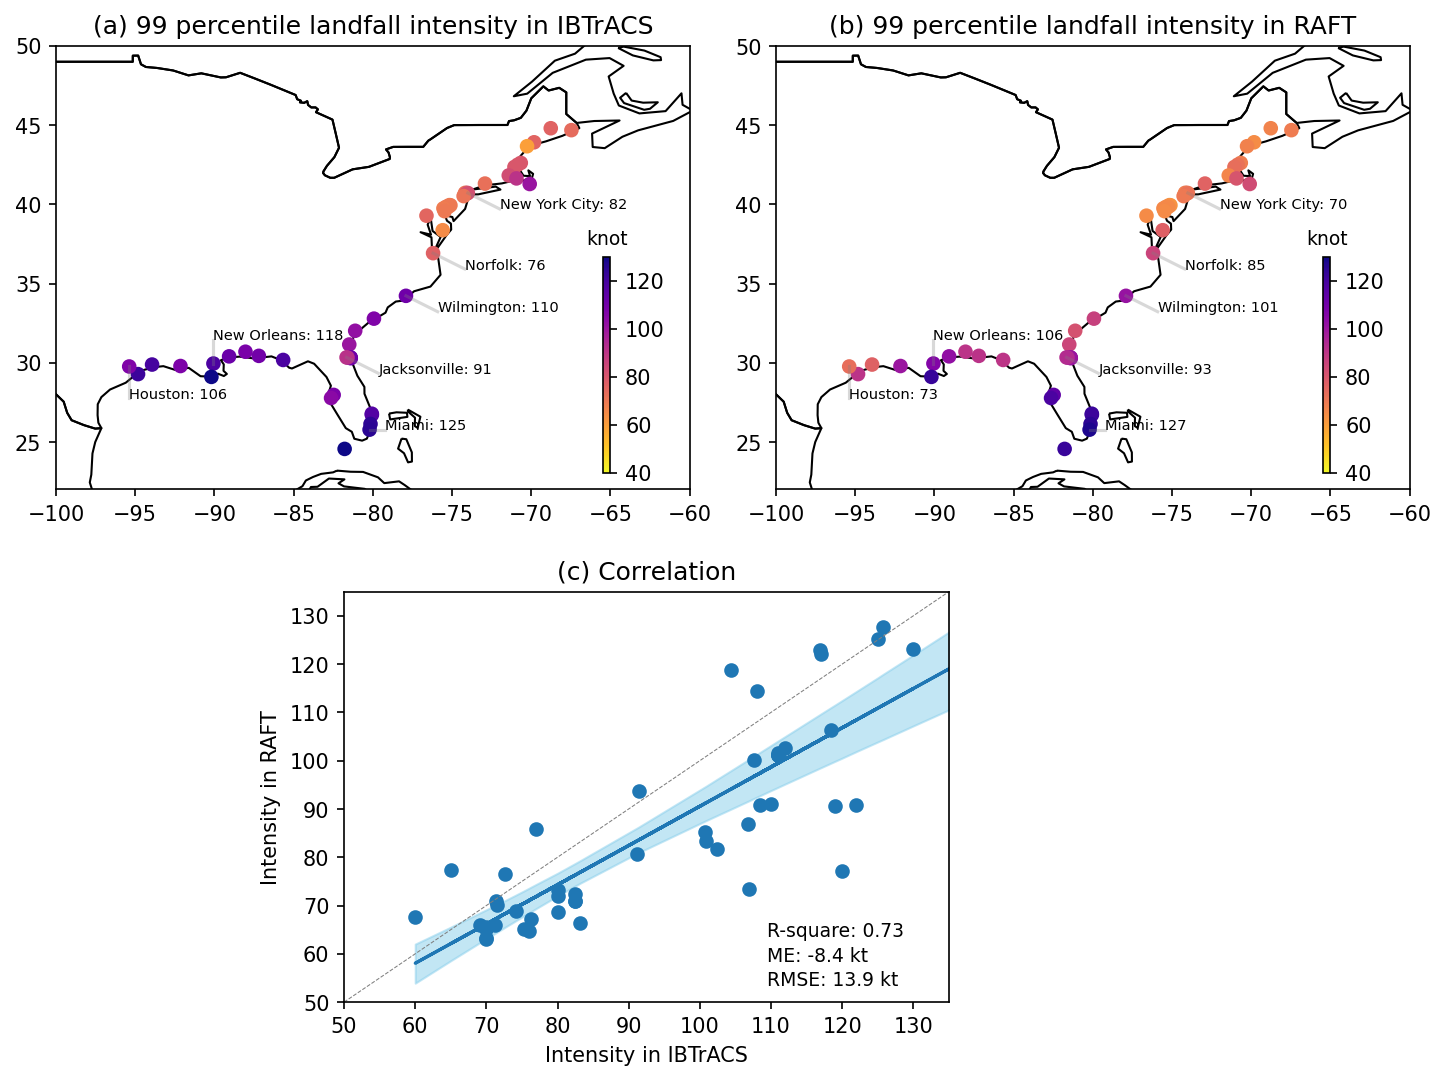

In [35]:
fig = plt.figure(figsize=(12*0.8,9*0.8),dpi=150)

ax = fig.add_axes([0.04,0.5, 0.44,0.48])
ax.set_title('(a) 99 percentile landfall intensity in IBTrACS')
world.plot(ax=ax, facecolor='none',edgecolor='k',linewidth=1)
ax.set_xlim(-100, -60)
ax.set_ylim(22, 50)
for icity in icity_ls:
    if city_lat[icity]>27 and city_lat[icity]<32 and city_lon[icity]<-87:
        x_setback, y_setback = 0, 1.5
        if city_lon[icity]<-93:
            x_setback, y_setback = 0, -2
    elif city_lat[icity]<27:
        x_setback, y_setback = 1, 0
    else:
        x_setback, y_setback = 2, -1
    ax.text(city_lon[icity]+x_setback,city_lat[icity]+y_setback,city_names[icity]+': '+str(int(city_hit_vs99_obs[icity][0])),fontsize=7)
    ax.plot([city_lon[icity], city_lon[icity]+x_setback], [city_lat[icity], city_lat[icity]+y_setback], color='grey',alpha=0.3)
mycolor = ax.scatter(city_lon, city_lat, c=city_hit_vs99_obs, cmap='plasma_r',vmin=40,vmax=130)
ax.scatter(city_lon[30], city_lat[30], c=city_hit_vs99_obs[30], cmap='plasma_r',vmin=40,vmax=130)
ax = fig.add_axes([0.42,0.55,0.005,0.2])
mycolorbar = plt.colorbar(mycolor,fraction=0.015,cax=ax)
mycolorbar.ax.set_title('knot',fontsize=9)

ax = fig.add_axes([0.54,0.5, 0.44,0.48])
ax.set_title('(b) 99 percentile landfall intensity in RAFT')
world.plot(ax=ax, facecolor='none',edgecolor='k',linewidth=1)
ax.set_xlim(-100, -60)
ax.set_ylim(22, 50)
for icity in icity_ls:
    if city_lat[icity]>27 and city_lat[icity]<32 and city_lon[icity]<-87:
        x_setback, y_setback = 0, 1.5
        if city_lon[icity]<-93:
            x_setback, y_setback = 0, -2
    elif city_lat[icity]<27:
        x_setback, y_setback = 1, 0
    else:
        x_setback, y_setback = 2, -1
    ax.text(city_lon[icity]+x_setback,city_lat[icity]+y_setback,city_names[icity]+': '+str(int(city_hit_vs99_syn[icity][0])),fontsize=7)
    ax.plot([city_lon[icity], city_lon[icity]+x_setback], [city_lat[icity], city_lat[icity]+y_setback], color='grey',alpha=0.3)
mycolor = ax.scatter(city_lon, city_lat, c=city_hit_vs99_syn, cmap='plasma_r',vmin=40,vmax=130)
ax.scatter(city_lon[30], city_lat[30], c=city_hit_vs99_syn[30], cmap='plasma_r',vmin=40,vmax=130) #plot Jacksonville again to bring the point to front
ax = fig.add_axes([0.92,0.55,0.005,0.2])
mycolorbar = plt.colorbar(mycolor,fraction=0.015,cax=ax)
mycolorbar.ax.set_title('knot',fontsize=9)


ax = fig.add_axes([0.24,0.06, 0.42,0.38])
ax.set_xlabel('Intensity in IBTrACS')
ax.set_ylabel('Intensity in RAFT')
ax.set_xlim([50,135])
ax.set_ylim([50,135])
ax.fill_between(city_hit_vs99_obs_sorted, pred_low, pred_high,alpha=0.5,color='skyblue')
ax.plot([50,135],[50,135],color='grey',linestyle='--',linewidth=0.5)
ax.scatter(city_hit_vs99_obs,city_hit_vs99_syn)
regr = linear_model.LinearRegression()
regr.fit(city_hit_vs99_obs, city_hit_vs99_syn)
pred = regr.predict(city_hit_vs99_obs)

ax.plot(city_hit_vs99_obs, pred, 'C0')
ax.text(0.7,0.16, 'R-square: '+'{0:.2f}'.format(r2_score(city_hit_vs99_syn, pred)), transform=ax.transAxes, fontsize=9)
ax.text(0.7,0.1, 'ME: '+'{0:.1f}'.format(np.mean(city_hit_vs99_syn  - city_hit_vs99_obs)) + ' kt', transform=ax.transAxes, fontsize=9)
ax.text(0.7,0.04, 'RMSE: '+'{0:.1f}'.format(np.sqrt(np.mean((city_hit_vs99_syn - city_hit_vs99_obs)**2)))+' kt', transform=ax.transAxes, fontsize=9)
ax.set_title('(c) Correlation')

plt.tight_layout()
plt.savefig('analysis/Fig 5. Landfall intensity at 50 cities_99percentile.png', dpi=330)

In [59]:
print('confidence interval width: ', np.nanmean(pred_high -pred_low))
print('std of data: ', np.std(city_hit_vs99_obs_sorted))
print('fraction (%): ', np.nanmean(pred_high -pred_low) / np.std(city_hit_vs99_obs_sorted) * 100)

confidence interval width:  7.876923377245781
std of data:  20.823843928794233
fraction (%):  37.8264618395163


### TC distributions (obs is from 1971)

C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


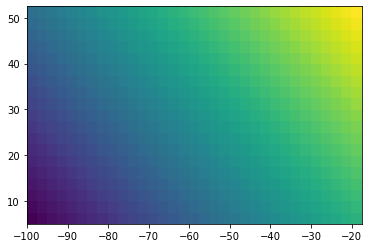

In [38]:
#define the grid: lat 5-55, lon -100, -15
space = 2.5
lat_1d = np.arange(5, 55, space)
lon_1d = np.arange(-100, -15, space)
lon_mesh, lat_mesh = np.meshgrid(lon_1d, lat_1d)
plt.pcolormesh(lon_mesh,lat_mesh, lon_mesh+lat_mesh)

In [39]:
def nine_point_smoother(data):
    # http://www.people.vcu.edu/~mhcrosthwait/clrs322/2DFilteringconcepts.htm
    # https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2010GL042487
    result = data.copy()
    m, n = data.shape[0],data.shape[1]
    for i in range(1,m-1):
        for j in range(1,n-1):
            result[i,j] = data[i-1,j-1]*1 + data[i-1,j]*2 + data[i-1,j+1]*1 +\
            data[i,j-1]*2 + data[i,j]*4 + data[i,j+1]*2 +\
            data[i+1,j-1]*1 + data[i+1,j]*2 + data[i+1,j+1]*1
            
            result[i,j] = result[i,j] / 16.0
    return result

In [40]:
# record TCF
def record_TCF(lonmc,latmc, vsmc, obs=False):
    tcf_raw = np.zeros_like(lon_mesh)

    for i in range(latmc.shape[0]):
        for j in range(latmc.shape[1]):
            lat,lon = latmc[i,j], lonmc[i,j]
            if np.isnan(lat):
                break
            if vsmc[i,j] < 25:
                continue
            if obs:
                if hourmc[i,j] not in list(range(0,24,6)):
                    continue
            ilat = int(np.floor((lat - 5) / space))
            ilon = int(np.floor((lon + 100) / space))
            #print(i,j,lat, lon)
            if ilat < 0 or ilat > lon_mesh.shape[0]-1:
                continue
            if ilon < 0 or ilon > lon_mesh.shape[1]-1:
                continue

            tcf_raw[ilat,ilon] += 1

    tcf = nine_point_smoother(tcf_raw)
    #tcf = tcf_raw
    return tcf

In [41]:
# correct lonmc and latmc for TCF purposes
lonmc_tcf = lonmc.copy()
latmc_tcf = latmc.copy()
for i in range(lonmc.shape[0]):
    # if the tracks start with small intensity < 34, fill the lat lon with zero so that they will not enter the tcf count
    if np.where(vsmc[i,:]>=34)[0].shape[0]>0:
        jstart = np.min(np.where(vsmc[i,:]>=34))
    else:
        jstart = lonmc.shape[1]
    lonmc_tcf[i,0:jstart] = 0
    latmc_tcf[i,0:jstart] = 0
    # after the intensity fall below 25 after peak, terminate tracks by changing the lat lon to zero
    for j in range(jstart, lonmc.shape[1]):
        if vsmc[i,j] < 25:
            lonmc_tcf[i,j] = 0
            latmc_tcf[i,j] = 0

In [42]:
#tcf_obs = record_TCF(lonmc_tcf[:,:],latmc_tcf[:,:]) # 1970 [-781:,:]
tcf_obs = record_TCF(lonmc_tcf[1430:,:],latmc_tcf[1430:,:], vsmc[1430:,:], obs=True)
tcf_syn = record_TCF(lonsyn, latsyn, vmaxsyn)

In [43]:
tcf_syn = tcf_syn / num_syn
tcf_obs = tcf_obs / latmc[1430:,:].shape[0]

In [45]:
## TCF MAE, RMSE
np.nanmean(np.abs(tcf_syn - tcf_obs)), np.sqrt(np.mean(np.square(tcf_syn - tcf_obs)))

(0.012054397236052491, 0.01708064450461886)

In [46]:
tcf_syn[tcf_syn==0] = np.nan
tcf_obs[tcf_obs==0] = np.nan

2732,21243,30403,32103,20757,14935,15430,39512,14650,17089,32230,18983,24152,35665,16921,27469,38984,6921,38804,2163,5072,37619,7877,18430,1871,7599,2496,24675,31921,33523,797,3219,15246,24999,16321,19129,18676,31230,11723,17591,26752,23605,6021,20006,3560,25332,31055,21368,20737,28647,26681,14627,12134,20571,9781,19340,27257,16298,12372,4420,39876,17455,14324,38019,7012,9396,3918,9359,23482,15127,35725,37237,14165,8752,14505,5795,23647,28254,36530,25392,16221,18819,34402,973,20848,10215,11157,24777,13824,2418,12843,13242,36223,6521,22626,9123,31454,14254,23700,37073,38299,23310,31785,15041,23306,36950,13160,26635,33075,13392,14368,5302,33920,23334,38062,35260,27112,13592,25213,33538,15875,8286,38763,18728,13640,3091,3912,6594,21752,23532,7997,15620,4845,26763,3533,2937,26221,37707,19608,5021,26773,33902,17340,1913,13429,13907,35489,10088,15588,38395,38214,469,8717,34488,38040,16975,38953,15912,28086,16591,15115,14447,28665,11052,15741,28739,5103,35050,1740,12579,5846,20165,2775,18987,

C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:64: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


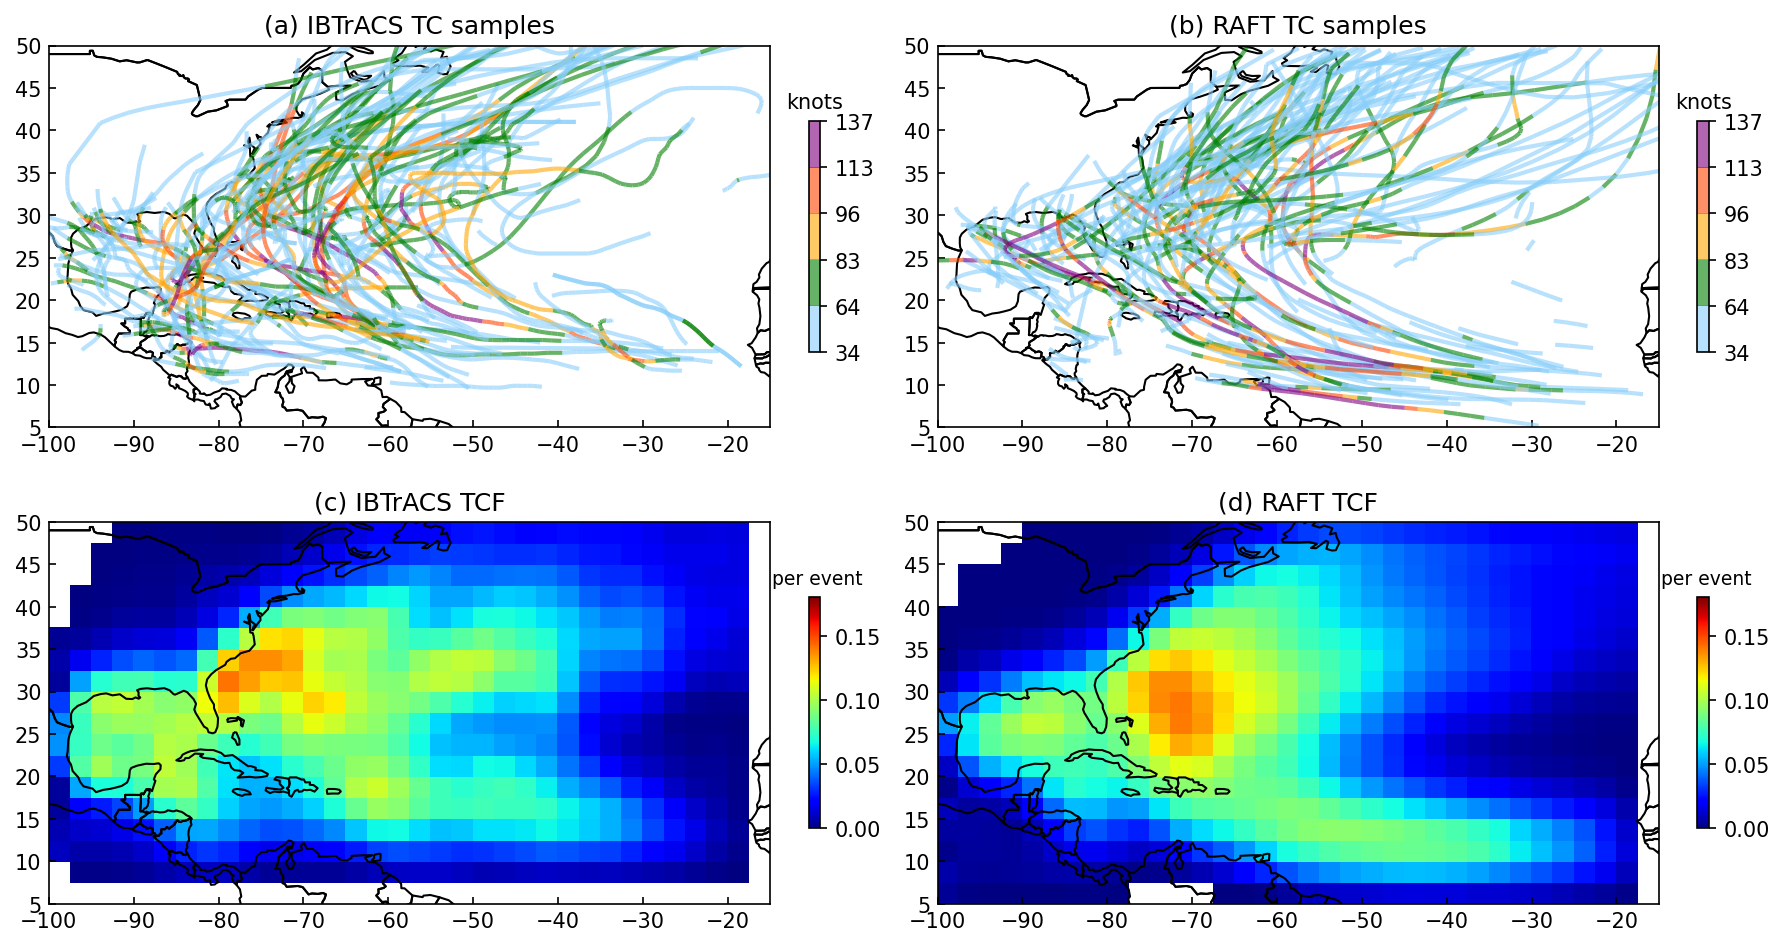

In [47]:
random_seed = 0#21
cmp = ListedColormap(['lightskyblue','green','orange','orangered','purple'])
norm = BoundaryNorm([34,64,83,96,113,137], cmp.N)

fig,axes = plt.subplots(2,2,dpi=150,figsize=(12,6.5))

ax = axes[0,0]
np.random.seed(random_seed)
for i in np.random.randint(low=0,high=vsmc.shape[0],size=200):
    x = lonmc[i,:]
    y = latmc[i,:]
    vs = vsmc[i,:]
    vs[vs==0] = np.nan
    vs[vs<34] = np.nan
    x = x[~np.isnan(vs)]
    y = y[~np.isnan(vs)]
    vs = vs[~np.isnan(vs)]
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments_i = np.concatenate([points[:-1], points[1:]], axis=1)
    ##  plot by step intensity
    lc = LineCollection(segments_i, cmap=cmp, norm=norm, alpha=0.6)
    lc.set_array(vs)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
world.plot(ax=ax, facecolor='none',edgecolor='k',linewidth=1)
clb = plt.colorbar(line, ax=ax,fraction=0.015)
clb.ax.set_title('knots',fontsize=10)
ax.set_title('(a) IBTrACS TC samples')
    
ax = axes[0,1]
np.random.seed(random_seed)
for i in  np.random.randint(low=0,high=lonsyn.shape[0],size=200): 
    print(i, end=',')
    x = lonsyn[i,:]
    y = latsyn[i,:]
    vs = vmaxsyn[i,:]
    vs[vs<34] = np.nan
    x = x[~np.isnan(vs)]
    y = y[~np.isnan(vs)]
    vs = vs[~np.isnan(vs)]

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments_i = np.concatenate([points[:-1], points[1:]], axis=1)
    
    ##  plot by step intensity
    lc = LineCollection(segments_i, cmap=cmp, norm=norm, alpha=0.6)
    lc.set_array(vs)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
world.plot(ax=ax, facecolor='none',edgecolor='k',linewidth=1)
clb = plt.colorbar(line, ax=ax, fraction=0.015)
clb.ax.set_title('knots',fontsize=10)
ax.set_title('(b) RAFT TC samples')

ax = axes[1,0]
mypcolor = ax.pcolormesh(lon_mesh,lat_mesh, tcf_obs,cmap='jet',vmin=0,vmax=0.18) #,vmin=-0.05,vmax=0.05
clb = plt.colorbar(mypcolor, fraction=0.015,ax=ax)
clb.ax.set_title(' per event',fontsize=9)
world.plot(ax=ax,edgecolor='k',linewidth=1,facecolor='none')
ax.set_title('(c) IBTrACS TCF')  #1971-2021

ax = axes[1,1]
mypcolor = ax.pcolormesh(lon_mesh,lat_mesh, tcf_syn,cmap='jet',vmin=0,vmax=0.18) #,vmin=-0.05,vmax=0.05, cmap='Reds'
clb = plt.colorbar(mypcolor, fraction=0.015,ax=ax) #shrink=0.6,
clb.ax.set_title(' per event',fontsize=9)
world.plot(ax=ax,edgecolor='k',linewidth=1,facecolor='none')
ax.set_title('(d) RAFT TCF')

for ax in axes.flatten():
    ax.set_xlim(-100,-15)
    ax.set_ylim(5,50)
    ax.tick_params(axis='both',direction='in')

plt.tight_layout()
plt.savefig('analysis/Fig 2. TCF and TC samples -200flip.png', dpi=330)

In [49]:
np.nanmean(tcf_syn), np.nanmean(tcf_obs)

(0.04012989649681528, 0.04251727560097037)

## correlation statistics for TCF

In [50]:
from scipy.stats import pearsonr
temp_a = tcf_syn[(tcf_obs>0)&(tcf_syn>0)]
temp_b = tcf_obs[(tcf_obs>0)&(tcf_syn>0)]
r = pearsonr(temp_a, temp_b)
print('pearson correlation between reanalysis and observation over the NA basin is, with the p-value: ', r)

pearson correlation between reanalysis and observation over the NA basin is, with the p-value:  (0.8679971362225896, 5.340569109489993e-180)


## Reccord life time maximum locations
where are life time max achieved over the basin? Is there a spatial bias?

In [64]:
# record LTM locations
def record_LTM_count(lonmc,latmc, vsmc, obs=False):
    ltm_raw = np.zeros_like(lon_mesh)

    for i in range(latmc.shape[0]):
        temp = vsmc[i,:]
        temp[np.isnan(temp)] = 0
        j = np.argmax(temp)
        

        lat,lon = latmc[i,j], lonmc[i,j]

        ilat = int(np.floor((lat - 5) / space))
        ilon = int(np.floor((lon + 100) / space))
        #print(i,j,lat, lon)
        if ilat < 0 or ilat > lon_mesh.shape[0]-1:
            continue
        if ilon < 0 or ilon > lon_mesh.shape[1]-1:
            continue

        ltm_raw[ilat,ilon] += 1

    ltm = nine_point_smoother(ltm_raw)
    #tcf = tcf_raw
    return ltm

In [66]:
ltm_obs = record_LTM_count(lonmc_tcf[1430:,:],latmc_tcf[1430:,:], vsmc[1430:,:], obs=True)
ltm_syn = record_LTM_count(lonsyn, latsyn, vmaxsyn)

ltm_syn = ltm_syn / num_syn
ltm_obs = ltm_obs / latmc[1430:,:].shape[0]

C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.
C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


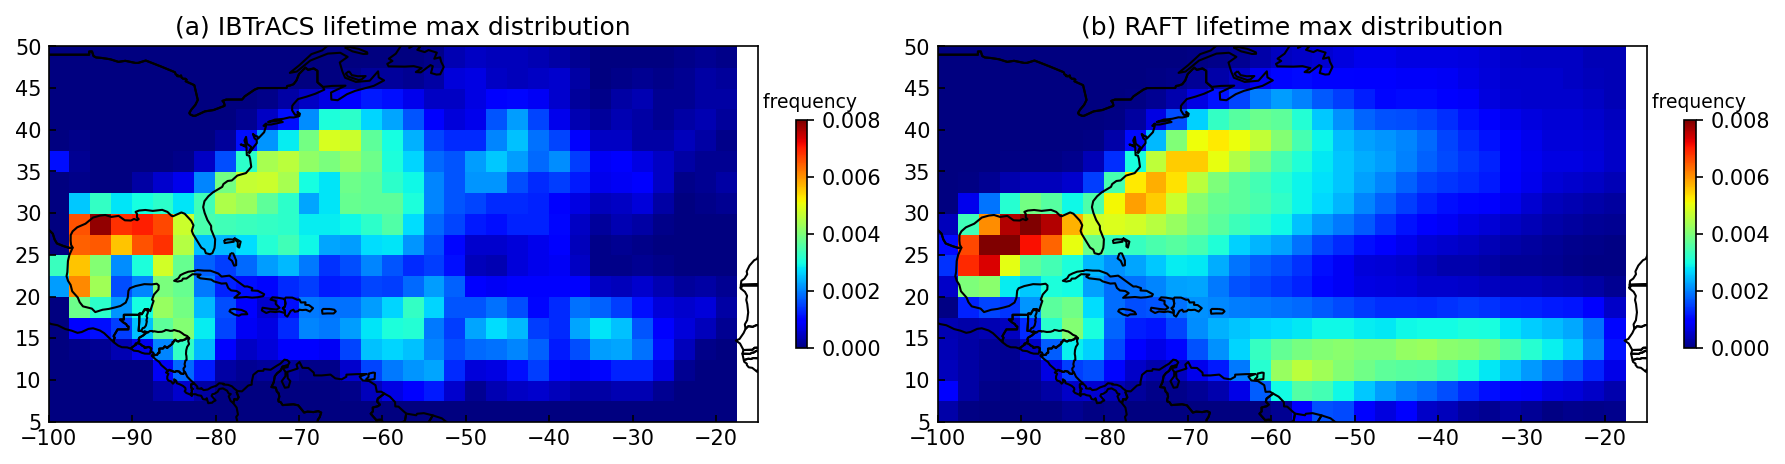

In [73]:
fig,axes = plt.subplots(1,2,dpi=150,figsize=(12,3.3))

ax = axes[0]
mypcolor = ax.pcolormesh(lon_mesh,lat_mesh, ltm_obs,cmap='jet',vmin=0,vmax=0.008) #,vmin=-0.05,vmax=0.05
clb = plt.colorbar(mypcolor, fraction=0.015,ax=ax)
clb.ax.set_title('   frequency',fontsize=9)
world.plot(ax=ax,edgecolor='k',linewidth=1,facecolor='none')
ax.set_title('(a) IBTrACS lifetime max distribution')  #1971-2021

ax = axes[1]
mypcolor = ax.pcolormesh(lon_mesh,lat_mesh, ltm_syn,cmap='jet',vmin=0,vmax=0.008) #,vmin=-0.05,vmax=0.05, cmap='Reds'
clb = plt.colorbar(mypcolor, fraction=0.015,ax=ax) #shrink=0.6,
clb.ax.set_title('   frequency',fontsize=9)
world.plot(ax=ax,edgecolor='k',linewidth=1,facecolor='none')
ax.set_title('(b) RAFT lifetime max distribution')

for ax in axes.flatten():
    ax.set_xlim(-100,-15)
    ax.set_ylim(5,50)
    ax.tick_params(axis='both',direction='in')

plt.tight_layout()
plt.savefig('analysis/Fig R3. lifetime max count and distribution map.png', dpi=330)

In [71]:
temp_a = ltm_syn[(ltm_obs>0)&(ltm_syn>0)]
temp_b = ltm_obs[(ltm_obs>0)&(ltm_syn>0)]
r = pearsonr(temp_a, temp_b)
print('pearson correlation between reanalysis and observation over the NA basin is, with the p-value: ', r)

pearson correlation between reanalysis and observation over the NA basin is, with the p-value:  (0.8517173951123262, 1.657497897442919e-129)


## TC statistics

In [51]:
# get statistics for table:
vs_mean_syn = np.nanmean(vmaxsyn[vmaxsyn>0])
vs_mean_obs = np.nanmean(vsmc[vsmc>0])
vs_mean_syn_std = np.nanstd(vmaxsyn[vmaxsyn>0])
vs_mean_obs_std = np.nanstd(vsmc[vsmc>0])

temp = np.nanmax(vmaxsyn,axis=1)
vs_max_syn = np.nanmean(temp)
vs_max_syn_std = np.nanstd(temp)

temp = np.nanmax(vsmc,axis=1)
vs_max_obs = np.nanmean(temp)
vs_max_obs_std = np.nanstd(temp)

# average pressure
slp_mean_syn = np.nanmean(mslpsyn[vmaxsyn>0])
slp_mean_obs = np.nanmean(slpmc[vsmc>0])
slp_mean_syn_std = np.nanstd(mslpsyn[vmaxsyn>0])
slp_mean_obs_std = np.nanstd(slpmc[vsmc>0])

temp = np.nanmin(mslpsyn,axis=1)
slp_min_syn = np.nanmean(temp)
slp_min_syn_std = np.nanstd(temp)

temp = np.nanmin(slpmc,axis=1)
slp_min_obs = np.nanmean(temp)
slp_min_obs_std = np.nanstd(temp)

#average radius of max wind
rmw_mean_syn = np.nanmean(rmaxsyn[vmaxsyn>0])
rmw_mean_obs = np.nanmean(rmwmc[vsmc>0])
rmw_mean_syn_std = np.nanstd(rmaxsyn[vmaxsyn>0])
rmw_mean_obs_std = np.nanstd(rmwmc[vsmc>0])

df_stat = pd.DataFrame({'index':['Average wind speed along track (knot)',
                                 'Average max wind along track (knot)',
                                 'Average pressure along track (hPa)',
                                 'Average min pressure along track (hPa)',
                                 'Average radius of max wind along track'],
                       'IBTrACS mean':[vs_mean_obs, vs_max_obs, slp_mean_obs, slp_min_obs,rmw_mean_obs],
                       'IBTrACS std':[vs_mean_obs_std, vs_max_obs_std, slp_mean_obs_std, slp_min_obs_std,rmw_mean_obs_std],
                        'RAFT mean':[vs_mean_syn, vs_max_syn, slp_mean_syn, slp_min_syn,rmw_mean_syn],
                       'RAFT std':[vs_mean_syn_std, vs_max_syn_std, slp_mean_syn_std, slp_min_syn_std,rmw_mean_syn_std],
                       '# of std from IBTrACS mean':[(vs_mean_syn-vs_mean_obs)/np.nanstd(vsmc[vsmc>0]), 
                                                     (vs_max_syn-vs_max_obs)/np.nanstd(np.nanmax(vsmc,axis=1)), 
                                                     (slp_mean_syn-slp_mean_obs)/np.nanstd(slpmc[vsmc>0]),
                                                     (slp_min_syn-slp_min_obs)/np.nanstd(np.nanmin(slpmc,axis=1)),
                                                     (rmw_mean_syn-rmw_mean_obs)/np.nanstd(rmwmc[vsmc>0])]})
df_stat = df_stat.set_index('index')
df_stat

C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: All-NaN axis encountered
  import sys
C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: All-NaN slice encountered
  # This is added back by InteractiveShellApp.init_path()
C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: All-NaN slice encountered
C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: All-NaN slice encountered
C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: All-NaN slice encountered


,IBTrACS mean,IBTrACS std,RAFT mean,RAFT std,# of std from IBTrACS mean
index,,,,,
Average wind speed along track (knot),53.243512,24.379920,54.881374,24.937450,0.067181
Average max wind along track (knot),68.089277,29.122805,64.877998,31.527475,-0.110267
Average pressure along track (hPa),992.026453,18.940323,990.136780,18.214249,-0.099770
Average min pressure along track (hPa),979.444352,24.544949,982.848816,23.028374,0.138703
Average radius of max wind along track,45.279052,31.115687,36.860943,12.859919,-0.270542


### Plot the sample TC and rainfall over cities

In [52]:
icity_rain_ls = [13, 23, 37, 50]
city_limit = [120, 120, 350, 250, 150]
itrack_cities = [24254, 11038, 11384, 38875]
vmax_cities = [250, 300, 600, 300]
ax_titles = ['(a) ', '(b) ', '(c) ', '(d) ']
for icity in icity_rain_ls:
    print(city_names[icity], end=', ')

New York City, Baltimore, Miami, Houston, 

In [53]:
# rainfall meshgrid
mydir = 'C:/2016/85_RAFT/data/sample_TCR/'
f = h5.File(mydir + 'latlon_grid.h5', 'r')
lats_tcr = f['lat'][:]
lons_tcr = f['lon'][:]

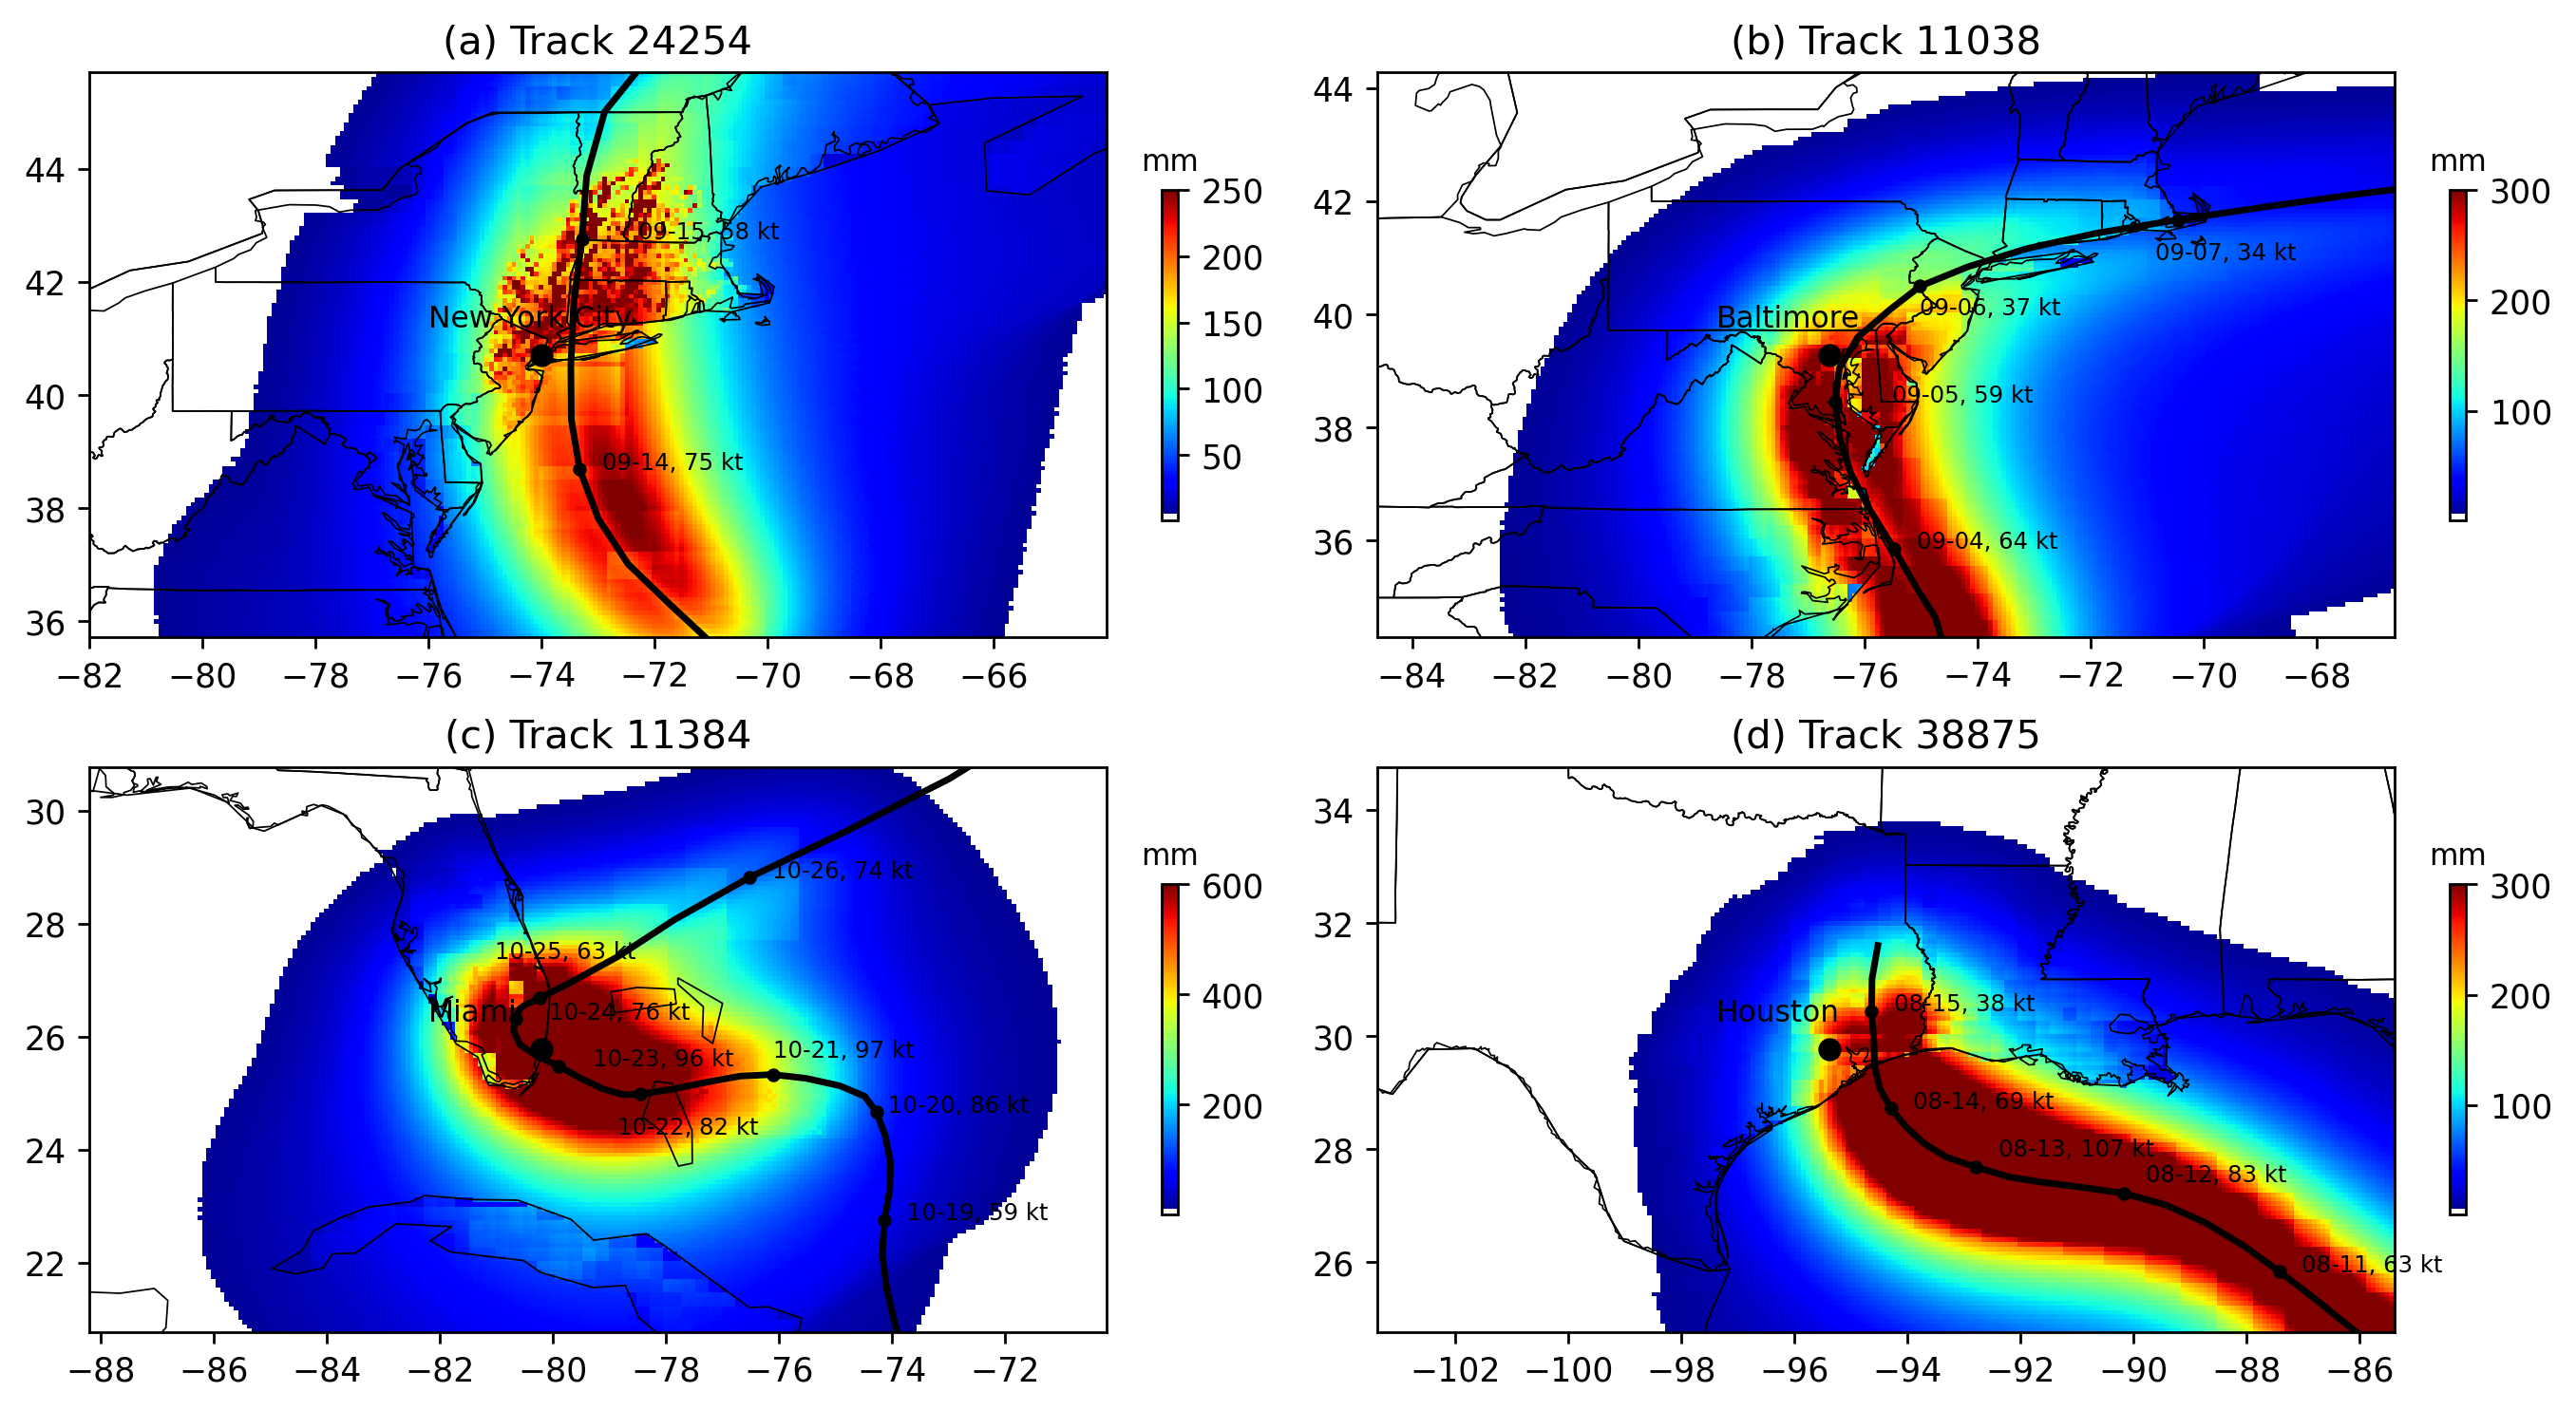

In [54]:
## make sample track and rainfall plot
from matplotlib import cm
import matplotlib.colors as mcolors
from copy import deepcopy
import shutil
cmp = ListedColormap(['skyblue','lightskyblue','green','orange','orangered','purple'])
norm = BoundaryNorm([25, 34,64,83,96,113,137], cmp.N)

jet = cm.get_cmap('jet') # plasma_r
newcolors = jet(np.linspace(0, 1, 256))
newcolors[0:5,:] = np.array([1,1,1,1])
newcmp = mcolors.ListedColormap(newcolors)

fig, axs = plt.subplots(2,2, figsize = [11,6], dpi=250)

for iax, ax in enumerate(axs.flatten()):
    ax.set_aspect('equal')
    itrack = itrack_cities[iax]
    icity_interest = icity_rain_ls[iax]
    file = mydir + '/modeled_rainfall_ERA5_syn_'+ str(itrack) +'.nc'
    with netCDF4.Dataset(file, 'r') as nc:
        p_accum = nc.variables['p_accum'][:]
        p_accum_f = nc.variables['p_accum_f'][:]
        p_accum_s = nc.variables['p_accum_s'][:]
        p_accum_h = nc.variables['p_accum_h'][:]
        p_accum_t = nc.variables['p_accum_t'][:]
        p_accum[p_accum<1] = np.nan
    
    x = lonsyn[itrack,:]
    y = latsyn[itrack,:]
    vs = vmaxsyn[itrack,:]
    dates_temp = datesyn[itrack,:] 
    

    x = x[vs>0]
    y = y[vs>0]
    dates_temp = dates_temp[vs>0]
    vs = vs[vs>0]
    
    #print(x, y, vs)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments_i = np.concatenate([points[:-1], points[1:]], axis=1)
    ##  plot by step intensity
    lc = LineCollection(segments_i, cmap=cmp, norm=norm, alpha=0.6)
    lc.set_array(vs)
    lc.set_linewidth(2)
    
    mypcolor = ax.pcolormesh(lons_tcr,lats_tcr, p_accum,cmap=newcmp,alpha=1, vmin=1,vmax=vmax_cities[iax], shading='auto')
    #ax.contour(lons,lats, p_accum,cmap=newcmp,alpha=1, vmin=1, vmax=400, shading='auto', linewdith=0.5)
    clb = plt.colorbar(mypcolor, ax=ax, fraction=0.015)
    clb.ax.set_title('mm', fontsize=9)
    

    #line = ax.add_collection(deepcopy(lc))
    world.plot(ax=ax, facecolor='none',edgecolor='k',linewidth=0.5)
    USA.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.5)
    ax.set_title(ax_titles[iax] + 'Track ' + str(itrack) )
    ax.plot(x, y, linewidth=2, color='k')

    # plot the city
    ax.scatter(city_lon[icity_interest], city_lat[icity_interest], color='k')
    ax.text(city_lon[icity_interest]-2, city_lat[icity_interest]+0.5, city_names[icity_interest], color='k',fontsize=9)
    ax.set_xlim([city_lon[icity_interest]-8,city_lon[icity_interest]+10])
    ax.set_ylim([city_lat[icity_interest]-5,city_lat[icity_interest]+5])
    
    # annotate the track
    for istep, vmax in enumerate(vs[:-1]):                                                 
        if istep% 4 == 0:
            if not (x[istep]> city_lon[icity_interest]-7 and x[istep]< city_lon[icity_interest]+9):
                continue
            if not (y[istep]> city_lat[icity_interest]-5 and y[istep]< city_lat[icity_interest]+5):
                continue   
            ax.scatter(x[istep], y[istep],s=10,color='k')
            if itrack==11384 and istep==36:
                x_offset, y_offset = -0.8, 0.7
            elif itrack==11384 and istep==32:
                x_offset, y_offset = 0.6, 0
            elif itrack==11384 and istep==28:
                x_offset, y_offset = 0.6, 0
            elif itrack==11384 and istep==20:
                x_offset, y_offset = 0, 0.3
            elif itrack==11384 and istep==16:
                x_offset, y_offset = 0.2, 0
            elif itrack==24254 and istep==56:
                x_offset, y_offset = 1, 0
            elif itrack==11038 and istep==16:
                x_offset, y_offset = 0, -0.5
            elif itrack==11038 and istep==12:
                x_offset, y_offset = 1, 0
            elif itrack==38875 and istep in [40,44]:
                x_offset, y_offset = 0.4, 0.2
            elif np.abs(y[istep+1] - y[istep])< 0.3:
                x_offset, y_offset = -0.4, -0.7
            else:
                x_offset, y_offset = 0.4, 0
            
            ax.text(x[istep]+x_offset, y[istep] + y_offset,str(dates_temp[istep])[5:-3] + ', ' + str(int(vs[istep]))+' kt',color='k', fontsize=7)
            #print(itrack,icity_interest, istep,x[istep],round(y[istep],4),city_lon[icity_interest], city_lat[icity_interest],  vmax, dates_temp[istep])

plt.tight_layout()
fig.savefig('analysis/Fig 7. Sampel TC pass 4 cities.png', dpi=330)